# 1. Introduction

Voir project3_description.ipynb

# 2. Démarche méthodologique

Voir project3_description.ipynb

# 3. Exploration des données

## <a name="C31">3.1 Chargement<a>

### <a name="C2311">3.1.1 Importation des librairies utiles<a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm

from datetime import datetime
from IPython.display import Image
from PIL import Image
from skimage import io
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.ticker import AutoMinorLocator
from bqplot import pyplot as plt2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### <a name="C312">3.1.2 Les fonctions</a>

#### <a name="C3121">3.1.2.1 Correction des retours lignes</a>

In [2]:
# treatment for \n
# fichier à traitre "data/fr.openfoodfacts.org.products.csv"
# fichier de sortie: clean_file_c1
# i_treat: True/False --> créer le fichier cible ou juste noter les lignes qui ne présentent pas le bon nombre de '\t'
#
import os
import pandas as pd
from pathlib import Path
#
clean_file_c1="fr.openfoodfacts.org.products_c1.csv"

def clean_file(i_file_name="fr.openfoodfacts.org.products.csv", 
               o_file_name=clean_file_c1, i_treat=True):
    #
    l_cmpt=0
    l_nbr_bt=0
    ll=[]
    l_myline_b=''
    #
    try:
        l_myfile = open(i_file_name, encoding = 'utf8', mode="r")
        l_myline = l_myfile.readline()
    except Exception as e:
        print(e)
        return ll
        
    #
    l_path_file = Path(o_file_name)
    l_outout_file_exist = l_path_file.is_file()
    if not l_outout_file_exist or not(i_treat):
        with open(o_file_name, encoding="utf-8", mode="a") as f:
            while l_myline:
                l_nbr_bt = l_myline.count("\t")
                if l_nbr_bt != 161:
                    ll.append((l_cmpt, l_nbr_bt))
                    #
                    l_myline_b=l_myline.replace('\n','')
                    l_myline = l_myfile.readline()
                    l_myline=l_myline_b+l_myline
                if i_treat:
                    f.write(l_myline)
                l_myline = l_myfile.readline()
                l_cmpt+=1
            l_myfile.close()
        f.close()
        if not i_treat:
            try:
                if not l_outout_file_exist and os.stat(o_file_name).st_size == 0:
                    os.remove(o_file_name)
                print('Do not generate !!: ', o_file_name)   
            except:
                print('Do not generate !!: ', o_file_name)             
    else: 
        print('output File exists: ', o_file_name)
    #
    return ll

#### <a name="C3122">3.1.2.2 Suppression colonnes vides</a>

In [3]:
def supprimer_colonnes_vides(df) :
    
    #Calcul du nombre de null
    nb_na = df.isnull().sum() 
    #Prise en compte que des colonnes ayant un nombre de vide = au nombre total de ligne = colonne 100% vides
    nb_na=nb_na[nb_na==df.shape[0]]
    #Annonce du bilan
    print("Liste des",len(nb_na),"colonnes vides et nombre de lignes vides par colonnes sur un dataframe de",df.shape[0],"lignes :")
    print(nb_na)

    #Passage du nom des colonnes en liste
    nb_na=nb_na.index.tolist()

    #Suppression des colonnes du dataframe dont le nom est dans la liste
    i=0
    for colonne in nb_na:
        df.drop(columns=colonne, axis=1, inplace = True)
        i+=1
    print("Les",i,"colonnes ont étés supprimées du DataFrame envoyé à la fonction")
    
    return df


#### <a name="C3123">3.1.2.3 Corrélation numérique</a>

In [4]:
def correlation_num(taux_remplissage,df) :
    
    #Création de la dateframe colonne+son type
    df_type=df.dtypes
    df_type=pd.DataFrame(df_type)
    df_type.reset_index(inplace=True)
    df_type.columns=['colonne','type']
    
    
    #Affichage des colonnes ayant des manquants + quantité des manquants
    nb_na = df.isnull().sum() 
    #nb_na=nb_na[nb_na>0]

    #Création d'un dataframe avec les manquants
    df_miss=pd.DataFrame(nb_na).reset_index()
    df_miss.columns=['colonne','quantite_manquante']
    df_miss.sort_values('quantite_manquante', ascending= True, inplace=True)

    #Ajout du % de manquants
    df_miss['taux_manquant'] = round(((df_miss['quantite_manquante']/df.shape[0])*100),4)
    df_miss.reset_index(drop=True)

    #Ajout du % de remplissage
    df_miss['taux_remplissage'] = round(((1-(df_miss['quantite_manquante']/df.shape[0]))*100),4)
    df_miss.reset_index(drop=True)

    #Ajout du type
    df_miss_type= pd.merge(df_miss, df_type, on='colonne', how='left')
    df_miss_type
    
    #Selection des lignes concernées remplies au dessus du taux de remplissage
    df_miss_type_num=df_miss_type.loc[(df_miss_type['taux_remplissage']>=taux_remplissage) & (df_miss_type['type']=="float64") ,:]
    df_miss_type_num.reset_index(inplace=True,drop=True)
    display(df_miss_type_num)
    
    plt.figure(figsize=(10,5))
    plt.bar(height=df_miss_type_num['taux_remplissage'], x=df_miss_type_num['colonne'])#création du diagramme bar
    plt.title("Taux_remplissage des colonnes", fontsize=15)
    plt.xticks(rotation=90)#Rotation de 90°de l'axe des abscisses
    plt.ylabel("%", fontsize=15) 
    plt.xlabel("Nom des colonnes", fontsize=15) 
    plt.show()
    
    
    #Création de la liste des colonnes
    list_num=df_miss_type_num['colonne'].tolist()
    
            
    #Création de la dataframe associée à la liste et remplissage des Null par 0 car ici on ne traite que de quantité ou de masse
    df_list_num=df[list_num]
   
    
    #Suppression de quelques colonnes pour ne pas la considérer dans la corrélation
    df_list_num_reduite=df_list_num.copy()
    #df_list_num_reduite.drop(columns='nutrition-score-fr_100g', axis=1, inplace = True)
    df_list_num_reduite.drop(columns='nutrition_grade_fr_2', axis=1, inplace = True)
    #df_list_num_reduite.drop(columns='energy_100g', axis=1, inplace = True)
    
    #Traitement de la corrélation
    corr =  df_list_num_reduite.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5});
  
    df_list_num.fillna(0, inplace=True)# le nutriscore n'est pas impacté car toutes les 2 colonnes (nutrition-score-fr_100g et nutrition_grade_fr_2)  sont remplies dans data3
    return df_list_num

#### <a name="C3124">3.1.2.4 ACP</a>

In [5]:
def ACP(df_list_num,n_components,c1,c2):
    
    x_y = (c1,c2)
    #Séparation des données
    X = df_list_num.values

    #Récupération des index
    names = df_list_num.index

    #récupération des noms de colonnes
    features = df_list_num.columns

    #Opération de centrage réduction
    scaler = StandardScaler()

    #scaler.fit(X)
    #X_scaled = scaler.transform(X)
    #X_scaled[:5]

    X_scaled = scaler.fit_transform(X)

    #Affichage de la moyenne =0 et ecart-type=1
    idx = ["mean", "std"]
    pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

    #ACP
    #instanciation de l'ACP
    pca = PCA(n_components=n_components)
    #Entrainement sur les données scalées
    pca.fit(X_scaled)

    #Interception de la variance captée
    pca.explained_variance_ratio_

    #Enregistrement des variances dans une variable :
    scree = (pca.explained_variance_ratio_*100).round(2)
    
    #Calcul et enregistrement des sommes cumulées
    scree_cum = scree.cumsum().round()
    
    #Création de la liste des composantes
    x_list = range(1, n_components+1)
    list(x_list)

    #Affichage de l'éboulis des valeurs propres
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum,c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

    
    #Calcul des composantes
    pcs = pca.components_
    
    #Création du dataframe associé
    pcs = pd.DataFrame(pcs)

    #Renommage des index et colonnes
    pcs.columns = features
    pcs.index = [f"F{i}" for i in x_list]
    pcs.round(2)

    #Affichage du heatmap
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=False, square=True, cmap="coolwarm", fmt="0.2f")

    #Affichage du graph des corrélations
    correlation_graph(pca, x_y, features)
    
    #projection des individus
    X_proj = pca.transform(X_scaled)
    X_proj[:5]
    x_y = [c1,c2]
    display_factorial_planes(X_proj, x_y)
    
    #Affichage amélioré
    #display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o")
    
    return pcs

#### <a name="C3125">3.1.2.5 Remplacer_vide_par_0</a>

In [6]:
def remplacer_null_par_0(df, colonne) :
    df_tmp=df.loc[df[colonne].isnull(),:]
    for index in df_tmp.index:
        df.loc[index, colonne]= 0

#### <a name="C3126">3.1.2.6 colonnes correlees</a>

In [7]:
def colonnes_correlees(pcs,taux) :
    list_variables = []
    for j in range(pcs.shape[1]):
        for i in range(pcs.shape[0]):
            if abs(pcs.iloc[i,j])>taux :
                list_variables.append(pcs.columns.values[j]) 
    list_variables =list(set(list_variables))
    return list_variables

#### <a name="C3127">3.1.2.7 Cercle des corrélations</a>

In [8]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[0, i],  
                pca.components_[1, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[0, i] + 0.05,
                pca.components_[1, i] + 0.05,
                features[i])
       
    display(np.round(pca.explained_variance_ratio_,2))
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

#### <a name="C3128">3.1.2.8 Projection plan factoriel</a>

In [9]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    plt.scatter(   X_[:, x], 
                        X_[:, y], 
                        alpha=alpha, 
                        c=c, 
                        cmap="Set1", 
                        marker=marker)


    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


#### <a name="C3129">3.1.2.9 Correlation categorielle</a>

In [10]:
def correlation_cat(taux_remplissage,df) :
    
    
     #Création de la dateframe colonne+son type
    df_type=df.dtypes
    df_type=pd.DataFrame(df_type)
    df_type.reset_index(inplace=True)
    df_type.columns=['colonne','type']
    
    #Affichage des colonnes ayant des manquants + quantité des manquants
    nb_na = df.isnull().sum() 
    #nb_na=nb_na[nb_na>0]

    #Création d'un dataframe avec les manquants
    df_miss=pd.DataFrame(nb_na).reset_index()
    df_miss.columns=['colonne','quantite_manquante']
    df_miss.sort_values('quantite_manquante', ascending= True, inplace=True)

    #Ajout du % de manquants
    df_miss['taux_manquant'] = round(((df_miss['quantite_manquante']/df.shape[0])*100),4)
    df_miss.reset_index(drop=True)

    #Ajout du % de remplissage
    df_miss['taux_remplissage'] = round(((1-(df_miss['quantite_manquante']/df.shape[0]))*100),4)
    df_miss.reset_index(drop=True)

    #Ajout du type
    df_miss_type= pd.merge(df_miss, df_type, on='colonne', how='left')
    df_miss_type
    
    #Selection des lignes concernées remplies au dessus du taux de remplissage
    df_miss_type_cat=df_miss_type.loc[(df_miss_type['taux_remplissage']>=taux_remplissage) & (df_miss_type['type']=="object") ,:]
    df_miss_type_cat.reset_index(inplace=True,drop=True)
    display(df_miss_type_cat)
    
    plt.figure(figsize=(10,5))
    plt.bar(height=df_miss_type_cat['taux_remplissage'], x=df_miss_type_cat['colonne'])#création du diagramme bar
    plt.title("Taux_remplissage des colonnes", fontsize=15)
    plt.xticks(rotation=90)#Rotation de 90°de l'axe des abscisses
    plt.ylabel("%", fontsize=15) 
    plt.xlabel("Nom des colonnes", fontsize=15) 
    plt.show()
    
    
    #Création de la liste des colonnes
    list_cat=df_miss_type_cat['colonne'].tolist()
    
    #vérification de la présence ou non de "nutrition-score-fr_100g" pour ne pas le faire apparaitre 2 fois dans la liste
    if "nutrition-score-fr_100g" not in list_cat :
        list_cat.append("nutrition-score-fr_100g")
        
    #Création de la dataframe associée à la liste
    df_list_cat=df[list_cat]
    
    
    return df_list_cat

#### <a name="C31210">3.1.2.10 Rapport Corrélation - ANOVA </a>

In [11]:
def eta_squared(x,y):
    moyenne_x = x.mean()
    classes = []
    for classe in y.unique():
        xi_classe = x[y==classe]
        classes.append({'ni': len(xi_classe),'moyenne_classe': xi_classe.mean()})
    SCT = sum([(xj-moyenne_x)**2 for xj in x])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_x)**2 for c in classes])
    return SCE/SCT

### <a name="C313">3.1.3 Chargement des données provenant du fichier CSV</a>

In [12]:
#Correction des retours lignes du fichier csv (\n)
clean_file()

[(189068, 26),
 (189102, 26),
 (189107, 26),
 (189116, 26),
 (189148, 26),
 (189155, 26),
 (189156, 26),
 (189161, 26),
 (189234, 26),
 (189235, 26),
 (189238, 26),
 (189239, 26),
 (189248, 26),
 (189249, 26),
 (189255, 26),
 (189257, 26),
 (189329, 26),
 (189345, 26),
 (189346, 26),
 (189360, 26),
 (189384, 26),
 (189385, 26),
 (189395, 26)]

In [13]:
#Appel du nouveau fichier csv crée par la fonction clean_file au dessus
data=pd.read_csv('fr.openfoodfacts.org.products_c1.csv', encoding = "UTF-8", sep='\t')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1196\853611449.py:2: DtypeWarning: Columns (0,19,20,24,25,26,28,35,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('fr.openfoodfacts.org.products_c1.csv', encoding = "UTF-8", sep='\t')


In [14]:
#Pour eviter de tronquer les listes affichées car le dataset est important en terme de taille
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [15]:
#Création d'un copie de data pour récupérer les informations d'origines si necessaire
data2=data.copy()
data2.head()

code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

   last_modified_t last_modified_datetime                    product_name  \
0       1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1       1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2       1489069957   2017-03-09T14:32:37Z                         Peanuts   
3       1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4       1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity packaging packaging_tags           brands  \
0          NaN      1kg       NaN            NaN  Ferme t'y R'nao   
1          NaN      NaN       NaN            NaN              NaN   
2          NaN      NaN       NaN            NaN   Torn & Glasser   
3          NaN      NaN       NaN            NaN        Grizzlies   
4          NaN      NaN       NaN            NaN   Bob's Red Mill   

       brands_tags categories categories_tags categories_fr origins  \
0  ferme-t-y-r-nao        NaN             NaN           NaN     NaN   
1              NaN        NaN             NaN           NaN     NaN   
2     torn-glasser        NaN             NaN           NaN     NaN   
3        grizzlies        NaN             NaN           NaN     NaN   
4   bob-s-red-mill        NaN             NaN           NaN     NaN   

  origins_tags manufacturing_places manufacturing_places_tags labels  \
0          NaN                  NaN                       NaN    NaN   
1          NaN                  NaN                       NaN    NaN   
2          NaN                  NaN                       NaN    NaN   
3          NaN                  NaN                       NaN    NaN   
4          NaN                  NaN                       NaN    NaN   

  labels_tags labels_fr emb_codes emb_codes_tags first_packaging_code_geo  \
0         NaN       NaN       NaN            NaN                      NaN   
1         NaN       NaN       NaN            NaN                      NaN   
2         NaN       NaN       NaN            NaN                      NaN   
3         NaN       NaN       NaN            NaN                      NaN   
4         NaN       NaN       NaN            NaN                      NaN   

   cities cities_tags purchase_places stores countries    countries_tags  \
0     NaN         NaN             NaN    NaN     en:FR         en:france   
1     NaN         NaN             NaN    NaN        US  en:united-states   
2     NaN         NaN             NaN    NaN        US  en:united-states   
3     NaN         NaN             NaN    NaN        US  en:united-states   
4     NaN         NaN             NaN    NaN        US  en:united-states   

  countries_fr                                   ingredients_text allergens  \
0       France                                                NaN       NaN   
1   États-Unis  Bananas, vegetable oil (coconut oil, corn oil ...       NaN   
2   États-Unis  Peanuts, wheat flour, sugar, rice flour, tapio...       NaN   
3   États-Unis  Organic hazelnuts, organic cashews, organic wa...       NaN   
4   États-Unis                                    Organic polenta       NaN   

   allergens_fr traces traces_tags traces_fr     serving_size  no_nutriments  \
0        

## 3.2 Présentation de la structure

### <a name="C321">3.2.1 Nombre de lignes/colonnes</a>

In [16]:
print(data2.shape[0])
print("------------")
print(len(data2.columns))
print("------------")
print("Nom de toutes les colonnes : ")
data2.columns.values

320749
------------
162
------------
Nom de toutes les colonnes : 


array(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags',
       'brands', 'brands_tags', 'categories', 'categories_tags',
       'categories_fr', 'origins', 'origins_tags', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr',
       'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo',
       'cities', 'cities_tags', 'purchase_places', 'stores', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'allergens',
       'allergens_fr', 'traces', 'traces_tags', 'traces_fr',
       'serving_size', 'no_nutriments', 'additives_n', 'additives',
       'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n',
       'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil',
   

Nous avons donc 320772 produits enregistrés. 162 colonnes permettent de décrire ces produits.  Le code sera très utile pour identifier chaque produit lors des analyses. On peut catégoriser ces colonnes en 5 groupes : 

**1. Informations générales** <br>
**2. Caractéristiques physiques** <br>
**3. Compositions et origines** <br>
**4. Valeurs nutritives** <br>
**5. Impact environnemental et nutriscores** <br>


### <a name="C322">3.2.2 Types de données</a>

In [17]:
print(data2.dtypes)  

code                                           object
url                                            object
creator                                        object
created_t                                       int64
created_datetime                               object
last_modified_t                                 int64
last_modified_datetime                         object
product_name                                   object
generic_name                                   object
quantity                                       object
packaging                                      object
packaging_tags                                 object
brands                                         object
brands_tags                                    object
categories                                     object
categories_tags                                object
categories_fr                                  object
origins                                        object
origins_tags                

In [18]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(108), int64(2), object(52)
memory usage: 396.4+ MB


## 3.3 Nettoyage

### <a name="C331"> 3.3.1 Valeurs manquantes</a> 

Je vais maintenant afficher le nombre de valeurs manquantes pour les colonnes non complétées en totalité :

In [19]:
#Affichage des colonnes ayant des manquants + quantité des manquants
nb_na = data2.isnull().sum() 
nb_na=nb_na[nb_na>0]

#Création d'un dataframe avec les manquants
df_miss=pd.DataFrame(nb_na).reset_index()
df_miss.columns=['colonne','quantite_manquante']
df_miss.sort_values('quantite_manquante', ascending= False, inplace=True)

#Ajout du % de manquants
df_miss['% manquant'] = round((df_miss['quantite_manquante']/data2.shape[0])*100,4)
df_miss.reset_index(drop=True)

colonne  quantite_manquante  \
0                           water-hardness_100g              320749   
1                             gondoic-acid_100g              320749   
2                            nutrition_grade_uk              320749   
3                             butyric-acid_100g              320749   
4                             caproic-acid_100g              320749   
5                                 no_nutriments              320749   
6                                  allergens_fr              320749   
7                             behenic-acid_100g              320749   
8                          lignoceric-acid_100g              320749   
9                             cerotic-acid_100g              320749   
10                           melissic-acid_100g              320749   
11                                       cities              320749   
12                    ingredients_from_palm_oil              320749   
13             dihomo-gamma-linolenic-acid_100g              320749   
14                            elaidic-acid_100g              320749   
15        ingredients_that_may_be_from_palm_oil              320749   
16                               mead-acid_100g              320749   
17                             erucic-acid_100g              320749   
18                          glycemic-index_100g              320749   
19                              chlorophyl_100g              320749   
20                           nervonic-acid_100g              320749   
21                           caprylic-acid_100g              320748   
22                           myristic-acid_100g              320748   
23                           palmitic-acid_100g              320748   
24                            stearic-acid_100g              320748   
25                          arachidic-acid_100g              320748   
26                           montanic-acid_100g              320748   
27                    gamma-linolenic-acid_100g              320748   
28                             capric-acid_100g              320747   
29                                 maltose_100g              320745   
30                             lauric-acid_100g              320745   
31                        arachidonic-acid_100g              320741   
32                             nucleotides_100g              320740   
33                           maltodextrins_100g              320738   
34                              molybdenum_100g              320738   
35                              oleic-acid_100g              320736   
36                          serum-proteins_100g              320733   
37                                chromium_100g              320729   
38                             omega-9-fat_100g              320728   
39                                 glucose_100g              320723   
40                                  casein_100g              320722   
41                                 taurine_100g              320720   
42                   eicosapentaenoic-acid_100g              320716   
43                           beta-carotene_100g              320715   
44                                fructose_100g              320711   
45                                  silica_100g              320711   
46                                      ph_100g              320700   
47                    docosahexaenoic-acid_100g              320694   
48                                 sucrose_100g              320677   
49                                caffeine_100g              320671   
50                                fluoride_100g              320670   
51                             bicarbonate_100g              320668   
52                           linoleic-acid_100g              320600   
53                                chloride_100g              320591   
54             collagen-meat-protein-ratio_100g              320584   
55                    alpha-linolenic-acid_100g              320

#### <a name="C3311">3.3.1.1 Suppression des colonnes vides<a>

Afin d'alléger le DataFrame, je supprime les colonnes pour lesquelles j'ai 100% de manquants (=320749 valeurs manquantes)

In [20]:
data2=supprimer_colonnes_vides(data2)

Liste des 21 colonnes vides et nombre de lignes vides par colonnes sur un dataframe de 320749 lignes :
cities                                   320749
allergens_fr                             320749
no_nutriments                            320749
ingredients_from_palm_oil                320749
ingredients_that_may_be_from_palm_oil    320749
nutrition_grade_uk                       320749
butyric-acid_100g                        320749
caproic-acid_100g                        320749
behenic-acid_100g                        320749
lignoceric-acid_100g                     320749
cerotic-acid_100g                        320749
melissic-acid_100g                       320749
dihomo-gamma-linolenic-acid_100g         320749
elaidic-acid_100g                        320749
gondoic-acid_100g                        320749
mead-acid_100g                           320749
erucic-acid_100g                         320749
nervonic-acid_100g                       320749
chlorophyl_100g                  

In [21]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Columns: 141 entries, code to nutrition-score-uk_100g
dtypes: float64(87), int64(2), object(52)
memory usage: 345.0+ MB


#### <a name="C3312">3.3.1.2 Valeurs nutritives <a>

Les valeurs nutritives et plus précisément les composés (ex : vitamine C), sont des informations très importantes pour la création de l’application. Ils indique la quantité de composé présente dans une portion de 100g (ou 100ml) d’un aliment (ou une boisson).<br>
Remarque : 2 colonnes supplémentaires sont consacrées à l’énergie (en kJ), calculées à partir de certains composés(glucides, lipides et protéines).<br>
Ces colonnes contiennent des manquants. Cependant si une information est égale à null, on va la considérer à 0 pour signifier que le produit ne comporte pas ce composé (sauf pour "énergie" car tous les produit contiennent de l'énergie). 

#### <a name="C3313">3.3.1.3 Qualité nutritive <a> 

In [22]:
df_tmp=data2.loc[data2["nutrition-score-fr_100g"].isnull(),:]
print("Il y a", df_tmp.shape[0],"nutriscore vides. Ce qui représente",(df_tmp.shape[0]*100)/data2.shape[0],"% du dataset total")

Il y a 99516 nutriscore vides. Ce qui représente 31.0261294657193 % du dataset total


In [23]:
df_tmp=data2.loc[data2["nutrition_grade_fr"].isnull(),:]
print("Il y a", df_tmp.shape[0],"nutrigrade vides. Ce qui représente",(df_tmp.shape[0]*100)/data2.shape[0],"% du dataset total")

Il y a 99516 nutrigrade vides. Ce qui représente 31.0261294657193 % du dataset total


In [24]:
df_tmp=data2.loc[(data2["nutrition_grade_fr"].isnull()) & (data2["nutrition-score-fr_100g"].isnull()) ,:]
print("Il y a", df_tmp.shape[0],"nutrigrade et score vides. Ce qui représente",(df_tmp.shape[0]*100)/data2.shape[0],"% du dataset total")

Il y a 99516 nutrigrade et score vides. Ce qui représente 31.0261294657193 % du dataset total


#### <a name="C3314">3.3.1.4 Bilan<a>

Les colonnes suivantes sont complètes

In [25]:
#Affichage des colonnes n'ayant pas de manquants
nb_na = data2.isnull().sum() 
nb_na=nb_na[nb_na==0]
nb_na

code                      0
url                       0
created_t                 0
last_modified_t           0
last_modified_datetime    0
states                    0
states_tags               0
states_fr                 0
dtype: int64

Les colonnes suivantes sont incomplètes

In [26]:
#Affichage des colonnes ayant des manquants + quantité des manquants
nb_na = data2.isnull().sum() 
nb_na=nb_na[nb_na>0]

#Création d'un dataframe avec les manquants
df_miss=pd.DataFrame(nb_na).reset_index()
df_miss.columns=['colonnes','quantites_manquantes']
df_miss.sort_values('quantites_manquantes', ascending= False, inplace=True)

#Ajout du % de manquants
df_miss['% manquants'] = round((df_miss['quantites_manquantes']/data2.shape[0])*100,4)
df_miss.reset_index(drop=True)

colonnes  quantites_manquantes  \
0                     gamma-linolenic-acid_100g                320748   
1                            montanic-acid_100g                320748   
2                            caprylic-acid_100g                320748   
3                            myristic-acid_100g                320748   
4                            palmitic-acid_100g                320748   
5                             stearic-acid_100g                320748   
6                           arachidic-acid_100g                320748   
7                              capric-acid_100g                320747   
8                              lauric-acid_100g                320745   
9                                  maltose_100g                320745   
10                        arachidonic-acid_100g                320741   
11                             nucleotides_100g                320740   
12                           maltodextrins_100g                320738   
13                              molybdenum_100g                320738   
14                              oleic-acid_100g                320736   
15                          serum-proteins_100g                320733   
16                                chromium_100g                320729   
17                             omega-9-fat_100g                320728   
18                                 glucose_100g                320723   
19                                  casein_100g                320722   
20                                 taurine_100g                320720   
21                   eicosapentaenoic-acid_100g                320716   
22                           beta-carotene_100g                320715   
23                                  silica_100g                320711   
24                                fructose_100g                320711   
25                                      ph_100g                320700   
26                    docosahexaenoic-acid_100g                320694   
27                                 sucrose_100g                320677   
28                                caffeine_100g                320671   
29                                fluoride_100g                320670   
30                             bicarbonate_100g                320668   
31                           linoleic-acid_100g                320600   
32                                chloride_100g                320591   
33             collagen-meat-protein-ratio_100g                320584   
34                    alpha-linolenic-acid_100g                320563   
35                             omega-6-fat_100g                320561   
36                                  iodine_100g                320490   
37                                 lactose_100g                320487   
38                                  starch_100g                320483   
39                        carbon-footprint_100g                320481   
40                                  biotin_100g                320442   
41                                 polyols_100g                320335   
42                             omega-3-fat_100g                319908   
43                         energy-from-fat_100g                319892   
44                               vitamin-k_100g                319831   
45                                   cocoa_100g                319801   
46                                selenium_100g                319581   
47                               vitamin-e_100g                319409   
48                               manganese_100g                319129   
49                                  copper_100g                318643   
50                        pantothenic-acid_100g                318289   
51                                 folates_100g                317707   
52                  fruits-vegetables-nuts_100g                317703   
53                                    zinc_100g                316820   
54                      

Suppression de **21 colonnes** vides.<br>
Pour les autres colonnes la quantité de manquants est plus ou moins élevées mais les informations présentes méritent d'être là. Elle seront importantes pour la suite de notre étude

### <a name="C332">3.3.2 Détection des colonnes doublons/triplons </a>

#### <a name="C3321">3.3.2.1 Colonnes jumelles </a>

Dans la définition des colonnes, certaines d'entre elles semblent être des informations répétées sous un autre format. Nous allons détecter et identifier chacune d'elle et si besoin, alléger notre jeu de données en supprimant l'une des 2. 

##### <a name="C33211">3.3.2.1.1 "created_t" et "created_datetime" </a>

Définitions :<br>
-**created_t** : date that the product was added (UNIX timestamp format)<br>
-**created_datetime** : date that the product was added (iso8601 format: yyyy-mm-ddThh:mn:ssZ)

In [27]:
print("created_t")
print(data2['created_t'].isnull().value_counts())
print("created_datetime")
print(data2['created_datetime'].isnull().value_counts())

created_t
False    320749
Name: created_t, dtype: int64
created_datetime
False    320748
True          1
Name: created_datetime, dtype: int64


On vois que **created_datetime** possède 1 manquant. Affichons cette ligne : 

In [28]:
data2_tmp=data2.loc[data2['created_datetime'].isnull(),:]
data2_tmp

code                                                url  \
187478  3017760038409  http://world-fr.openfoodfacts.org/produit/3017...   

         creator  created_t created_datetime  last_modified_t  \
187478  marianne          0              NaN       1488992055   

       last_modified_datetime                product_name  \
187478   2017-03-08T16:54:15Z  Lulu la barquette (Fraise)   

                               generic_name quantity      packaging  \
187478  Génoise garnie à la purée de fraise    120 g  Paquet,Carton   

       packaging_tags brands brands_tags  \
187478  paquet,carton     LU          lu   

                                               categories  \
187478  Snacks sucrés,Biscuits et gâteaux,Biscuits,Bis...   

                                          categories_tags  \
187478  en:sugary-snacks,en:biscuits-and-cakes,en:bisc...   

                                            categories_fr origins  \
187478  Snacks sucrés,Biscuits et gâteaux,Biscuits,Bar...     NaN   

       origins_tags manufacturing_places manufacturing_places_tags  \
187478          NaN      France,Ardennes           france,ardennes   

                                   labels  \
187478  Sans colorants,Sans conservateurs   

                                labels_tags  \
187478  en:no-colorings,en:no-preservatives   

                                labels_fr emb_codes emb_codes_tags  \
187478  Sans colorants,Sans conservateurs       NaN            NaN   

       first_packaging_code_geo cities_tags    purchase_places stores  \
187478                      NaN         NaN  Courrières,France   Cora   

            countries            countries_tags   countries_fr  \
187478  France,Suisse  en:france,en:switzerland  France,Suisse   

                                         ingredients_text  allergens  \
187478  Sirop de glucose-fructose, purée de fraises 27...  blé, œufs   

                     traces      traces_tags            traces_fr  \
187478  Lait,Fruits à coque  en:milk,en:nuts  Lait,Fruits à coque   

              serving_size  additives_n  \
187478  Un biscuit (6,66g)          2.0   

                                                additives   additives_tags  \
187478   [ sirop-de-glucose-fructose -> fr:sirop-de-gl...  en:e440,en:e330   

                                 additives_fr  ingredients_from_palm_oil_n  \
187478  E440 - Pectines,E330 - Acide citrique                          0.0   

       ingredients_from_palm_oil_tags  \
187478                            NaN   

        ingredients_that_may_be_from_palm_oil_n  \
187478                                      0.0   

       ingredients_that_may_be_from_palm_oil_tags nutrition_grade_fr  \
187478                                        NaN                  d   

        pnns_groups_1       pnns_groups_2  \
187478  Sugary snacks  Biscuits and cakes   

                                                   states  \
187478  en:to-be-checked, en:complete, en:nutrition-fa...   

                                              states_tags  \
187478  en:to-be-checked,en:complete,en:nutrition-fact...   

                                                states_fr main_category  \
187478  A vérifier,Complet,Informations nutritionnelle...   en:biscuits   

       main_category_fr                                          image_url  \
187478         Biscuits  http://fr.openfoodfacts.org/images/products/30...   

                                          image_small_url  energy_100g  \
187478  http://fr.openfoodfacts.org/images/products/30...       1480.0   

        energy-from-fat_100g  fat_100g  saturated-fat_100g  \
187478                   NaN       2.1                 0.5   

        caprylic-acid_100g  capric-acid_100g  lauric-acid_100g  \
187478                 NaN               NaN               NaN   

        myristic-acid_100g  palmitic-acid_100g  stearic-acid_100g  \
187478                 NaN                 NaN                NaN   

        arachidic-acid_100g  montanic-

On remarquera que finalement **created_t**=0 pour **created_datetime** = vide. Passons à vide cette valeur à 0 :

In [29]:
i=0
data2_tmp=data2.loc[data2['created_t']==0,:]
for index in data2_tmp.index:
    data2.loc[index, 'created_t']= np.nan
    i+=1
print(i, " remplacements ont étés fait")
data2_tmp=data2.loc[data2['created_datetime'].isnull(),:]
data2_tmp

1  remplacements ont étés fait


code                                                url  \
187478  3017760038409  http://world-fr.openfoodfacts.org/produit/3017...   

         creator  created_t created_datetime  last_modified_t  \
187478  marianne        NaN              NaN       1488992055   

       last_modified_datetime                product_name  \
187478   2017-03-08T16:54:15Z  Lulu la barquette (Fraise)   

                               generic_name quantity      packaging  \
187478  Génoise garnie à la purée de fraise    120 g  Paquet,Carton   

       packaging_tags brands brands_tags  \
187478  paquet,carton     LU          lu   

                                               categories  \
187478  Snacks sucrés,Biscuits et gâteaux,Biscuits,Bis...   

                                          categories_tags  \
187478  en:sugary-snacks,en:biscuits-and-cakes,en:bisc...   

                                            categories_fr origins  \
187478  Snacks sucrés,Biscuits et gâteaux,Biscuits,Bar...     NaN   

       origins_tags manufacturing_places manufacturing_places_tags  \
187478          NaN      France,Ardennes           france,ardennes   

                                   labels  \
187478  Sans colorants,Sans conservateurs   

                                labels_tags  \
187478  en:no-colorings,en:no-preservatives   

                                labels_fr emb_codes emb_codes_tags  \
187478  Sans colorants,Sans conservateurs       NaN            NaN   

       first_packaging_code_geo cities_tags    purchase_places stores  \
187478                      NaN         NaN  Courrières,France   Cora   

            countries            countries_tags   countries_fr  \
187478  France,Suisse  en:france,en:switzerland  France,Suisse   

                                         ingredients_text  allergens  \
187478  Sirop de glucose-fructose, purée de fraises 27...  blé, œufs   

                     traces      traces_tags            traces_fr  \
187478  Lait,Fruits à coque  en:milk,en:nuts  Lait,Fruits à coque   

              serving_size  additives_n  \
187478  Un biscuit (6,66g)          2.0   

                                                additives   additives_tags  \
187478   [ sirop-de-glucose-fructose -> fr:sirop-de-gl...  en:e440,en:e330   

                                 additives_fr  ingredients_from_palm_oil_n  \
187478  E440 - Pectines,E330 - Acide citrique                          0.0   

       ingredients_from_palm_oil_tags  \
187478                            NaN   

        ingredients_that_may_be_from_palm_oil_n  \
187478                                      0.0   

       ingredients_that_may_be_from_palm_oil_tags nutrition_grade_fr  \
187478                                        NaN                  d   

        pnns_groups_1       pnns_groups_2  \
187478  Sugary snacks  Biscuits and cakes   

                                                   states  \
187478  en:to-be-checked, en:complete, en:nutrition-fa...   

                                              states_tags  \
187478  en:to-be-checked,en:complete,en:nutrition-fact...   

                                                states_fr main_category  \
187478  A vérifier,Complet,Informations nutritionnelle...   en:biscuits   

       main_category_fr                                          image_url  \
187478         Biscuits  http://fr.openfoodfacts.org/images/products/30...   

                                          image_small_url  energy_100g  \
187478  http://fr.openfoodfacts.org/images/products/30...       1480.0   

        energy-from-fat_100g  fat_100g  saturated-fat_100g  \
187478                   NaN       2.1                 0.5   

        caprylic-acid_100g  capric-acid_100g  lauric-acid_100g  \
187478                 NaN               NaN               NaN   

        myristic-acid_100g  palmitic-acid_100g  stearic-acid_100g  \
187478                 NaN                 NaN                NaN   

        arachidic-acid_100g  montanic-

Maintenant que nos 2 colonnes contiennent le même nombre de données mais sous un autre format je supprime l'une des 2. le format le plus explicite est celui de la colonne "created_datetime" mais le format ISO8601 n'est pas le plus "propre". Je vais donc convertir en datetime la colonne **created_t** (qui est en UNIX timestamp format) et supprimer la colonne **created_datetime**

In [30]:
#Conversion de la colonne "created_t" en datetime
data2['created_t'] = pd.to_datetime(data2['created_t'],unit='s')

In [31]:
#Suppression de la colonne "created_datetime"
data2.drop(columns='created_datetime', axis=1, inplace = True)

##### <a name="C33212">3.3.2.1.2 "last_modified_t" et "last_modified_datetime" </a>

In [32]:
print("last_modified_t")
print(data2['last_modified_t'].isnull().value_counts())
print("last_modified_datetime")
print(data2['last_modified_datetime'].isnull().value_counts())

last_modified_t
False    320749
Name: last_modified_t, dtype: int64
last_modified_datetime
False    320749
Name: last_modified_datetime, dtype: int64


Ces 2 colonnes sont complètes à 100%. On va donc supprimer celle qui ne nous convient le moins en terme de format. Le format de **last_modified_datetime** est en ISO8601; ce qui n'est pas le plus lisible. Je vais donc convertir en "datetime" la colonne **last_modified_t** (qui est en UNIX timestamp format) et supprimer la colonne **last_modified_datetime**

In [33]:
#Conversion de la colonne "created_t" en datetime
data2['last_modified_t'] = pd.to_datetime(data2['last_modified_t'],unit='s')

In [34]:
#Supression de la colonne en trop
data2.drop(columns='last_modified_datetime', axis=1, inplace = True)

##### <a name="C33213">3.3.2.1.3 "packaging" et "packaging_tag" </a>

In [35]:
print("packaging")
print(data2['packaging'].isnull().value_counts())
print("packaging_tags")
print(data2['packaging_tags'].isnull().value_counts())

packaging
True     241789
False     78960
Name: packaging, dtype: int64
packaging_tags
True     241788
False     78961
Name: packaging_tags, dtype: int64


**packaging** contient une valeur de moins que **packaging_tags** : 78960 contre 78961. Identifions ces lignes

In [36]:
#Valeur non null dans "packaging_tags" et null pour "packaging"
data2_tmp=data2.loc[data2['packaging_tags'].notnull() & data2['packaging'].isnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['packaging_tags'].unique()

3


array(['n-a'], dtype=object)

On remarque que 3 lignes **packaging_tag**="n-a". On va les remplacer par vide

In [37]:
i=0
data2_tmp=data2.loc[data2['packaging_tags']=="n-a",:]
for index in data2_tmp.index:
    data2.loc[index, 'packaging_tags']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

3  remplacements ont étés fait


In [38]:
#Valeur null dans "packaging_tags" et non null pour "packaging"
data2_tmp=data2.loc[data2['packaging_tags'].isnull() & data2['packaging'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['packaging'].unique()

2


array([','], dtype=object)

On remarque 2 "," dans la colonne "packaging" quand "packaging_tags" = Null. On va donc remplacer ces "," par NaN

In [39]:
i=0
data2_tmp=data2.loc[data2['packaging']==",",:]
for index in data2_tmp.index:
    data2.loc[index, 'packaging']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

2  remplacements ont étés fait


In [40]:
print("packaging")
print(data2['packaging'].isnull().value_counts())
print("packaging_tags")
print(data2['packaging_tags'].isnull().value_counts())

packaging
True     241791
False     78958
Name: packaging, dtype: int64
packaging_tags
True     241791
False     78958
Name: packaging_tags, dtype: int64


In [41]:
data2_tmp=data2.loc[data2['packaging_tags'].isnull() & data2['packaging'].isnull() ,:]
data2_tmp.shape[0]

241791

On remarque que 1 vide dans une colonne = 1 vide dans l'autre et que chaque colonne contient autant de valeurs. je peux donc supprimer l'une des 2. Suppression de **packaging** qui est un format acceptable mais celui de **packing_tags** permettra d'éviter les problèmes de syntaxe comme les espaces par exemples

In [42]:
#Supression de la colonne en trop
data2.drop(columns='packaging', axis=1, inplace = True)

##### <a name="C33214">3.3.2.1.4 "brands" et "brands_tag" </a>

In [43]:
print("brands")
print(data2['brands'].isnull().value_counts())
print("brands_tags")
print(data2['brands_tags'].isnull().value_counts())

brands
False    292360
True      28389
Name: brands, dtype: int64
brands_tags
False    292352
True      28397
Name: brands_tags, dtype: int64


**brands_tags** contient 8 valeurs de moins que **brands** : 292352 contre 292360. Identifions ces lignes

In [44]:
#Valeur null dans "brands" et non null pour "brands_tags"
data2_tmp=data2.loc[data2['brands'].isnull() & data2['brands_tags'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['brands_tags'].unique()

2


array(['na'], dtype=object)

On repère 2 "na" dans la colonne **brands_tags**. On va passer ces valeurs à vide

In [45]:
#Mise à jour de "brands" par "NaN" quand "brands_tags" = na (on vois finalemnt qu'il y en avait plus que prévu; c'est une bonne chose de les avoir détecté)

i=0
data2_tmp=data2.loc[data2['brands_tags']=="na",:]
for index in data2_tmp.index:
    data2.loc[index, 'brands_tags']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

6  remplacements ont étés fait


In [46]:
#Valeur null dans "brands_tags" et non null pour "brands"
data2_tmp=data2.loc[data2['brands_tags'].isnull() & data2['brands'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['brands'].unique()

14


array(['?', '/', '??', '--', '.', 'NA !', 'Na', 'NA!', '[NA!]', '-'],
      dtype=object)

On vois que brands contient des caractères spéciaux. On va donc les remplacer par vide

In [47]:
i=0
for index in data2_tmp.index:
     data2.loc[index, 'brands']= np.nan
     i+=1
print(i, " remplacements ont étés fait")  
     

14  remplacements ont étés fait


In [48]:
print("brands")
print(data2['brands'].isnull().value_counts())
print("brands_tags")
print(data2['brands_tags'].isnull().value_counts())

brands
False    292346
True      28403
Name: brands, dtype: int64
brands_tags
False    292346
True      28403
Name: brands_tags, dtype: int64


In [49]:
data2_tmp=data2.loc[data2['brands'].isnull() & data2['brands_tags'].isnull() ,:]
data2_tmp.shape[0]

28403

Les vides de chaque colonne sont alignés et chaque colonne contient autant de non vide l'une que l'autre. On a aussi autant de quantité "Non vide dans chacune des colonnes. Supression de **brands** qui est un format acceptable mais celui de **brands_tags** permettra d'éviter les problèmes de syntaxe comme les espaces par exemples

In [50]:
#Supression de la colonne en trop
data2.drop(columns='brands', axis=1, inplace = True)

##### <a name="C33215">3.3.2.1.5 "categories", "categories_tag" et "categories_fr" </a>

In [51]:
print("categories")
print(data2['categories'].isnull().value_counts())
print("categories_tags")
print(data2['categories_tags'].isnull().value_counts())
print("categories_fr")
print(data2['categories_fr'].isnull().value_counts())

categories
True     236360
False     84389
Name: categories, dtype: int64
categories_tags
True     236360
False     84389
Name: categories_tags, dtype: int64
categories_fr
True     236360
False     84389
Name: categories_fr, dtype: int64


In [52]:
data2_tmp=data2.loc[data2['categories'].isnull() & data2['categories_tags'].isnull() & data2['categories_fr'].isnull() ,:]
data2_tmp.shape[0]

236360

Nous avons exactement les mêmes quantité de valeurs dans chacune des colonnes. Les vides dans une colonne correspond aux vides dans l'autre colonne. Aussi chaque colonne contient la même quantité d'information (non vide). Je peux donc supprimer 2/3 colonnes. Par souci de clarté en terme de langue, on va garder "categories_fr" et supprimer les 2 autres

In [53]:
#Supression des colonnes en trop
data2.drop(columns='categories', axis=1, inplace = True)
data2.drop(columns='categories_tags', axis=1, inplace = True)

##### <a name="C33216">3.3.2.1.6  "origins" et "origins_tags" </a>

In [54]:
print("origins")
print(data2['origins'].isnull().value_counts())
print("origins_tags")
print(data2['origins_tags'].isnull().value_counts())

origins
True     298581
False     22168
Name: origins, dtype: int64
origins_tags
True     298618
False     22131
Name: origins_tags, dtype: int64


**origins_tags** contient 37 valeurs de moins que **origins** : 22131  contre 22168 . Identifions ces lignes

In [55]:
data2_tmp=data2.loc[data2['origins_tags'].isnull() & data2['origins'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['origins'].unique()

37


array(['?'], dtype=object)

Nous avons identifié les 37 lignes. On remarque que **origins** est renseigné par "?" pour ces 37 valeurs. On va mettre à jour la colonne **origins**

In [56]:
i=0
data2_tmp=data2.loc[data2['origins']=="?",:]
for index in data2_tmp.index:
    data2.loc[index, 'origins']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

37  remplacements ont étés fait


In [57]:
data2_tmp=data2.loc[data2['origins_tags'].notnull() & data2['origins'].isnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['origins_tags'].unique()

0


array([], dtype=object)

Ici pas de case vide chez **origins** avec en face une case non vide chez **origins_tags**

In [58]:
print("origins")
print(data2['origins'].isnull().value_counts())
print("origins_tags")
print(data2['origins_tags'].isnull().value_counts())

origins
True     298618
False     22131
Name: origins, dtype: int64
origins_tags
True     298618
False     22131
Name: origins_tags, dtype: int64


In [59]:
data2_tmp=data2.loc[data2['origins_tags'].isnull() & data2['origins'].isnull() ,:]
print(data2_tmp.shape[0])

298618


On remarque qu'une case vide dans une colonne = une case vide dans l'autre. Aussi on remarque que chaque colonne a le même nombre de "non vide". Je peux donc supprimer l'une des 2 colonnes. Conservation de **origins_tags** et suppression de **origins** (moins simple en syntaxe)

In [60]:
#Supression de la colonne en trop
data2.drop(columns='origins', axis=1, inplace = True)

##### <a name="C33217">3.3.2.1.7 "manufacturing_places" et "manufacturing_places_tags" </a>

In [61]:
print("manufacturing_places")
print(data2['manufacturing_places'].isnull().value_counts())
print("manufacturing_places_tags")
print(data2['manufacturing_places_tags'].isnull().value_counts())

manufacturing_places
True     284270
False     36479
Name: manufacturing_places, dtype: int64
manufacturing_places_tags
True     284276
False     36473
Name: manufacturing_places_tags, dtype: int64


**manufacturing_places_tags** contient 6 valeurs de moins que **manufacturing_places** : 36473  contre 36479 . Identifions ces lignes

In [62]:
data2_tmp=data2.loc[data2['manufacturing_places_tags'].isnull() & data2['manufacturing_places'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['manufacturing_places'].unique()

6


array(['?'], dtype=object)

Nous avons identifié les 6 lignes. On remarque que **manufacturing_places** est renseigné par "?" pour ces 6 valeurs. On va mettre à jour la colonne **manufacturing places** en remplaçant ces valeurs par vide

In [63]:
i=0
data2_tmp=data2.loc[data2['manufacturing_places']=="?",:]
for index in data2_tmp.index:
    data2.loc[index, 'manufacturing_places']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

6  remplacements ont étés fait


In [64]:
data2_tmp=data2.loc[data2['manufacturing_places'].isnull() & data2['manufacturing_places_tags'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['manufacturing_places_tags'].unique()

0


array([], dtype=object)

Ici pas de case vide chez **manufacturing_places** avec en face une case non vide chez **manufacturing_places_tags**

In [65]:
print("manufacturing_places")
print(data2['manufacturing_places'].isnull().value_counts())
print("manufacturing_places_tags")
print(data2['manufacturing_places_tags'].isnull().value_counts())

manufacturing_places
True     284276
False     36473
Name: manufacturing_places, dtype: int64
manufacturing_places_tags
True     284276
False     36473
Name: manufacturing_places_tags, dtype: int64


In [66]:
data2_tmp=data2.loc[data2['manufacturing_places'].isnull() & data2['manufacturing_places_tags'].isnull() ,:]
print(data2_tmp.shape[0])

284276


On remarque qu'une case vide dans une colonne = une case vide dans l'autre. Aussi on remarque que chaque colonne a le même nombre de "non vide". Je peux donc supprimer l'une des 2 colonnes. Suppression de "manufacturing_places" pour garder "manufacturing_places_tags"simplifiée en terme de syntaxe

In [67]:
#Supression de la colonne en trop
data2.drop(columns='manufacturing_places', axis=1, inplace = True)

##### <a name="C33218">3.3.2.1.8 "labels", "labels_tags" et "label_fr" </a>

In [68]:
print("labels")
print(data2['labels'].isnull().value_counts())
print("labels_tags")
print(data2['labels_tags'].isnull().value_counts())
print("labels_fr")
print(data2['labels_fr'].isnull().value_counts())

labels
True     274190
False     46559
Name: labels, dtype: int64
labels_tags
True     274105
False     46644
Name: labels_tags, dtype: int64
labels_fr
True     274105
False     46644
Name: labels_fr, dtype: int64


In [69]:
data2_tmp=data2.loc[data2['labels_tags'].isnull() & data2['labels_fr'].isnull() ,:]
data2_tmp.shape[0]

274105

**labels_tags** et **labels_fr** : 1 Nan chez l'un est un Nan chez l'autre. On peut aussi dire qu'il y a 85 valeurs de plus chez **labels_tags** et **labels_fr** que chez **labels**

In [70]:
data2_tmp=data2.loc[data2['labels'].notnull() & data2['labels_tags'].isnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['labels'].unique()

5


array(['/', '.. . . . ....', '?'], dtype=object)

On remarque des caratères spéciaux pour **labels** sur ces 5 lignes : faisons le remplacement

In [71]:
i=0
for index in data2_tmp.index:
    data2.loc[index, 'labels']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

5  remplacements ont étés fait


In [72]:
data2_tmp=data2.loc[data2['labels'].isnull() & data2['labels_tags'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['labels_tags'].unique()

90


array(['en:carbon-footprint', 'en:carbon-footprint,en:carbon-footprint',
       'en:carbon-footprint,en:carbon-footprint,en:carbon-footprint'],
      dtype=object)

In [73]:
data2_tmp=data2.loc[data2['labels'].isnull() & data2['labels_fr'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['labels_tags'].unique()

90


array(['en:carbon-footprint', 'en:carbon-footprint,en:carbon-footprint',
       'en:carbon-footprint,en:carbon-footprint,en:carbon-footprint'],
      dtype=object)

On remarque que 90 valeurs ont été renseignées dans **labels_tags** et **label_fr** alors que **labels** est resté à Nan. On ne va donc pas garder **labels**. Aussi on va garder **labels_fr** au lieu de **labels_tags** par facilité de comprehension

In [74]:
#Supression des colonnes en trop
data2.drop(columns='labels', axis=1, inplace = True)
data2.drop(columns='labels_tags', axis=1, inplace = True)

##### <a name="C33219">3.3.2.1.9 "emb_codes" et "emb_codes_tags" </a>

In [75]:
print("emb_codes")
print(data2['emb_codes'].isnull().value_counts())
print("emb_codes_tags")
print(data2['emb_codes_tags'].isnull().value_counts())


emb_codes
True     291443
False     29306
Name: emb_codes, dtype: int64
emb_codes_tags
True     291447
False     29302
Name: emb_codes_tags, dtype: int64


**emb_codes_tags** contient 4 valeurs de moins que **emb_codes** : 29302 contre 29306 . Identifions ces lignes

In [76]:
data2_tmp=data2.loc[data2['emb_codes_tags'].isnull() & data2['emb_codes'].notnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['emb_codes'].unique()

4


array(['-', '?'], dtype=object)

On a identifié ces 4 lignes. On remarques des caractères spéciaux sur **emb_codes**. Remplaçons les par Nan

In [77]:
i=0
for index in data2_tmp.index:
    data2.loc[index, 'emb_codes']= np.nan
    i+=1
print(i, " remplacements ont étés fait")

4  remplacements ont étés fait


In [78]:
data2_tmp=data2.loc[data2['emb_codes_tags'].notnull() & data2['emb_codes'].isnull() ,:]
print(data2_tmp.shape[0])
data2_tmp['emb_codes_tags'].unique()

0


array([], dtype=object)

In [79]:
print("emb_codes")
print(data2['emb_codes'].isnull().value_counts())
print("emb_codes_tags")
print(data2['emb_codes_tags'].isnull().value_counts())

emb_codes
True     291447
False     29302
Name: emb_codes, dtype: int64
emb_codes_tags
True     291447
False     29302
Name: emb_codes_tags, dtype: int64


In [80]:
data2_tmp=data2.loc[data2['emb_codes_tags'].isnull() & data2['emb_codes'].isnull() ,:]
data2_tmp.shape[0]

291447

On remarque qu'une case vide dans une colonne = une case vide dans l'autre. Aussi on remarque que chaque colonne a le même nombre de "non vide". Je peux donc supprimer l'une des 2 colonnes. Suppression de **emb_codes** pour ne garder que **emb_codes_tags** afin d'avoir la synthaxe la plus optimisée

In [81]:
#Supression de la colonne en trop
data2.drop(columns='emb_codes', axis=1, inplace = True)

##### <a name="C332110">3.3.2.1.10 "countries", "countries_tags" et "countries_fr" </a>

In [82]:
print("countries")
print(data2['countries'].isnull().value_counts())
print("countries_tags")
print(data2['countries_tags'].isnull().value_counts())
print("countries_fr")
print(data2['countries_fr'].isnull().value_counts())

countries
False    320492
True        257
Name: countries, dtype: int64
countries_tags
False    320492
True        257
Name: countries_tags, dtype: int64
countries_fr
False    320492
True        257
Name: countries_fr, dtype: int64


In [83]:
data2_tmp=data2.loc[data2['countries_tags'].isnull() & data2['countries'].isnull() & data2['countries_fr'].isnull(),:]
data2_tmp.shape[0]

257

On remarque que les vides dans une colonnes sont les vides dans les 2 autres et que les 3 colonnes contiennent autant de "non vides". Par souci de comprehension je vais garder la colonne "countries_fr" et supprimer les 2 autres

In [84]:
#Supression des colonnes en trop
data2.drop(columns='countries', axis=1, inplace = True)
data2.drop(columns='countries_tags', axis=1, inplace = True)

##### <a name="C332111">3.3.2.1.11 "additives", "additives_tags" et "additives_fr" </a>

In [85]:
print("additives")
print(data2['additives'].isnull().value_counts())
print("additives_tags")
print(data2['additives_tags'].isnull().value_counts())
print("additives_fr")
print(data2['additives_fr'].isnull().value_counts())

additives
False    248927
True      71822
Name: additives, dtype: int64
additives_tags
True     166047
False    154702
Name: additives_tags, dtype: int64
additives_fr
True     166047
False    154702
Name: additives_fr, dtype: int64


In [86]:
data2_tmp=data2.loc[data2['additives'].isnull() & data2['additives_tags'].isnull() & data2['additives_fr'].isnull(),:]
data2_tmp.shape[0]

71822

Tous les manquants de **additives** sont contenu dans les manquants des 2 autres colonnes. Au vu du nombre de manquants sur **additives_fr** et **additives_tags**, je ne vais garder que **additives**

In [87]:
#Supression des colonnes en trop
data2.drop(columns='additives_tags', axis=1, inplace = True)
data2.drop(columns='additives_fr', axis=1, inplace = True)

##### <a name="C332112">3.3.2.1.12 "states", "states_tags" et "states_fr" </a>

In [88]:
print("states")
print(data2['states'].isnull().value_counts())
print("states_tags")
print(data2['states_tags'].isnull().value_counts())
print("states_fr")
print(data2['states_fr'].isnull().value_counts())

states
False    320749
Name: states, dtype: int64
states_tags
False    320749
Name: states_tags, dtype: int64
states_fr
False    320749
Name: states_fr, dtype: int64


In [89]:
data2_tmp=data2.loc[data2['states'].isnull() & data2['states_tags'].isnull() & data2['states_fr'].isnull(),:]
data2_tmp.shape[0]

0

On remarque qu'une case vide dans une colonne = une case vide dans l'autre. Aussi on remarque que chaque colonne a le même nombre de "non vide". Je peux donc supprimer deux  des 3 colonnes. Je vais garder **states_fr** pour faciliter la compréhension

In [90]:
#Supression de la colonne en trop
data2.drop(columns='states_tags', axis=1, inplace = True)
data2.drop(columns='states', axis=1, inplace = True)

##### <a name="C332113">3.3.2.1.13 "main_category" et "main_category_fr" </a>

In [91]:
print("main_category")
print(data2['main_category'].isnull().value_counts())
print("main_category_fr")
print(data2['main_category_fr'].isnull().value_counts())

main_category
True     236360
False     84389
Name: main_category, dtype: int64
main_category_fr
True     236360
False     84389
Name: main_category_fr, dtype: int64


In [92]:
data2_tmp=data2.loc[data2['main_category'].isnull() & data2['main_category_fr'].isnull(),:]
data2_tmp.shape[0]

236360

Une case vide dans une colonne est une case vide dans l'autre colonne et chaque colonne contient autant de "non vides". Je peux donc supprimer l'une des 2. Je vais privilégier : **main_category_fr**

In [93]:
#Supression de la colonne en trop
data2.drop(columns='main_category', axis=1, inplace = True)

##### <a name="C332114">3.3.2.1.14 "nutrition-score-uk_100g" et "nutrition-score-fr_100g" </a>

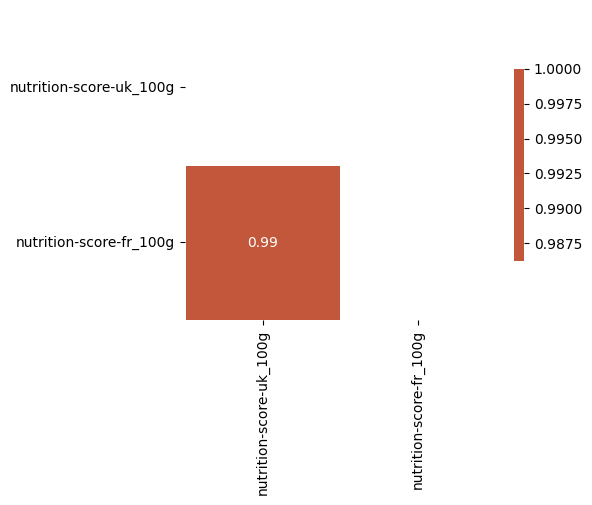

In [94]:
corr = data2[['nutrition-score-uk_100g','nutrition-score-fr_100g']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": 0.5});

On voit que ces 2 colonnes sont corrélée à 99%. On va donc ne garder que "nutrition-score-fr_100g"

In [95]:
print("nutrition-score-uk_100g")
print(data2['nutrition-score-uk_100g'].isnull().value_counts())
print("nutrition-score-fr_100g")
print(data2['nutrition-score-fr_100g'].isnull().value_counts())

nutrition-score-uk_100g
False    221233
True      99516
Name: nutrition-score-uk_100g, dtype: int64
nutrition-score-fr_100g
False    221233
True      99516
Name: nutrition-score-fr_100g, dtype: int64


In [96]:
data2_tmp=data2.loc[data2['nutrition-score-uk_100g'].notnull() & data2['nutrition-score-fr_100g'].isnull(),:]
data2_tmp.shape[0]

0

Il y a 107 valeurs de plus chez UK mais comme je ne connais pas leur système de notation, je ne vais pas prendre le risque d'utiliser ces notes pour compléter les notre en FR

In [97]:
#Supression de la colonne en trop
data2.drop(columns='nutrition-score-uk_100g', axis=1, inplace = True)

##### <a name="C332115">3.3.2.1.15 "salt_100g" et "sodium_100g" </a>

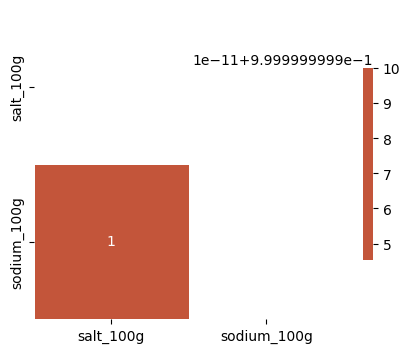

In [98]:
corr = data2[['salt_100g','sodium_100g']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": 0.5});

In [99]:
#Supression de la colonne en trop
data2.drop(columns='sodium_100g', axis=1, inplace = True)

#### <a name="C3322">3.3.2.2 Analyse des doublons sur les lignes</a>

In [100]:
tmp=data2.loc[data2[['code']].duplicated(keep=False),:]
tmp.shape[0]

222

On vois ici que 222 codes sont répétés. 

In [101]:
tmp.sort_values('code', ascending= False, inplace=True)
tmp.head()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1196\2712202931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values('code', ascending= False, inplace=True)


code                                                url  \
116492  5400141350470  http://world-fr.openfoodfacts.org/produit/0540...   
276796  5400141350470  http://world-fr.openfoodfacts.org/produit/5400...   
115938  4711567123489  http://world-fr.openfoodfacts.org/produit/0471...   
268042  4711567123489  http://world-fr.openfoodfacts.org/produit/4711...   
105704   876045004026  http://world-fr.openfoodfacts.org/produit/0087...   

                  creator           created_t     last_modified_t  \
116492             emerzh 2017-01-21 11:24:41 2017-01-21 11:40:04   
276796  gauthier-de-geest 2016-12-10 10:17:28 2017-01-29 21:09:58   
115938    usda-ndb-import 2017-03-10 10:47:45 2017-03-10 10:47:45   
268042    usda-ndb-import 2017-03-09 22:09:23 2017-03-09 22:09:23   
105704    usda-ndb-import 2017-03-09 12:21:49 2017-03-09 12:21:49   

                                       product_name generic_name quantity  \
116492                                Cereal flakes          NaN    500 g   
276796                 Cribbits Rice & Wheat Flakes          NaN      NaN   
115938  Dainty Food Co, Chili Sauce With Black Bean          NaN      NaN   
268042                  Chile Sauce With Black Bean          NaN      NaN   
105704                    Guy Fieri, Barbeque Sauce          NaN      NaN   

       packaging_tags                 brands_tags categories_fr origins_tags  \
116492            NaN                        boni           NaN          NaN   
276796            NaN                        boni           NaN          NaN   
115938            NaN  hawkhaven-greenhouse-int-l           NaN          NaN   
268042            NaN              dainty-food-co           NaN          NaN   
105704            NaN              gia-brands-inc           NaN          NaN   

       manufacturing_places_tags labels_fr emb_codes_tags  \
116492                       NaN       NaN            NaN   
276796                       NaN       NaN            NaN   
115938                       NaN       NaN            NaN   
268042                       NaN       NaN            NaN   
105704                       NaN       NaN            NaN   

       first_packaging_code_geo cities_tags purchase_places stores  \
116492                      NaN         NaN             NaN    NaN   
276796                      NaN         NaN             NaN    NaN   
115938                      NaN         NaN             NaN    NaN   
268042                      NaN         NaN             NaN    NaN   
105704                      NaN         NaN             NaN    NaN   

       countries_fr                                   ingredients_text  \
116492     Belgique  Céréales (63 % riz, 21 % BLE complet), sucre, ...   
276796       France                                                NaN   
115938   États-Unis  Fresh chili, si-chuan xanthoxy-lum, dark bean,...   
268042   États-Unis  Fresh chili, si-chuan xanthoxy-lum, dark bean,...   
105704   États-Unis  Tomato puree (water, tomato paste), sugar, vin...   

       allergens traces traces_tags traces_fr   serving_size  additives_n  \
116492       NaN    NaN         NaN       NaN            30g          1.0   
276796       NaN    NaN         NaN       NaN            NaN          NaN   
115938       NaN    NaN         NaN       NaN  20 g (1 Tbsp)          0.0   
268042       NaN    NaN         NaN       NaN  20 g (1 Tbsp)          0.0   
105704       NaN    NaN         NaN       NaN  28 g (2 Tbsp)          1.0   

                                                additives  \
116492   [ cereales -> en:cereales  ]  [ 63-riz -> en:...   
276796                                                NaN   
115938   [ fresh-chili -> en:fresh-chili  ]  [ chili -...   
268042   [ fresh-chili -> en:fresh-chili  ]  [ chili -...   
105704   [ tomato-puree -> en:tomato-puree  ]  [ puree...   

        ingredients_from_palm_oil_n ingredients_from_palm_oil_tags  \
116492                          0.0                            NaN  

In [102]:
tmp=data2.loc[data2[['code', 'product_name']].duplicated(keep=False),:]
tmp.shape[0]

34

Sur ces 222 répétitions, 34 correspondent au même produit (product name)

In [103]:
tmp=data2.loc[data2[['code', 'created_t']].duplicated(keep=False),:]
#tmp.sort_values('code', ascending= False, inplace=True)
tmp.shape[0]

0

Ces 222 répétitions n'ont pas été créées au même moment donc on considérera que le produit a juste été rentré plusieurs fois. On ne va donc pas supprimer les lignes car on pourrait retrouver des informations pertinentes dans l'une ou l'autre

#### <a name="C3323">3.3.2.3 Validation répétitions de la colonne **nutrition_grade_fr**  </a>

Cette colonne doit obligatoirement avoir des valeurs répétées comprise entre A et E. Vérifions cela : 

In [104]:
data2['nutrition_grade_fr'].unique()

array([nan, 'd', 'b', 'c', 'a', 'e'], dtype=object)

C'est bien le cas donc aucune modification de cette colonne est necessaire. Cependant, par souci de cohérence avec le "terrain", on affichera ces lettres en majuscule. Je vais donc les transformer

In [105]:
data2.loc[data2['nutrition_grade_fr']=='a', 'nutrition_grade_fr'] = 'A'
data2.loc[data2['nutrition_grade_fr']=='b', 'nutrition_grade_fr'] = 'B'
data2.loc[data2['nutrition_grade_fr']=='c', 'nutrition_grade_fr'] = 'C'
data2.loc[data2['nutrition_grade_fr']=='d', 'nutrition_grade_fr'] = 'D'
data2.loc[data2['nutrition_grade_fr']=='e', 'nutrition_grade_fr'] = 'E'

Je vais avoir besoin d'une équivalence de cette colonne en "float64" pour nos futurs analyses. Je vais donc l'inserer

In [106]:
code = {'A':0,'B':1,'C':2,'D':3,'E':4,}
data2['nutrition_grade_fr_2'] =data2['nutrition_grade_fr'].replace(code).astype(np.float64)
data2['nutrition_grade_fr_2'].unique()

array([nan,  3.,  1.,  2.,  0.,  4.])

### <a name="C333">3.3.3 Outliers </a>

In [107]:
data2.describe()

additives_n  ingredients_from_palm_oil_n  \
count  248961.000000                248961.000000   
mean        1.936384                     0.019658   
std         2.502319                     0.140518   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        31.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n   energy_100g  \
count                            248961.000000  2.611360e+05   
mean                                  0.055246  1.141842e+03   
std                                   0.269203  6.446875e+03   
min                                   0.000000  0.000000e+00   
25%                                   0.000000  3.770000e+02   
50%                                   0.000000  1.100000e+03   
75%                                   0.000000  1.674000e+03   
max                                   6.000000  3.251373e+06   

       energy-from-fat_100g       fat_100g  saturated-fat_100g  \
count            857.000000  243914.000000       229577.000000   
mean             585.501214      12.729373            5.129562   
std              712.809943      17.578229            8.013929   
min                0.000000       0.000000            0.000000   
25%               49.400000       0.000000            0.000000   
50%              300.000000       5.000000            1.790000   
75%              898.000000      20.000000            7.140000   
max             3830.000000     714.290000          550.000000   

       caprylic-acid_100g  capric-acid_100g  lauric-acid_100g  \
count                 1.0          2.000000          4.000000   
mean                  7.4          6.040000         36.136182   
std                   NaN          0.226274         24.101433   
min                   7.4          5.880000          0.044730   
25%                   7.4          5.960000         34.661183   
50%                   7.4          6.040000         47.600000   
75%                   7.4          6.120000         49.075000   
max                   7.4          6.200000         49.300000   

       myristic-acid_100g  palmitic-acid_100g  stearic-acid_100g  \
count                 1.0                 1.0                1.0   
mean                 18.9                 8.1                3.0   
std                   NaN                 NaN                NaN   
min                  18.9                 8.1                3.0   
25%                  18.9                 8.1                3.0   
50%                  18.9                 8.1                3.0   
75%                  18.9                 8.1                3.0   
max                  18.9                 8.1                3.0   

       arachidic-acid_100g  montanic-acid_100g  monounsaturated-fat_100g  \
count                1.000                 1.0              22823.000000   
mean                 0.064                61.0                 10.425055   
std                    NaN                 NaN                 17.076167   
min                  0.064                61.0                  0.000000   
25%                  0.064                61.0                  0.000000   
50%                  0.064                61.0                  4.000000   
75%                  0.064                61.0                 10.710000   
max                  0.064                61.0                557.140000   

       polyunsaturated-fat_100g  omega-3-fat_100g  alpha-linolenic-acid_100g  \
count              22859.000000        841.000000                 186.000000   
mean                   6.312493          3.182103                   2.250285   
std                   10.832591          5.607988                   7.971418   
min                    0.000000          0.000000                   0.000000   
25%                    0.000000          0.600000                   0.06875

#### <a name="C3151">3.1.5.1 Valeurs minimales et maximales sur les compositions à 100g </a>

Pour 100g de nourriture ou de boisson, un des composants peut seulement avoir une masse comprise entre 0g et 100g

##### <a name="C31521">3.1.5.1.1 Mise à jour des valeurs min </a>

On remarque dans le tableau que les colonnes suivantes contiennent des valeurs négatives : <br> **trans-fat_100g**<br> **sugars_100g**<br> **fiber_100g**<br> **proteins_100g**<br> **vitamin-a_100g**<br>**vitamin-c_100g**<br> **iron_100g**<br>**copper_100g**<br> **selenium_100g**<br> 

In [108]:
i=0

data2_tmp=data2.loc[data2['trans-fat_100g']<0,:]
print("trans-fat_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['sugars_100g']<0,:]
print("sugars_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['fiber_100g']<0,:]
print("fiber_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['proteins_100g']<0,:]
print("proteins_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['vitamin-a_100g']<0,:]
print("vitamin-a_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['vitamin-c_100g']<0,:]
print("vitamin-c_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['iron_100g']<0,:]
print("iron_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['copper_100g']<0,:]
print("copper_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['selenium_100g']<0,:]
print("selenium_100g : il y a", data2_tmp.shape[0], "valeurs inférieures à 0")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

print("BILAN : il y a" ,i, "lignes concernées. Ce qui représente:", (i/len(data2))*100, "% de notre jeu de données")


trans-fat_100g : il y a 4 valeurs inférieures à 0
Ce qui représente 0.0012470810509152017 % de notre jeu de données
-----------
sugars_100g : il y a 7 valeurs inférieures à 0
Ce qui représente 0.002182391839101603 % de notre jeu de données
-----------
fiber_100g : il y a 1 valeurs inférieures à 0
Ce qui représente 0.0003117702627288004 % de notre jeu de données
-----------
proteins_100g : il y a 3 valeurs inférieures à 0
Ce qui représente 0.0009353107881864012 % de notre jeu de données
-----------
vitamin-a_100g : il y a 1 valeurs inférieures à 0
Ce qui représente 0.0003117702627288004 % de notre jeu de données
-----------
vitamin-c_100g : il y a 1 valeurs inférieures à 0
Ce qui représente 0.0003117702627288004 % de notre jeu de données
-----------
iron_100g : il y a 1 valeurs inférieures à 0
Ce qui représente 0.0003117702627288004 % de notre jeu de données
-----------
copper_100g : il y a 1 valeurs inférieures à 0
Ce qui représente 0.0003117702627288004 % de notre jeu de données
-----

On remarque une faible quantité de valeurs concernées par ce cas. Nous allons passer ces valeurs à vide. En conséquence, la valeur du nutri-score (nutrition_grade_fr et nutrition-score-fr)peut varier pour chaque ligne concernées. Je vais donc mettre à vide les nutri-scores concernées (20 unités)

In [109]:
data2_tmp=data2.loc[data2['trans-fat_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'trans-fat_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - trans-fat_100g")

data2_tmp=data2.loc[data2['sugars_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'sugars_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, "  lignes mises à jour- sugars_100g")

data2_tmp=data2.loc[data2['fiber_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'fiber_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, "  lignes mises à jour - fiber_100g")

data2_tmp=data2.loc[data2['proteins_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'proteins_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, "  lignes mises à jour - proteins_100g")

data2_tmp=data2.loc[data2['vitamin-a_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'vitamin-a_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - vitamin-a_100g")

data2_tmp=data2.loc[data2['vitamin-c_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'vitamin-c_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - vitamin-c_100g")

data2_tmp=data2.loc[data2['iron_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'iron_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, "  lignes mises à jour - iron_100g")

data2_tmp=data2.loc[data2['copper_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'copper_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, "  lignes mises à jour - copper_100g")

data2_tmp=data2.loc[data2['selenium_100g']<0,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'selenium_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, "  lignes mises à jour - selenium_100g")

4  lignes mises à jour - trans-fat_100g
7   lignes mises à jour- sugars_100g
1   lignes mises à jour - fiber_100g
3   lignes mises à jour - proteins_100g
1  lignes mises à jour - vitamin-a_100g
1  lignes mises à jour - vitamin-c_100g
1   lignes mises à jour - iron_100g
1   lignes mises à jour - copper_100g
1   lignes mises à jour - selenium_100g


##### <a name="C31522">3.1.5.1.2 Mise à jour des valeurs max </a>

On remarque dans le tableau que les colonnes suivantes contiennent des valeurs supérieurs à 100g : <br> fat_100g<br> saturated-fat_100g<br> monounsaturated-fat_100g<br> trans-fat_100g<br> carbohydrates_100g<br> sugars_100g<br> fructose_100g<br> fiber_100g<br> proteins_100g<br> salt_100g<br> sodium_100g<br> vitamin-c_100g<br> vitamin-b1_100g<br> folates_100g<br> potassium_100g<br> calcium_100g<br> phosphorus_100g<br> magnesium_100g 

In [110]:
i=0;

data2_tmp=data2.loc[data2['fat_100g']>100,:]
print("fat_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['saturated-fat_100g']>100,:]
print("saturated-fat_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")


data2_tmp=data2.loc[data2['monounsaturated-fat_100g']>100,:]
print("monounsaturated-fat_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")


data2_tmp=data2.loc[data2['trans-fat_100g']>100,:]
print("trans-fat_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")


data2_tmp=data2.loc[data2['carbohydrates_100g']>100,:]
print("carbohydrates_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")


data2_tmp=data2.loc[data2['sugars_100g']>100,:]
print("sugars_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['fructose_100g']>100,:]
print("fructose_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
print("-----------")
i=i+data2_tmp.shape[0]

data2_tmp=data2.loc[data2['fiber_100g']>100,:]
print("fiber_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['proteins_100g']>100,:]
print("proteins_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['salt_100g']>100,:]
print("salt_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['vitamin-c_100g']>100,:]
print("vitamin-c_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['vitamin-b1_100g']>100,:]
print("vitamin-b1_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['folates_100g']>100,:]
print("folates_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['potassium_100g']>100,:]
print("potassium_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['calcium_100g']>100,:]
print("calcium_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['phosphorus_100g']>100,:]
print("phosphorus_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

data2_tmp=data2.loc[data2['magnesium_100g']>100,:]
print("magnesium_100g : il y a", data2_tmp.shape[0], "valeurs superieures à 100g")
print("Ce qui représente",(data2_tmp.shape[0]/len(data2))*100,"% de notre jeu de données")
i=i+data2_tmp.shape[0]
print("-----------")

print("BILAN : il y a" ,i, "lignes concernées. Ce qui représente:", (i/len(data2))*100, "% de notre jeu de données")



fat_100g : il y a 4 valeurs superieures à 100g
Ce qui représente 0.0012470810509152017 % de notre jeu de données
-----------
saturated-fat_100g : il y a 3 valeurs superieures à 100g
Ce qui représente 0.0009353107881864012 % de notre jeu de données
-----------
monounsaturated-fat_100g : il y a 1 valeurs superieures à 100g
Ce qui représente 0.0003117702627288004 % de notre jeu de données
-----------
trans-fat_100g : il y a 5 valeurs superieures à 100g
Ce qui représente 0.001558851313644002 % de notre jeu de données
-----------
carbohydrates_100g : il y a 19 valeurs superieures à 100g
Ce qui représente 0.005923634991847207 % de notre jeu de données
-----------
sugars_100g : il y a 12 valeurs superieures à 100g
Ce qui représente 0.003741243152745605 % de notre jeu de données
-----------
fructose_100g : il y a 1 valeurs superieures à 100g
Ce qui représente 0.0003117702627288004 % de notre jeu de données
-----------
fiber_100g : il y a 4 valeurs superieures à 100g
Ce qui représente 0.0012470

On remarque une faible quantité de valeurs concernées par ce cas. Nous allons passer ces valeurs à vide. En conséquence, la valeur du nutri-score (nutrition_grade_fr et nutrition-score-fr) peut varier pour chaque ligne concernée. Je vais donc mettre à vide les nuttriscores concernées

In [111]:

data2_tmp=data2.loc[data2['fat_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'fat_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - fat_100g")

data2_tmp=data2.loc[data2['saturated-fat_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'saturated-fat_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - saturated-fat_100g")


data2_tmp=data2.loc[data2['monounsaturated-fat_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'monounsaturated-fat_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - monounsaturated-fat_100g")


data2_tmp=data2.loc[data2['trans-fat_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'trans-fat_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour -trans-fat_100g'")

data2_tmp=data2.loc[data2['carbohydrates_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'carbohydrates_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - carbohydrates_100g")


data2_tmp=data2.loc[data2['sugars_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'sugars_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - sugars_100g")

data2_tmp=data2.loc[data2['fructose_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'fructose_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - fructose_100g")

data2_tmp=data2.loc[data2['fiber_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'fiber_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - fiber_100g")

data2_tmp=data2.loc[data2['proteins_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'proteins_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - proteins_100g")

data2_tmp=data2.loc[data2['salt_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'salt_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - salt_100g")

#data2_tmp=data2.loc[data2['sodium_100g']>100,:]
#i=0
#for index in data2_tmp.index:
#    data2.loc[index, 'sodium_100g']= np.nan
#    data2.loc[index, 'nutrition_grade_fr']= np.nan
#    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
#    i+=1
#print(i, " lignes mises à jour - sodium_100g")

data2_tmp=data2.loc[data2['vitamin-c_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'vitamin-c_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - vitamin-c_100g")

data2_tmp=data2.loc[data2['vitamin-b1_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'vitamin-b1_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour -vitamin-b1_100g")

data2_tmp=data2.loc[data2['folates_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'folates_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - folates_100g")

data2_tmp=data2.loc[data2['potassium_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'potassium_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - potassium_100g")

data2_tmp=data2.loc[data2['calcium_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'calcium_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - calcium_100g")

data2_tmp=data2.loc[data2['phosphorus_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'phosphorus_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - phosphorus_100g")

data2_tmp=data2.loc[data2['magnesium_100g']>100,:]
i=0
for index in data2_tmp.index:
    data2.loc[index, 'magnesium_100g']= np.nan
    data2.loc[index, 'nutrition_grade_fr']= np.nan
    data2.loc[index, 'nutrition-score-fr_100g']= np.nan
    i+=1
print(i, " lignes mises à jour - magnesium_100g")


4  lignes mises à jour - fat_100g
3  lignes mises à jour - saturated-fat_100g
1  lignes mises à jour - monounsaturated-fat_100g
5  lignes mises à jour -trans-fat_100g'
19  lignes mises à jour - carbohydrates_100g
12  lignes mises à jour - sugars_100g
1  lignes mises à jour - fructose_100g
4  lignes mises à jour - fiber_100g
1  lignes mises à jour - proteins_100g
158  lignes mises à jour - salt_100g
3  lignes mises à jour - vitamin-c_100g
1  lignes mises à jour -vitamin-b1_100g
3  lignes mises à jour - folates_100g
2  lignes mises à jour - potassium_100g
10  lignes mises à jour - calcium_100g
5  lignes mises à jour - phosphorus_100g
6  lignes mises à jour - magnesium_100g


In [112]:
data2.describe()

additives_n  ingredients_from_palm_oil_n  \
count  248961.000000                248961.000000   
mean        1.936384                     0.019658   
std         2.502319                     0.140518   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        31.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n   energy_100g  \
count                            248961.000000  2.611360e+05   
mean                                  0.055246  1.141842e+03   
std                                   0.269203  6.446875e+03   
min                                   0.000000  0.000000e+00   
25%                                   0.000000  3.770000e+02   
50%                                   0.000000  1.100000e+03   
75%                                   0.000000  1.674000e+03   
max                                   6.000000  3.251373e+06   

       energy-from-fat_100g       fat_100g  saturated-fat_100g  \
count            857.000000  243910.000000       229574.000000   
mean             585.501214      12.724251            5.125554   
std              712.809943      17.503182            7.913381   
min                0.000000       0.000000            0.000000   
25%               49.400000       0.000000            0.000000   
50%              300.000000       5.000000            1.790000   
75%              898.000000      20.000000            7.140000   
max             3830.000000     100.000000          100.000000   

       caprylic-acid_100g  capric-acid_100g  lauric-acid_100g  \
count                 1.0          2.000000          4.000000   
mean                  7.4          6.040000         36.136182   
std                   NaN          0.226274         24.101433   
min                   7.4          5.880000          0.044730   
25%                   7.4          5.960000         34.661183   
50%                   7.4          6.040000         47.600000   
75%                   7.4          6.120000         49.075000   
max                   7.4          6.200000         49.300000   

       myristic-acid_100g  palmitic-acid_100g  stearic-acid_100g  \
count                 1.0                 1.0                1.0   
mean                 18.9                 8.1                3.0   
std                   NaN                 NaN                NaN   
min                  18.9                 8.1                3.0   
25%                  18.9                 8.1                3.0   
50%                  18.9                 8.1                3.0   
75%                  18.9                 8.1                3.0   
max                  18.9                 8.1                3.0   

       arachidic-acid_100g  montanic-acid_100g  monounsaturated-fat_100g  \
count                1.000                 1.0              22822.000000   
mean                 0.064                61.0                 10.401099   
std                    NaN                 NaN                 16.688625   
min                  0.064                61.0                  0.000000   
25%                  0.064                61.0                  0.000000   
50%                  0.064                61.0                  4.000000   
75%                  0.064                61.0                 10.710000   
max                  0.064                61.0                100.000000   

       polyunsaturated-fat_100g  omega-3-fat_100g  alpha-linolenic-acid_100g  \
count              22859.000000        841.000000                 186.000000   
mean                   6.312493          3.182103                   2.250285   
std                   10.832591          5.607988                   7.971418   
min                    0.000000          0.000000                   0.000000   
25%                    0.000000          0.600000                   0.06875

#### <a name="C3152">3.1.5.2 Notation </a>

In [113]:
nut_min = data2['nutrition-score-fr_100g'].loc[data2['nutrition-score-fr_100g'].idxmin()]      
print("nutrition-score-fr_100g min : ", nut_min)
nut_max = data2['nutrition-score-fr_100g'].loc[data2['nutrition-score-fr_100g'].idxmax()]      
print("nutrition-score-fr_100g max :", nut_max)

nutrition-score-fr_100g min :  -15.0
nutrition-score-fr_100g max : 40.0


<AxesSubplot: xlabel='nutrition-score-fr_100g'>

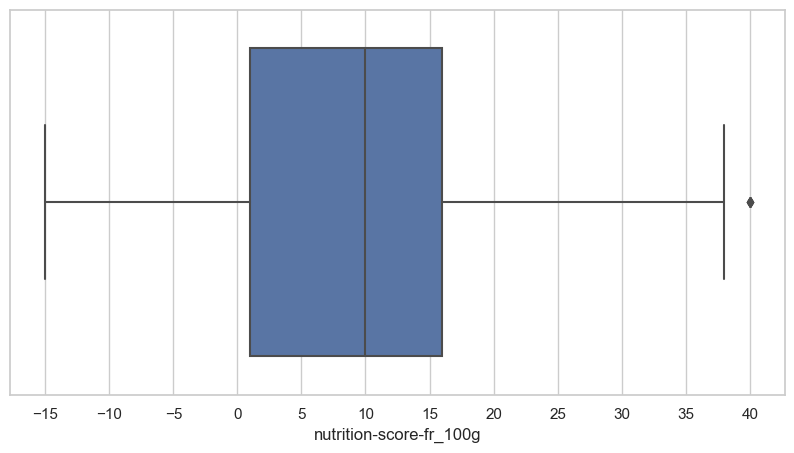

In [114]:
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
plt.xticks([-15, -10,-5,0,5,10,15,20,25,30.,35,40])
sns.boxplot( x="nutrition-score-fr_100g", data=data2)


#### <a name="C3153">3.1.5.3 energy_100g </a>

In [115]:
ener_min = data2['energy_100g'].loc[data2['energy_100g'].idxmin()]      
print("energy_100g min : ", ener_min)
ener_max = data2['energy_100g'].loc[data2['energy_100g'].idxmax()]      
print("energy_100g max :", ener_max)

energy_100g min :  0.0
energy_100g max : 3251373.0


<AxesSubplot: xlabel='energy_100g'>

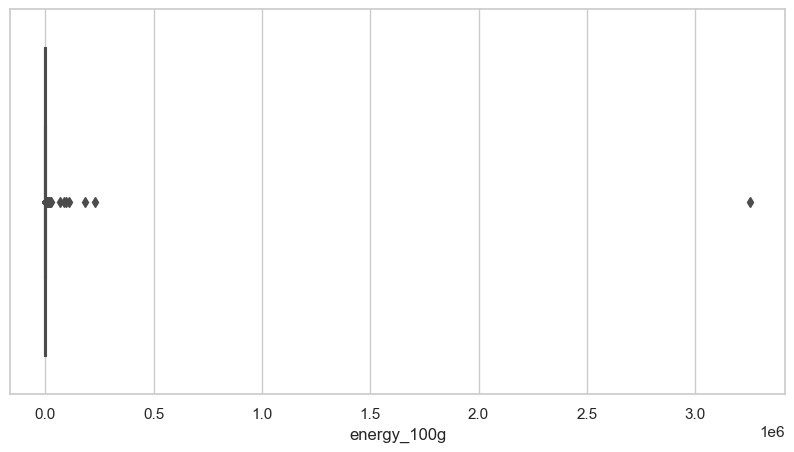

In [116]:
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
sns.boxplot( x="energy_100g", data=data2)

In [117]:
data2['energy_100g'].describe()

count    2.611360e+05
mean     1.141842e+03
std      6.446875e+03
min      0.000000e+00
25%      3.770000e+02
50%      1.100000e+03
75%      1.674000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

In [118]:
df_tmp=data2.loc[data2['energy_100g']>4000,:]
print(df_tmp.shape[0])
print(df_tmp.shape[0]/data2.shape[0])

154
0.00048012620460235263


J'ai 154 valeurs au dessus de 4000, je les passe à 4000 (0.04%)

In [119]:
data2.loc[data2['energy_100g']>4000,'energy_100g']=4000

<AxesSubplot: xlabel='energy_100g'>

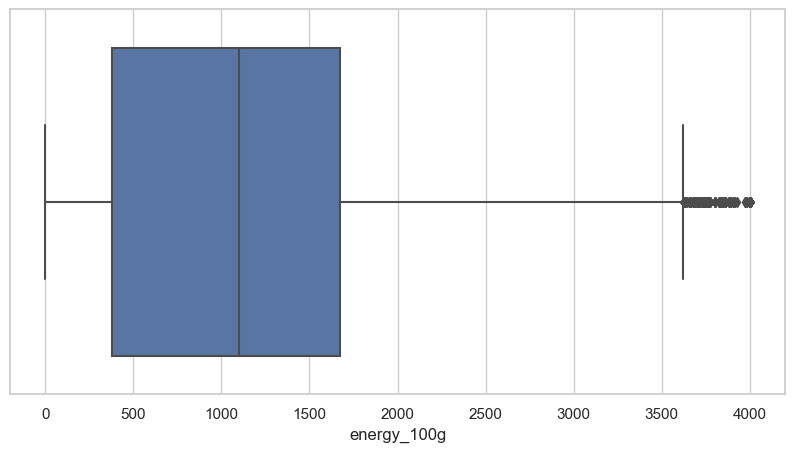

In [120]:
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
sns.boxplot( x="energy_100g", data=data2)

In [121]:
df_tmp=data2.loc[data2['energy_100g']==0,:]
print(df_tmp.shape[0])
print(df_tmp.shape[0]/data2.shape[0])

8909
0.02777561270650883


## <a name="C34">3.4 Bilan</a>

In [122]:
data2.shape

(320749, 122)

In [123]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Columns: 122 entries, code to nutrition_grade_fr_2
dtypes: datetime64[ns](2), float64(86), object(34)
memory usage: 298.5+ MB


In [124]:
data2.describe()

additives_n  ingredients_from_palm_oil_n  \
count  248961.000000                248961.000000   
mean        1.936384                     0.019658   
std         2.502319                     0.140518   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        31.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n    energy_100g  \
count                            248961.000000  261136.000000   
mean                                  0.055246    1125.315362   
std                                   0.269203     798.762772   
min                                   0.000000       0.000000   
25%                                   0.000000     377.000000   
50%                                   0.000000    1100.000000   
75%                                   0.000000    1674.000000   
max                                   6.000000    4000.000000   

       energy-from-fat_100g       fat_100g  saturated-fat_100g  \
count            857.000000  243910.000000       229574.000000   
mean             585.501214      12.724251            5.125554   
std              712.809943      17.503182            7.913381   
min                0.000000       0.000000            0.000000   
25%               49.400000       0.000000            0.000000   
50%              300.000000       5.000000            1.790000   
75%              898.000000      20.000000            7.140000   
max             3830.000000     100.000000          100.000000   

       caprylic-acid_100g  capric-acid_100g  lauric-acid_100g  \
count                 1.0          2.000000          4.000000   
mean                  7.4          6.040000         36.136182   
std                   NaN          0.226274         24.101433   
min                   7.4          5.880000          0.044730   
25%                   7.4          5.960000         34.661183   
50%                   7.4          6.040000         47.600000   
75%                   7.4          6.120000         49.075000   
max                   7.4          6.200000         49.300000   

       myristic-acid_100g  palmitic-acid_100g  stearic-acid_100g  \
count                 1.0                 1.0                1.0   
mean                 18.9                 8.1                3.0   
std                   NaN                 NaN                NaN   
min                  18.9                 8.1                3.0   
25%                  18.9                 8.1                3.0   
50%                  18.9                 8.1                3.0   
75%                  18.9                 8.1                3.0   
max                  18.9                 8.1                3.0   

       arachidic-acid_100g  montanic-acid_100g  monounsaturated-fat_100g  \
count                1.000                 1.0              22822.000000   
mean                 0.064                61.0                 10.401099   
std                    NaN                 NaN                 16.688625   
min                  0.064                61.0                  0.000000   
25%                  0.064                61.0                  0.000000   
50%                  0.064                61.0                  4.000000   
75%                  0.064                61.0                 10.710000   
max                  0.064                61.0                100.000000   

       polyunsaturated-fat_100g  omega-3-fat_100g  alpha-linolenic-acid_100g  \
count              22859.000000        841.000000                 186.000000   
mean                   6.312493          3.182103                   2.250285   
std                   10.832591          5.607988                   7.971418   
min                    0.000000          0.000000                   0.000000   
25%                    0.000000          0.600000                 

In [125]:
#Affichage des colonnes n'ayant pas de manquants
nb_na = data2.isnull().sum() 
nb_na=nb_na[nb_na==0]
nb_na

code               0
url                0
last_modified_t    0
states_fr          0
dtype: int64

De manière globale le jeu de donnée n’est pas complet mais les informations présentes sont maintenant exploitables

# 4 Analyses

## <a name="C41">4.1 Identification des variables pertinentes (analyses multivariées) </a>

L’objectif est de trouver un lien entre les variables constituant les aliments et les 2 targets illustrant la qualité nutritive des produits. Par conséquent, je vais mettre de coté toutes les lignes qui ne contiennent pas la valeur du nutri-score et ne garder que celle qui la contiennent dans une nouvelle dataframe : data3.  6 nouvelles colonnes vides vont apparaitre. je les supprime de data3.<br>
En conséquence la colonne "nutrition-grade-fr" est également 100% "non vide" (les vides dans les 2 colonnes sont alignés)<br>

In [126]:
df_tmp=data2.loc[data2['nutrition-score-fr_100g'].isnull(),:].copy()
print("Nutrition score vide =",df_tmp.shape[0],"soit", ((df_tmp.shape[0]*100)/data2.shape[0]),"%")

Nutrition score vide = 99623 soit 31.059488883831282 %


In [127]:
data3=data2.loc[data2['nutrition-score-fr_100g'].notnull(),:].copy()

In [128]:
#Suppression des colonnes vides 
data3=supprimer_colonnes_vides(data3)

Liste des 6 colonnes vides et nombre de lignes vides par colonnes sur un dataframe de 221126 lignes :
caprylic-acid_100g    221126
capric-acid_100g      221126
myristic-acid_100g    221126
palmitic-acid_100g    221126
stearic-acid_100g     221126
montanic-acid_100g    221126
dtype: int64
Les 6 colonnes ont étés supprimées du DataFrame envoyé à la fonction


Aussi, je sais que "saturated-fat" est contenu dans "fat" et que "sugars" est contenu dans "carbohydrates". Je ne peux pas donc pas remplacer les nulls par 0. Etant donné leur faibles nombres, je vais enlever les lignes concernées de data3<br>

In [129]:
df_tmp=data3.loc[data3['fat_100g'].isnull(),:].copy()
print("fat_100g vide =",df_tmp.shape[0],"soit", ((df_tmp.shape[0]*100)/data3.shape[0]),"%")
df_tmp=data3.loc[data3['saturated-fat_100g'].isnull(),:].copy()
print("saturated-fat_100g vide =",df_tmp.shape[0],"soit", ((df_tmp.shape[0]*100)/data3.shape[0]),"%")
df_tmp=data3.loc[data3['carbohydrates_100g'].isnull(),:].copy()
print("carbohydrates_100g vide =",df_tmp.shape[0],"soit", ((df_tmp.shape[0]*100)/data3.shape[0]),"%")
df_tmp=data3.loc[data3['sugars_100g'].isnull(),:].copy()
print("sugars_100g vide =",df_tmp.shape[0],"soit", ((df_tmp.shape[0]*100)/data3.shape[0]),"%")

fat_100g vide = 17475 soit 7.902734187748162 %
saturated-fat_100g vide = 191 soit 0.0863760932680915 %
carbohydrates_100g vide = 17501 soit 7.914492189973138 %
sugars_100g vide = 191 soit 0.0863760932680915 %


In [130]:
data3=data3.loc[data3['fat_100g'].notnull(),:].copy()
data3=data3.loc[data3['saturated-fat_100g'].notnull(),:].copy()
data3=data3.loc[data3['carbohydrates_100g'].notnull(),:].copy()
data3=data3.loc[data3['sugars_100g'].notnull(),:].copy()

In [131]:
print("En enlevant toutes les lignes concernées, il y a eu", len(data2)-len(data3), "lignes supprimées, soit", ((len(data2)-len(data3))*100)/len(data2),"%")
print("Il reste", len(data3)," lignes")

En enlevant toutes les lignes concernées, il y a eu 117357 lignes supprimées, soit 36.58842272306383 %
Il reste 203392  lignes


In [132]:
data3=supprimer_colonnes_vides(data3)

Liste des 0 colonnes vides et nombre de lignes vides par colonnes sur un dataframe de 203392 lignes :
Series([], dtype: int64)
Les 0 colonnes ont étés supprimées du DataFrame envoyé à la fonction


In [133]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203392 entries, 1 to 320745
Columns: 116 entries, code to nutrition_grade_fr_2
dtypes: datetime64[ns](2), float64(80), object(34)
memory usage: 181.6+ MB


In [134]:
#Affichage des colonnes ayant des manquants + quantité des manquants
nb_na = data3.isnull().sum() 
nb_na=nb_na[nb_na>0]

#Création d'un dataframe avec les manquants
df_miss=pd.DataFrame(nb_na).reset_index()
df_miss.columns=['colonne','quantite_manquante']
df_miss.sort_values('quantite_manquante', ascending= False, inplace=True)

#Ajout du % de manquants
df_miss['% manquant'] = round((df_miss['quantite_manquante']/data3.shape[0])*100,4)
df_miss.reset_index(drop=True)

colonne  quantite_manquante  \
0                           arachidic-acid_100g              203391   
1                                       ph_100g              203391   
2                     gamma-linolenic-acid_100g              203391   
3                                  maltose_100g              203390   
4                              lauric-acid_100g              203390   
5                                   silica_100g              203386   
6                               molybdenum_100g              203385   
7                              nucleotides_100g              203384   
8                         arachidonic-acid_100g              203384   
9                               oleic-acid_100g              203384   
10                           maltodextrins_100g              203383   
11                                 glucose_100g              203377   
12                                 sucrose_100g              203377   
13                             bicarbonate_100g              203376   
14                          serum-proteins_100g              203376   
15                                chromium_100g              203376   
16                             omega-9-fat_100g              203373   
17                                fructose_100g              203369   
18                           beta-carotene_100g              203368   
19                                  casein_100g              203368   
20                                 taurine_100g              203365   
21                   eicosapentaenoic-acid_100g              203365   
22                                fluoride_100g              203346   
23                    docosahexaenoic-acid_100g              203344   
24                                caffeine_100g              203337   
25                                chloride_100g              203330   
26             collagen-meat-protein-ratio_100g              203293   
27                           linoleic-acid_100g              203254   
28                             omega-6-fat_100g              203244   
29                    alpha-linolenic-acid_100g              203218   
30                                 lactose_100g              203175   
31                        carbon-footprint_100g              203166   
32                                  iodine_100g              203163   
33                                  starch_100g              203141   
34                                  biotin_100g              203115   
35                                 polyols_100g              203001   
36                             omega-3-fat_100g              202650   
37                         energy-from-fat_100g              202618   
38                                   cocoa_100g              202550   
39                               vitamin-k_100g              202523   
40                                selenium_100g              202450   
41                               vitamin-e_100g              202198   
42                               manganese_100g              201888   
43                                 alcohol_100g              201855   
44                        pantothenic-acid_100g              201652   
45                                  copper_100g              201383   
46                                 folates_100g              200630   
47                  fruits-vegetables-nuts_100g              200613   
48                                    zinc_100g              199892   
49                             vitamin-b12_100g              199339   
50               ingredients_from_palm_oil_tags              199196   
51                              vitamin-b9_100g              198399   
52                               magnesium_100g              198053   
53                              phosphorus_100g              198033   
54                              vitamin-b6_100g              197965   
55                               vitamin-d_100g              197

### <a name="C411">4.4.1 Variables catégorielles </a>

In [135]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Columns: 122 entries, code to nutrition_grade_fr_2
dtypes: datetime64[ns](2), float64(86), object(34)
memory usage: 298.5+ MB


Nous avons 34 variables "objet" que l'on va considérer comme catégorielle

colonne  quantite_manquante  taux_manquant  taux_remplissage  \
0                 code                   0         0.0000          100.0000   
1            states_fr                   0         0.0000          100.0000   
2   nutrition_grade_fr                   0         0.0000          100.0000   
3              creator                   0         0.0000          100.0000   
4                  url                   0         0.0000          100.0000   
5         countries_fr                  57         0.0280           99.9720   
6         product_name                2714         1.3344           98.6656   
7          brands_tags                4610         2.2666           97.7334   
8     ingredients_text                8540         4.1988           95.8012   
9            additives                8560         4.2086           95.7914   
10        serving_size               29672        14.5886           85.4114   

      type  
0   object  
1   object  
2   object  
3   object  
4   object  
5   object  
6   object  
7   object  
8   object  
9   object  
10  object

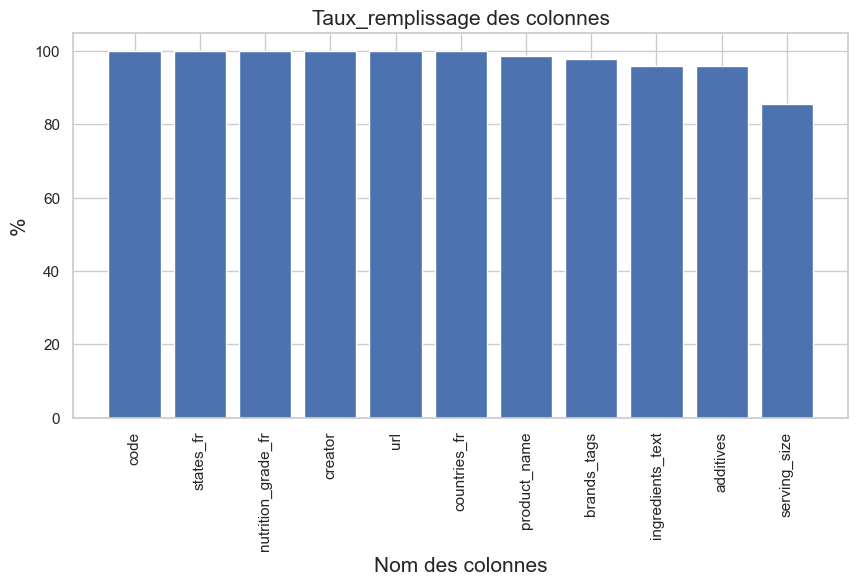

In [136]:
df_list_cat=correlation_cat(78,data3)

In [137]:
df_list_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203392 entries, 1 to 320745
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   code                     203392 non-null  object 
 1   states_fr                203392 non-null  object 
 2   nutrition_grade_fr       203392 non-null  object 
 3   creator                  203392 non-null  object 
 4   url                      203392 non-null  object 
 5   countries_fr             203335 non-null  object 
 6   product_name             200678 non-null  object 
 7   brands_tags              198782 non-null  object 
 8   ingredients_text         194852 non-null  object 
 9   additives                194832 non-null  object 
 10  serving_size             173720 non-null  object 
 11  nutrition-score-fr_100g  203392 non-null  float64
dtypes: float64(1), object(11)
memory usage: 20.2+ MB


#### <a name="C4111">4.1.2.1 Attribution du "nutrition_grade_fr" au "nutrition-score-fr_100g </a>

In [138]:
#Calcul du rapport de corrélation
eta_squared(df_list_cat['nutrition-score-fr_100g'],df_list_cat['nutrition_grade_fr'])

0.9312555944738357

Le rapport de corrélation entre les 2 variables est de 93%. Vérifions l'attribution de la lettre au score : 

<AxesSubplot: title={'center': "'nutrition-score-fr_100g' vs 'nutrition_grade_fr'"}, xlabel='nutrition-score-fr_100g', ylabel='nutrition_grade_fr'>

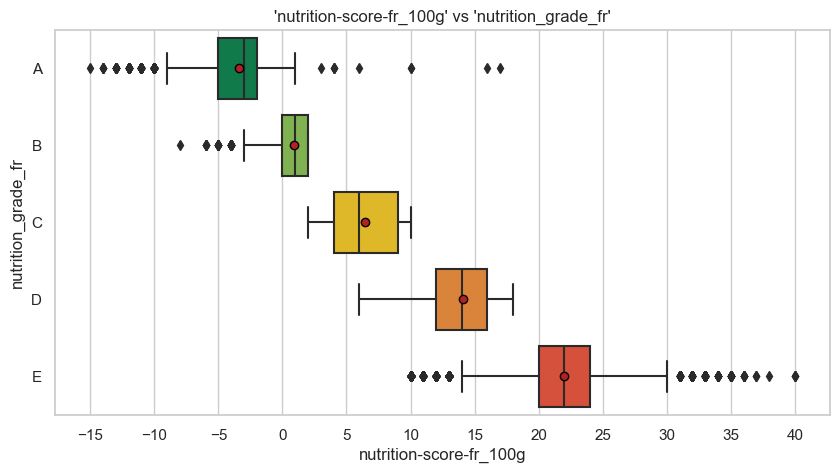

In [139]:
order = ['A', 'B', 'C', 'D', 'E']
plt.figure(figsize=(10, 5))
plt.title("'nutrition-score-fr_100g' vs 'nutrition_grade_fr'")
sns.set(style="whitegrid")
plt.xticks([-15, -10,-5,0,5,10,15,20,25,30.,35,40])
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
sns.boxplot(x='nutrition-score-fr_100g', y='nutrition_grade_fr', data=df_list_cat, order = order,meanprops=meanprops, showmeans=True,palette=sns.blend_palette(['#008B4C', '#7FC241' ,'#FECA0A', '#F58220','#EF3E22'],5))


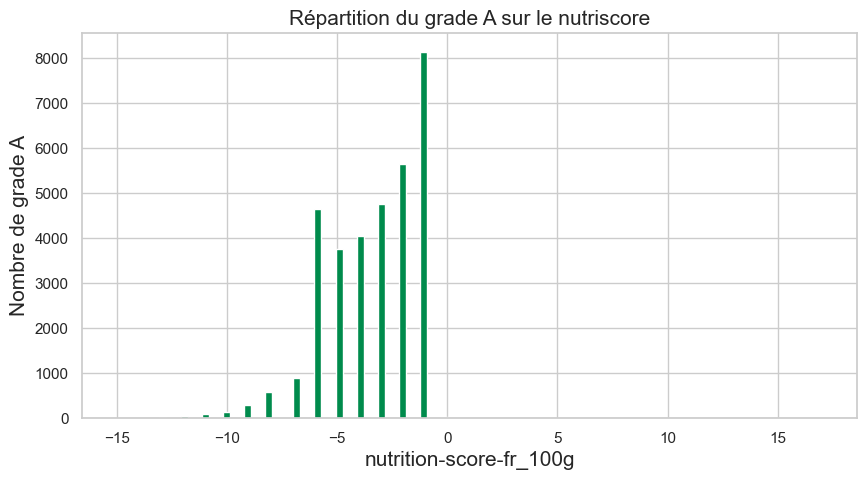

In [140]:
#Histogramme lettre A
df_tmp=data3.loc[data3['nutrition_grade_fr']=="A"]
plt.figure(figsize=(10,5))
plt.hist(df_tmp['nutrition-score-fr_100g'], bins=100, color='#008B4C')
plt.title("Répartition du grade A sur le nutriscore", fontsize=15)
plt.ylabel("Nombre de grade A", fontsize=15) 
plt.xlabel("nutrition-score-fr_100g", fontsize=15) 
plt.show()

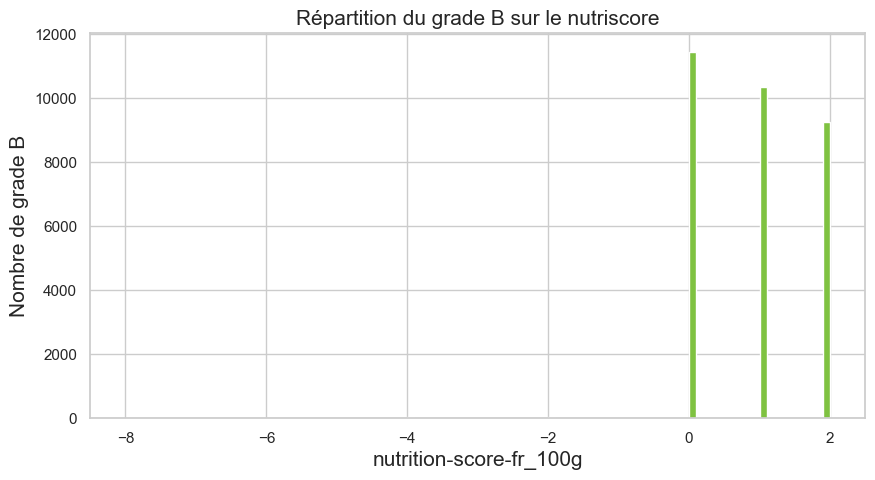

In [141]:
#Histogramme lettre B
df_tmp=data3.loc[data3['nutrition_grade_fr']=="B"]
plt.figure(figsize=(10,5))
plt.hist(df_tmp['nutrition-score-fr_100g'], bins=100, color='#7FC241')
plt.title("Répartition du grade B sur le nutriscore", fontsize=15)
plt.ylabel("Nombre de grade B", fontsize=15) 
plt.xlabel("nutrition-score-fr_100g", fontsize=15) 
plt.show()

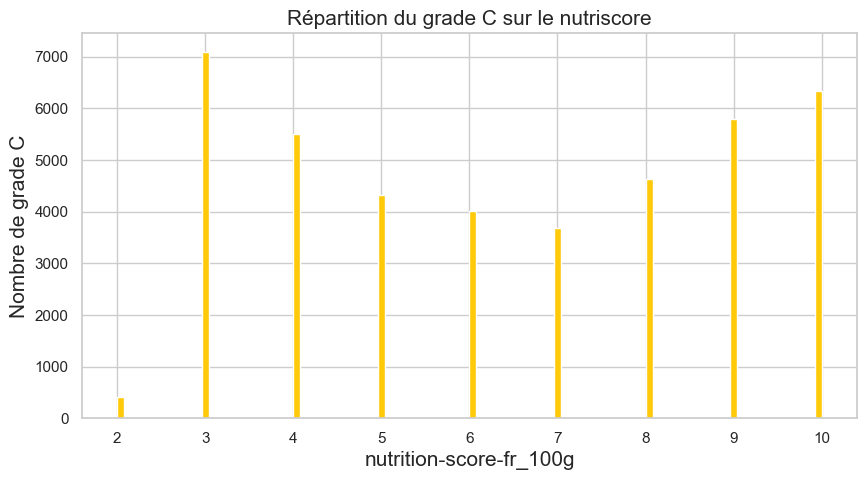

In [142]:
#Histogramme lettre C
df_tmp=data3.loc[data3['nutrition_grade_fr']=="C"]
plt.figure(figsize=(10,5))
plt.hist(df_tmp['nutrition-score-fr_100g'], bins=100, color='#FECA0A')
plt.title("Répartition du grade C sur le nutriscore", fontsize=15)
plt.ylabel("Nombre de grade C", fontsize=15) 
plt.xlabel("nutrition-score-fr_100g", fontsize=15) 
plt.show()

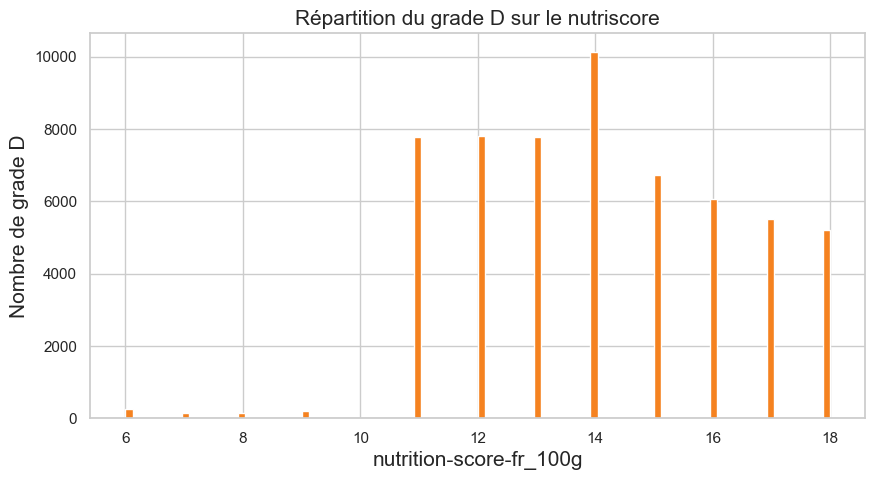

In [143]:
#Histogramme lettre D
df_tmp=data3.loc[data3['nutrition_grade_fr']=="D"]
plt.figure(figsize=(10,5))
plt.hist(df_tmp['nutrition-score-fr_100g'], bins=100, color='#F58220')
plt.title("Répartition du grade D sur le nutriscore", fontsize=15)
plt.ylabel("Nombre de grade D", fontsize=15) 
plt.xlabel("nutrition-score-fr_100g", fontsize=15) 
plt.show()

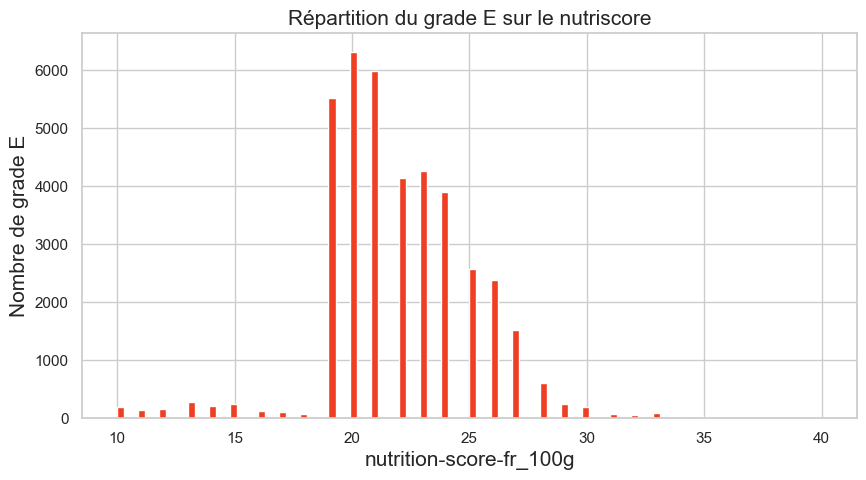

In [144]:
#Histogramme lettre E
df_tmp=data3.loc[data3['nutrition_grade_fr']=="E"]
plt.figure(figsize=(10,5))
plt.hist(df_tmp['nutrition-score-fr_100g'], bins=100, color='#EF3E22')
plt.title("Répartition du grade E sur le nutriscore", fontsize=15)
plt.ylabel("Nombre de grade E", fontsize=15) 
plt.xlabel("nutrition-score-fr_100g", fontsize=15) 
plt.show()

Certaines affectations sont à revoir mais ce n’est pas impactant pour la suite de notre analyse puisque seul nutrition-score-fr_100g est pris en compte


#### <a name="C4112">4.1.1.2 Autres rapport de corrélations </a>

In [145]:
eta_squared(df_list_cat['nutrition-score-fr_100g'],df_list_cat['creator'])


0.02579558477626235

In [146]:
eta_squared(df_list_cat['nutrition-score-fr_100g'],df_list_cat['countries_fr'])

nan

### <a name="C412">4.1.2 Variables numériques </a>

#### <a name="C4121">4.1.2.1 Corrélations </a>

In [147]:
#Affichage des colonnes n'ayant pas de manquants
nb_na = data3.isnull().sum() 
nb_na=nb_na[nb_na==0]
nb_na

code                       0
url                        0
creator                    0
last_modified_t            0
nutrition_grade_fr         0
states_fr                  0
energy_100g                0
fat_100g                   0
saturated-fat_100g         0
carbohydrates_100g         0
sugars_100g                0
proteins_100g              0
salt_100g                  0
nutrition-score-fr_100g    0
nutrition_grade_fr_2       0
dtype: int64

In [148]:
nb_na = data3.isnull().sum() 
nb_na=nb_na[nb_na>0]
nb_na

created_t                                          1
product_name                                    2714
generic_name                                  165214
quantity                                      144996
packaging_tags                                150826
brands_tags                                     4610
categories_fr                                 148662
origins_tags                                  190119
manufacturing_places_tags                     177590
labels_fr                                     172814
emb_codes_tags                                181743
first_packaging_code_geo                      189039
cities_tags                                   187907
purchase_places                               162568
stores                                        165660
countries_fr                                      57
ingredients_text                                8540
allergens                                     179344
traces                                        

Dans un premier temps, affichons les colonnes remplies à plus de 1,2%  pour avoir une vision d’ensemble.

colonne  quantite_manquante  \
0                                 salt_100g                   0   
1                             proteins_100g                   0   
2                               sugars_100g                   0   
3                        carbohydrates_100g                   0   
4                   nutrition-score-fr_100g                   0   
5                        saturated-fat_100g                   0   
6                                  fat_100g                   0   
7                               energy_100g                   0   
8                      nutrition_grade_fr_2                   0   
9   ingredients_that_may_be_from_palm_oil_n                8540   
10              ingredients_from_palm_oil_n                8540   
11                              additives_n                8540   
12                               fiber_100g               27183   
13                         cholesterol_100g               66506   
14                           trans-fat_100g               68235   
15                             calcium_100g               68292   
16                                iron_100g               69042   
17                           vitamin-c_100g               70700   
18                           vitamin-a_100g               71577   
19                           potassium_100g              181838   
20                 polyunsaturated-fat_100g              183286   
21                 monounsaturated-fat_100g              183313   
22                          vitamin-b1_100g              193035   
23                          vitamin-pp_100g              193101   
24                          vitamin-b2_100g              193204   
25                           vitamin-d_100g              197023   
26                          vitamin-b6_100g              197965   
27                          phosphorus_100g              198033   
28                           magnesium_100g              198053   
29                          vitamin-b9_100g              198399   
30                         vitamin-b12_100g              199339   
31                                zinc_100g              199892   
32              fruits-vegetables-nuts_100g              200613   
33                             folates_100g              200630   

    taux_manquant  taux_remplissage     type  
0          0.0000          100.0000  float64  
1          0.0000          100.0000  float64  
2          0.0000          100.0000  float64  
3          0.0000          100.0000  float64  
4          0.0000          100.0000  float64  
5          0.0000          100.0000  float64  
6          0.0000          100.0000  float64  
7          0.0000          100.0000  float64  
8          0.0000          100.0000  float64  
9          4.1988           95.8012  float64  
10         4.1988           95.8012  float64  
11         4.1988           95.8012  float64  
12        13.3648           86.6352  float64  
13        32.6984           67.3016  float64  
14        33.5485           66.4515  float64  
15        33.5765           66.4235  float64  
16        33.9453           66.0547  float64  
17        34.7605           65.2395  float64  
18        35.1916           64.8084  float64  
19        89.4027           10.5973  float64  
20        90.1147            9.8853  float64  
21        90.1279            9.8721  float64  
22        94.9079            5.0921  float64  
23        94.9403            5.0597  float64  
24        94.9910            5.0090  float64  
25        96.8686            3.1314  float64  
26        97.3318            2.6682  float64  
27        97.3652            2.6348  float64  
28        97.3750            2.6250  float64  
29        97.5451            2.4549  float64  
30        98.0073            1.9927  float64  
31        98.2792            1.7208  float64  
32        98.6337            1.3663  float64  
33        98.6420            1.3580  float64

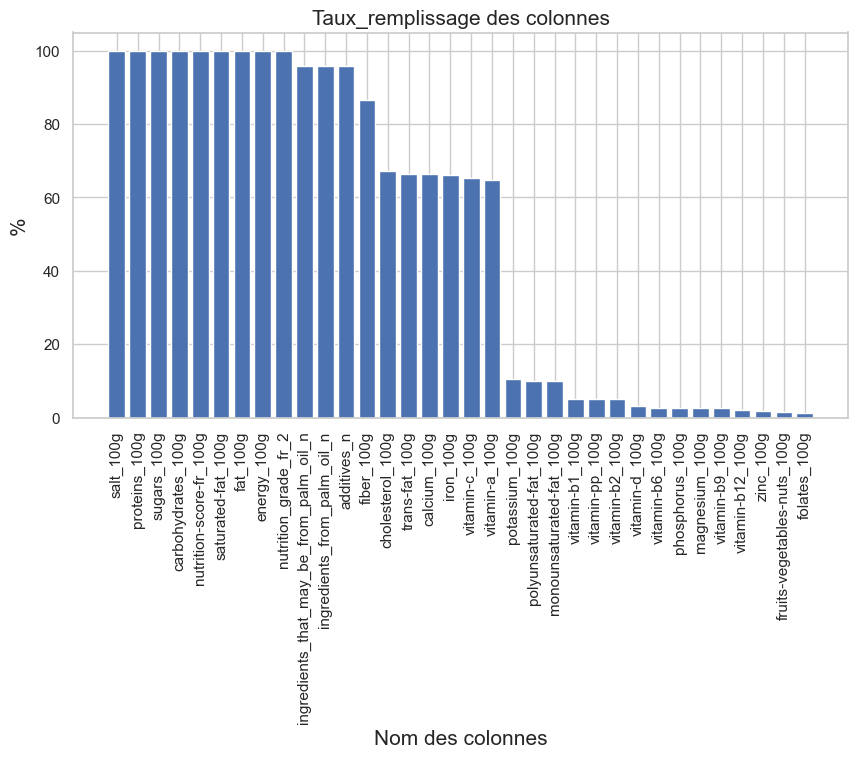

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1196\2654442815.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list_num.fillna(0, inplace=True)# le nutriscore n'est pas impacté car toutes les 2 colonnes (nutrition-score-fr_100g et nutrition_grade_fr_2)  sont remplies dans data3


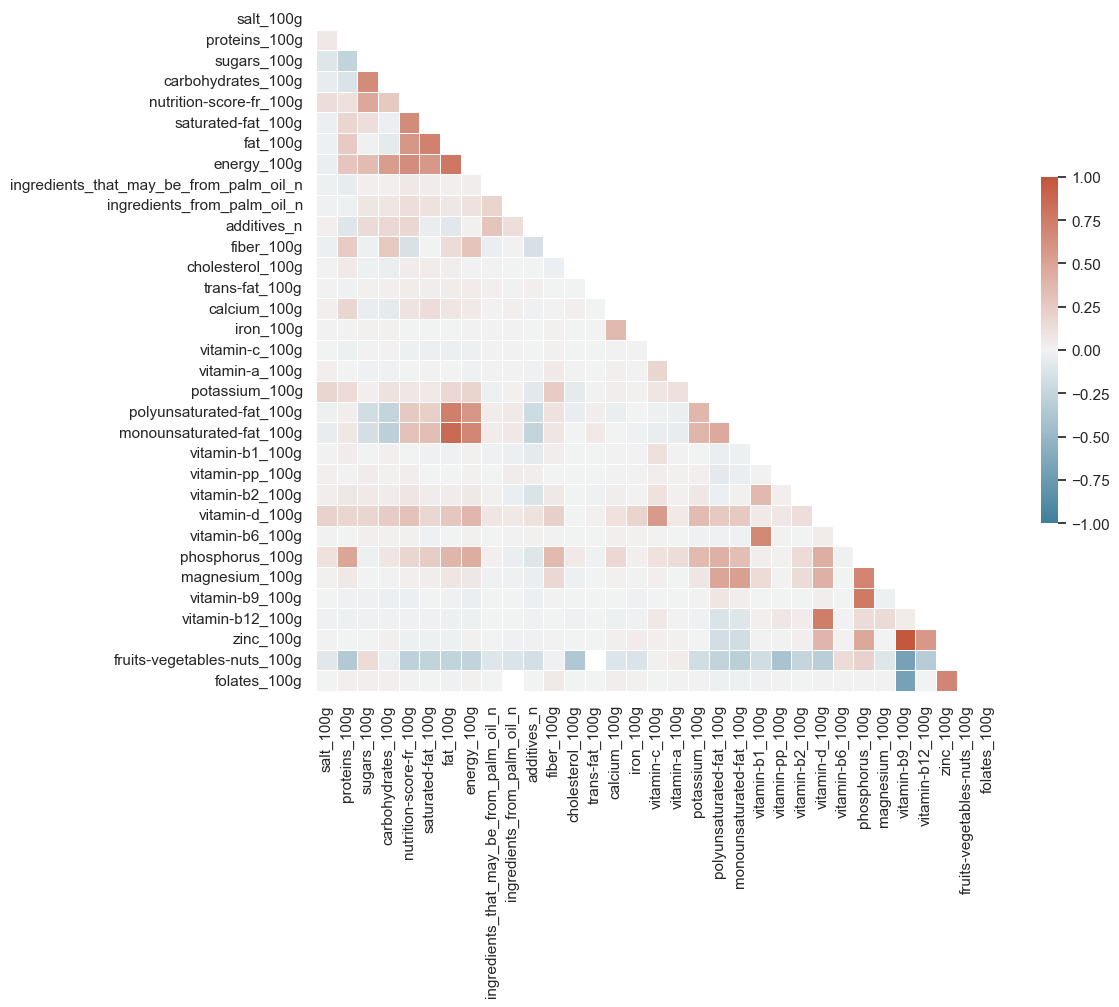

In [149]:
df_list_num=correlation_num(1.2, data3)

In [150]:
#df_list_num=correlation_num(86, data3)

On remarque que « energie_100g » est fortement corrélée avec 'energy_100g','carbohydrates_100g','proteins_100g', 'sugars_100g', 'saturated-fat_100g', 'fat_100g', 'fiber_100g'. Cela confirme la formule mathématique du calcul de l’énergie qui comprend ces 6 variables.


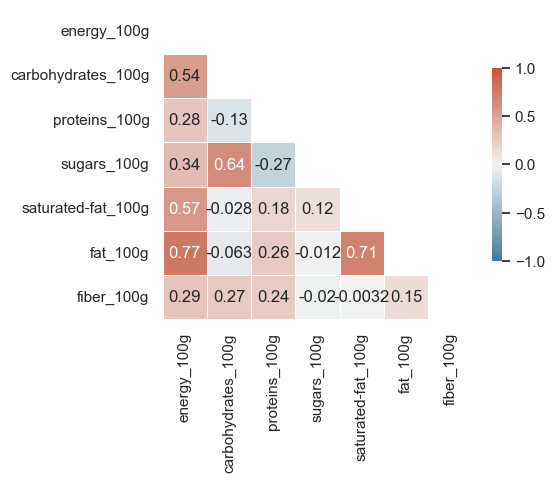

In [151]:

corr = data3[['energy_100g','carbohydrates_100g','proteins_100g', 'sugars_100g', 'saturated-fat_100g', 'fat_100g', 'fiber_100g']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": 0.5});

On remarque aussi que « sugars_100g » et « carbohydrates_100g » sont très corrélées. Même chose pour « fat_100g » et « saturated_fat_100g ». Normal car l’un est comprise dans l’autre. En effet sur les étiquettes nous retrouvons "Glucides dont sucre" et "Matières grasse dont acides gras saturés"


<AxesSubplot: xlabel='carbohydrates_100g', ylabel='sugars_100g'>

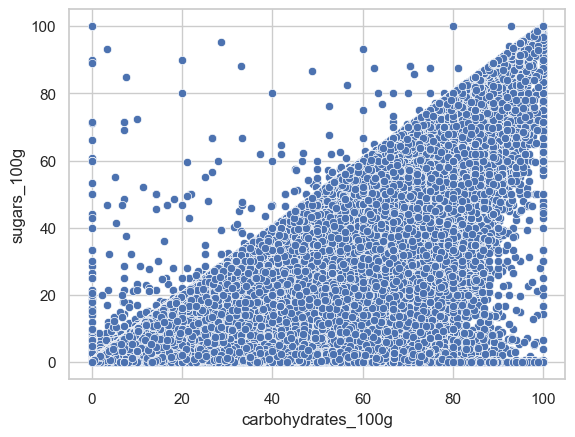

In [152]:
sns.scatterplot(x="carbohydrates_100g",y="sugars_100g",data=data3)

In [153]:
df_tmp=data3.loc[data3['sugars_100g']>data3['carbohydrates_100g']]
print(df_tmp.shape[0])
print(df_tmp.shape[0]/data2.shape[0])

605
0.0018862100895092424


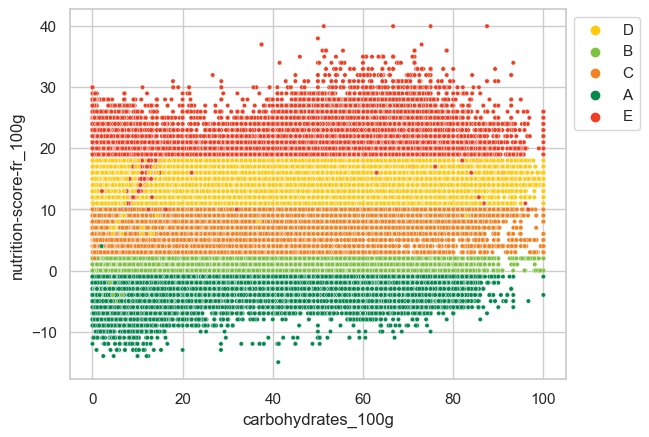

In [154]:
sns.scatterplot(x="carbohydrates_100g",y="nutrition-score-fr_100g",hue="nutrition_grade_fr",s=10,data=data3,palette=sns.blend_palette(['#FECA0A','#7FC241' , '#F58220','#008B4C','#EF3E22'],5))
plt.legend( bbox_to_anchor = (1,1))

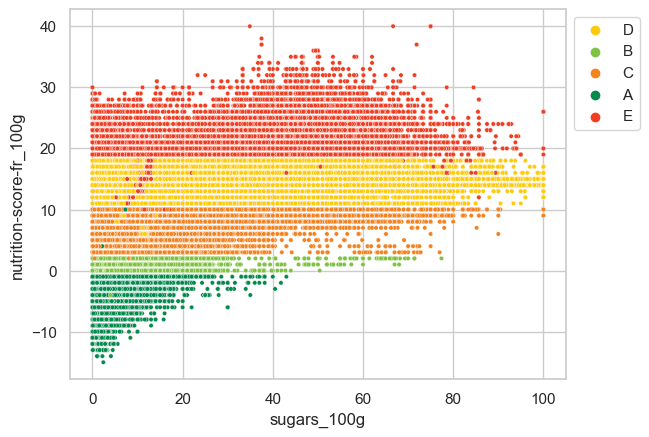

In [155]:
sns.scatterplot(x="sugars_100g",y="nutrition-score-fr_100g",hue="nutrition_grade_fr",s=10,data=data3,palette=sns.blend_palette(['#FECA0A','#7FC241' , '#F58220','#008B4C','#EF3E22'],5))
plt.legend( bbox_to_anchor = (1,1))

<AxesSubplot: xlabel='fat_100g', ylabel='saturated-fat_100g'>

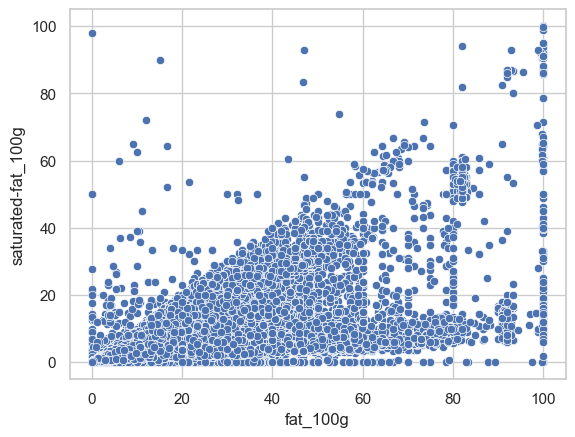

In [156]:
sns.scatterplot(x="fat_100g",y="saturated-fat_100g",data=data3)

In [157]:
df_tmp=data3.loc[data3['saturated-fat_100g']>data3['fat_100g']]
print(df_tmp.shape[0])
print(df_tmp.shape[0]/data3.shape[0])

311
0.0015290670232850849


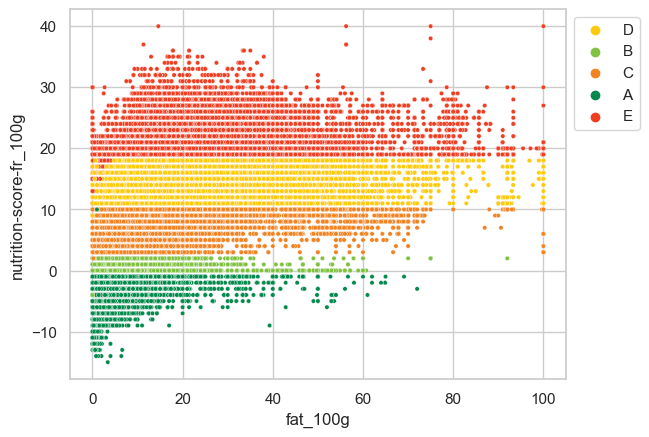

In [158]:
sns.scatterplot(x="fat_100g",y="nutrition-score-fr_100g",hue="nutrition_grade_fr",s=10,data=data3,palette=sns.blend_palette(['#FECA0A','#7FC241' , '#F58220','#008B4C','#EF3E22'],5))
plt.legend( bbox_to_anchor = (1,1))

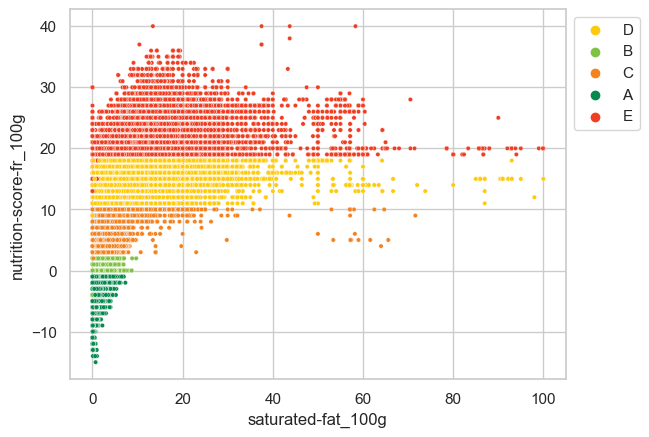

In [159]:
sns.scatterplot(x="saturated-fat_100g",y="nutrition-score-fr_100g",hue="nutrition_grade_fr",s=10,data=data3,palette=sns.blend_palette(['#FECA0A','#7FC241' , '#F58220','#008B4C','#EF3E22'],5))
plt.legend( bbox_to_anchor = (1,1))

<AxesSubplot: xlabel='sugars_100g', ylabel='energy_100g'>

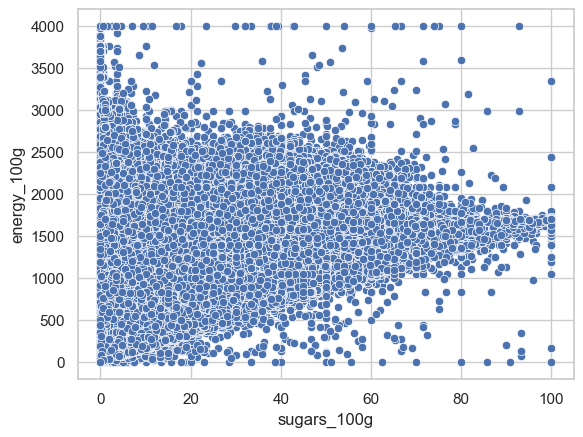

In [160]:
sns.scatterplot(y="energy_100g",x="sugars_100g",data=data3)

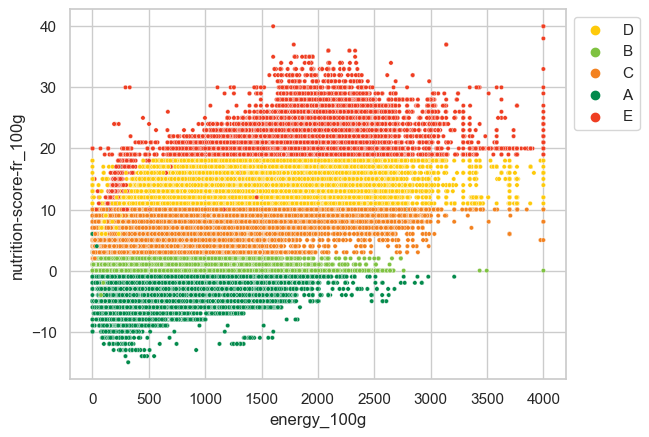

In [161]:
sns.scatterplot(x="energy_100g",y="nutrition-score-fr_100g",hue="nutrition_grade_fr",s=10,data=data3,palette=sns.blend_palette(['#FECA0A','#7FC241' , '#F58220','#008B4C','#EF3E22'],5))
plt.legend( bbox_to_anchor = (1,1))

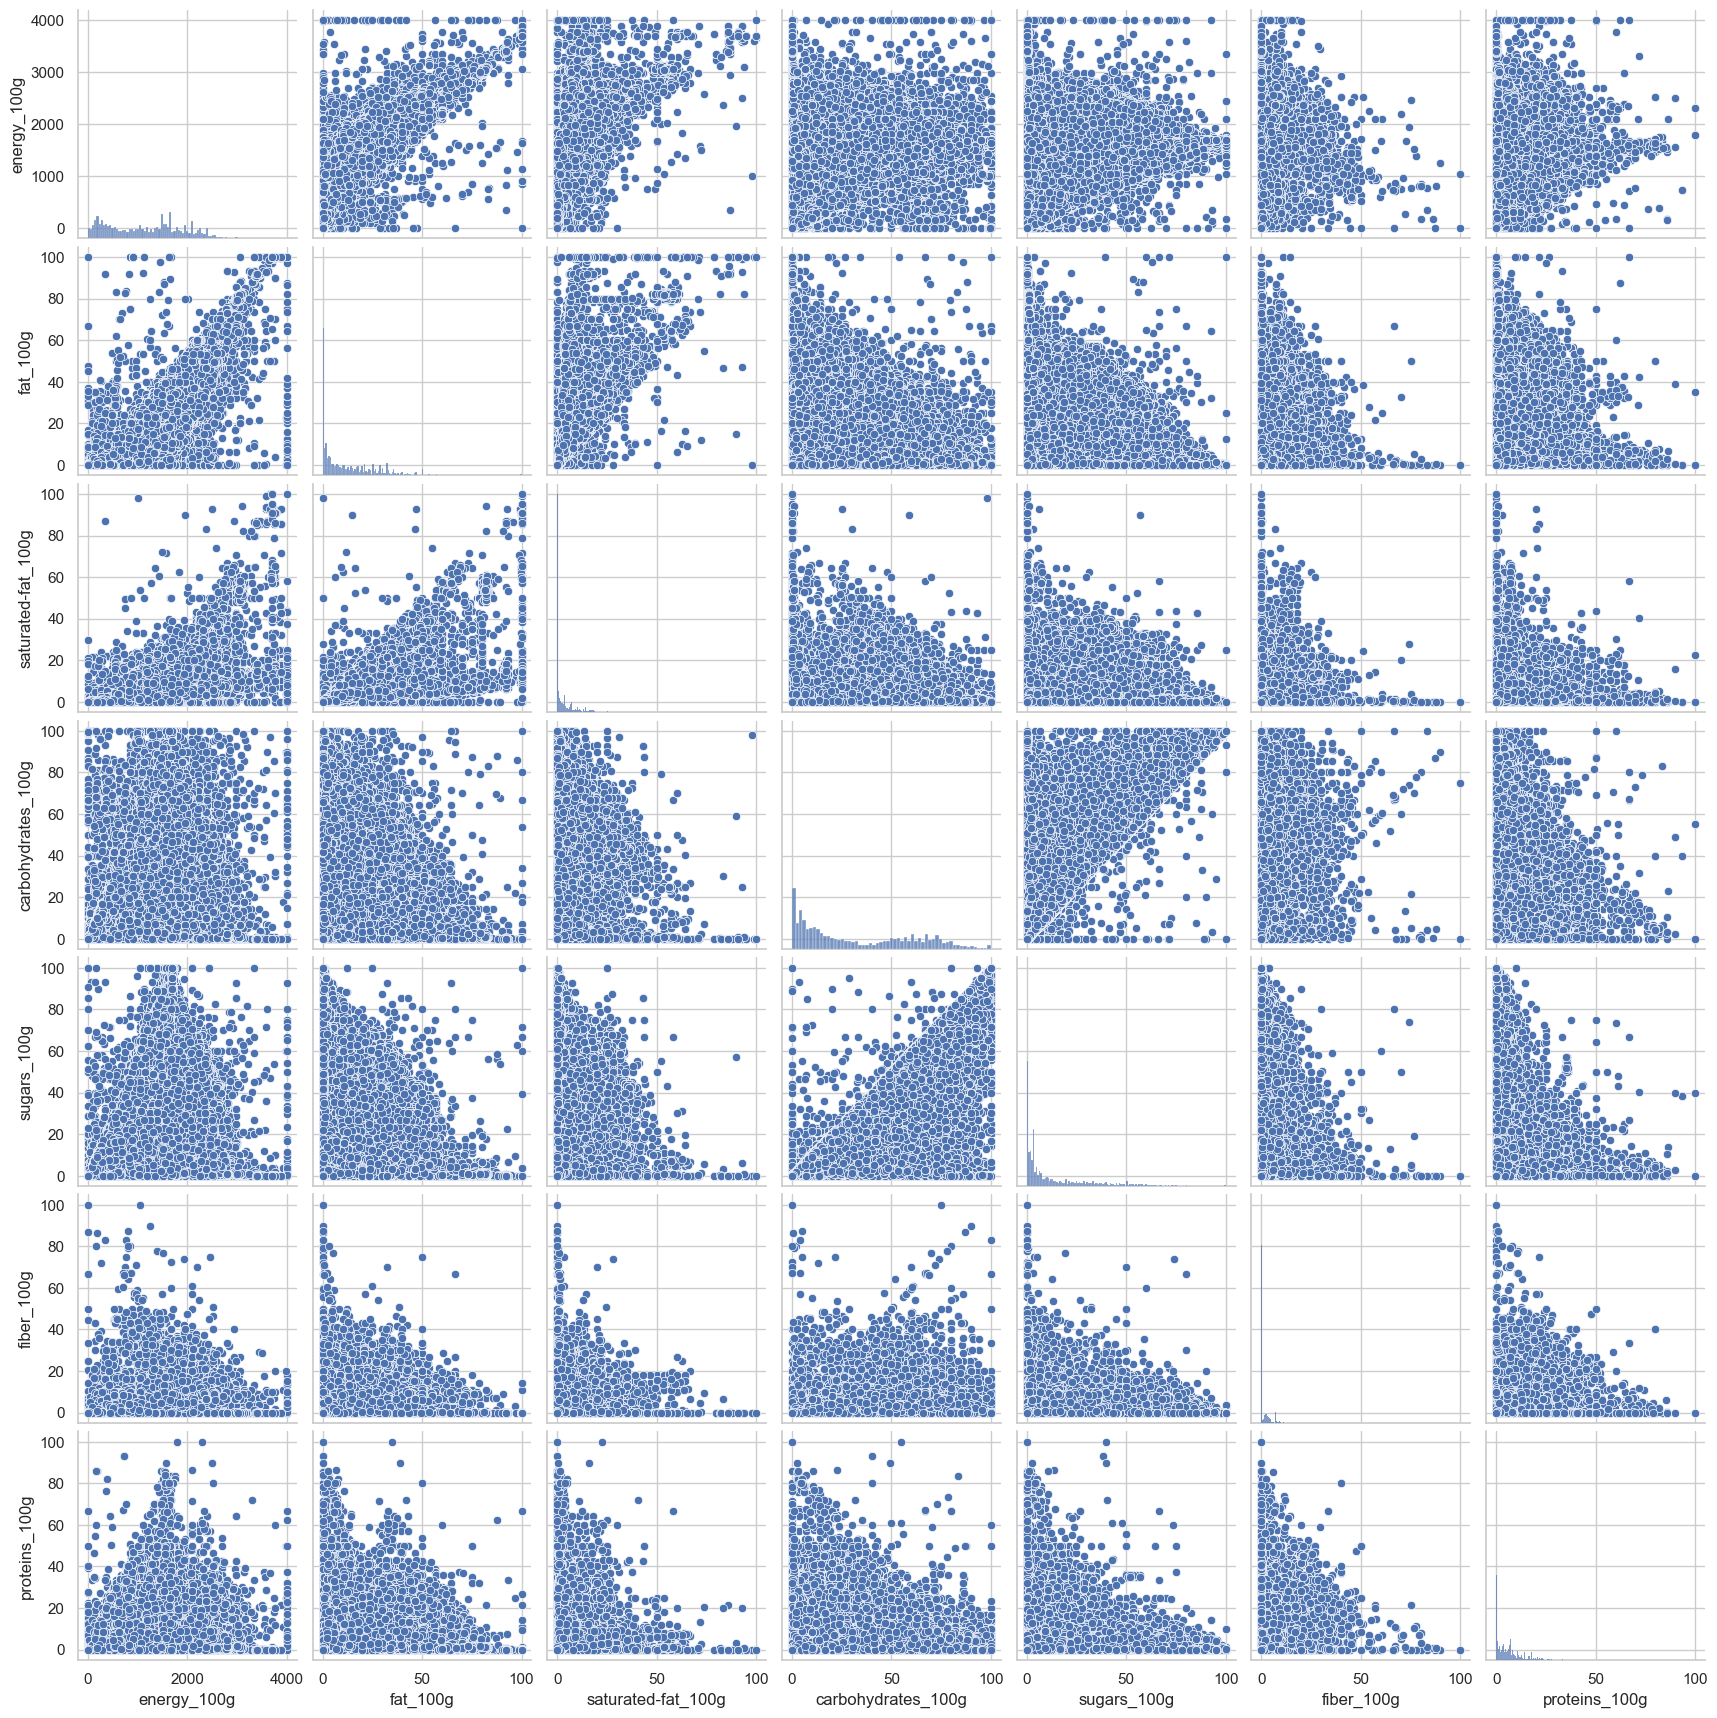

In [162]:
df_tmp=data3.loc[:,['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g', 'fiber_100g','proteins_100g']]
sns.pairplot(df_tmp)

#### <a name="C4122">4.1.2.2 Analyses en composantes principales (ACP) </a>

Concentrons nous sur la dataframe "df_list_num" créee par la fonction de corrélation appellée ci-dessus

In [163]:
df_list_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203392 entries, 1 to 320745
Data columns (total 34 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   salt_100g                                203392 non-null  float64
 1   proteins_100g                            203392 non-null  float64
 2   sugars_100g                              203392 non-null  float64
 3   carbohydrates_100g                       203392 non-null  float64
 4   nutrition-score-fr_100g                  203392 non-null  float64
 5   saturated-fat_100g                       203392 non-null  float64
 6   fat_100g                                 203392 non-null  float64
 7   energy_100g                              203392 non-null  float64
 8   nutrition_grade_fr_2                     203392 non-null  float64
 9   ingredients_that_may_be_from_palm_oil_n  203392 non-null  float64
 10  ingredients_from_palm_oil_n     

In [164]:
#Suppression de quelques colonnes pour ne pas la considérer dans le poids des axes d'inerties et retrouver les variables utilisées pour la corrélation
df_list_num_ss_nutriscore=df_list_num.copy()
df_list_num_ss_nutriscore.drop(columns='nutrition-score-fr_100g', axis=1, inplace = True)
df_list_num_ss_nutriscore.drop(columns='nutrition_grade_fr_2', axis=1, inplace = True)
df_list_num_ss_nutriscore.drop(columns='energy_100g', axis=1, inplace = True)

In [165]:
df_list_num_ss_nutriscore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203392 entries, 1 to 320745
Data columns (total 31 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   salt_100g                                203392 non-null  float64
 1   proteins_100g                            203392 non-null  float64
 2   sugars_100g                              203392 non-null  float64
 3   carbohydrates_100g                       203392 non-null  float64
 4   saturated-fat_100g                       203392 non-null  float64
 5   fat_100g                                 203392 non-null  float64
 6   ingredients_that_may_be_from_palm_oil_n  203392 non-null  float64
 7   ingredients_from_palm_oil_n              203392 non-null  float64
 8   additives_n                              203392 non-null  float64
 9   fiber_100g                               203392 non-null  float64
 10  cholesterol_100g                

In [166]:
#Nombre de composantes ? 
#Nombre de composant choisi
n_components = 31

In [167]:
#Numéro des composantes à choisir pour le cercle des corrélations 
c1=0
c2=1

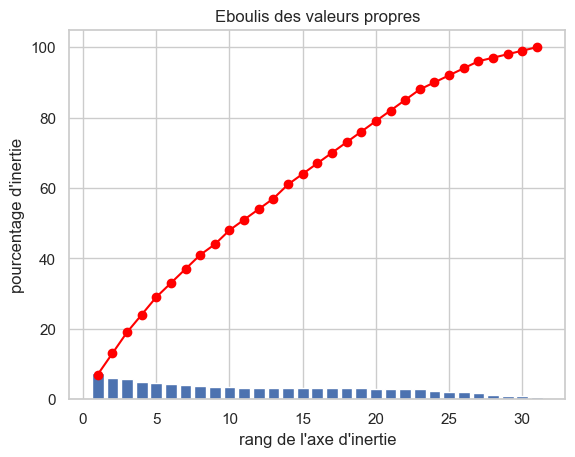

array([0.07, 0.06, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01])

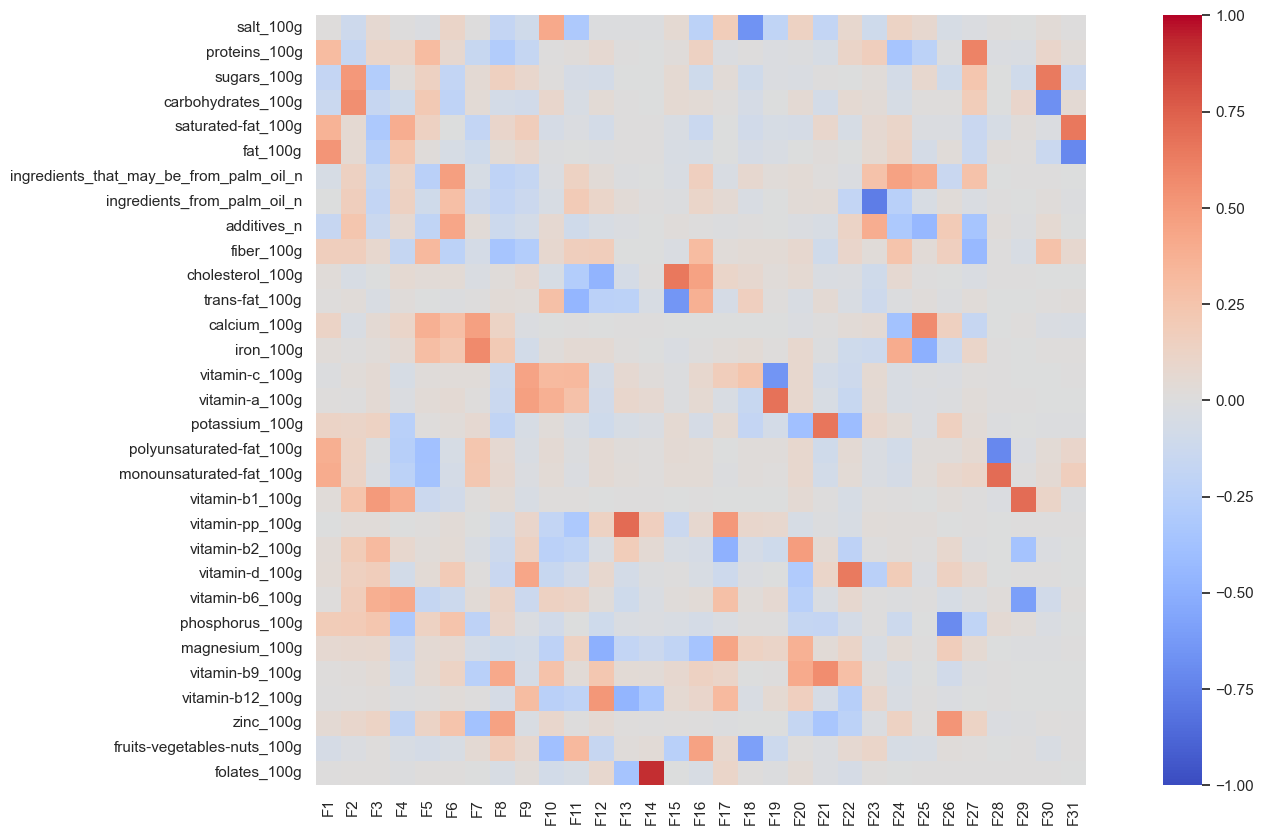

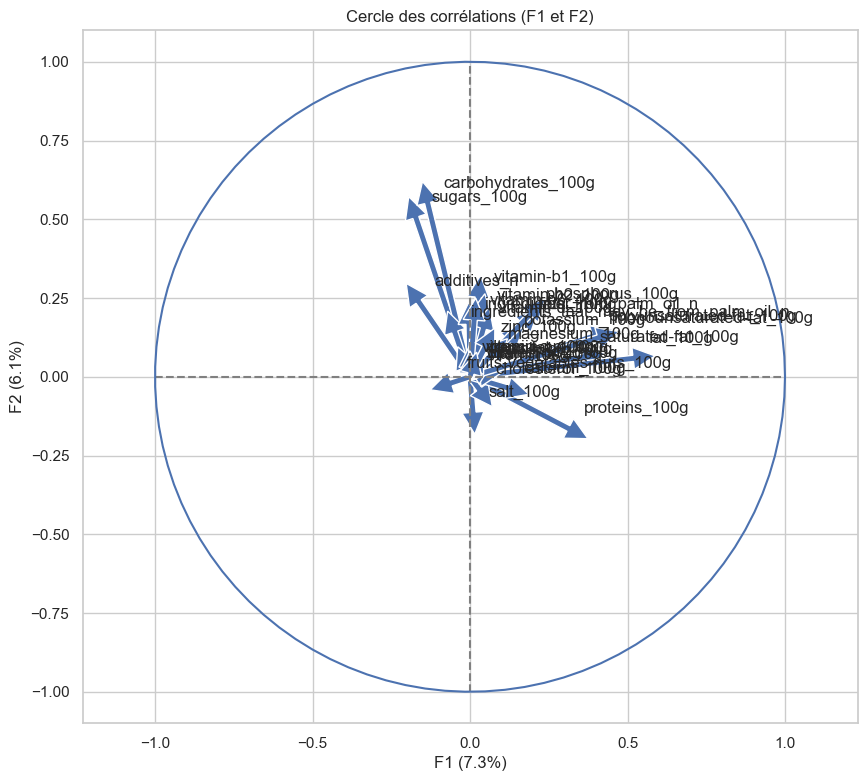

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1196\4216939363.py:58: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(   X_[:, x],


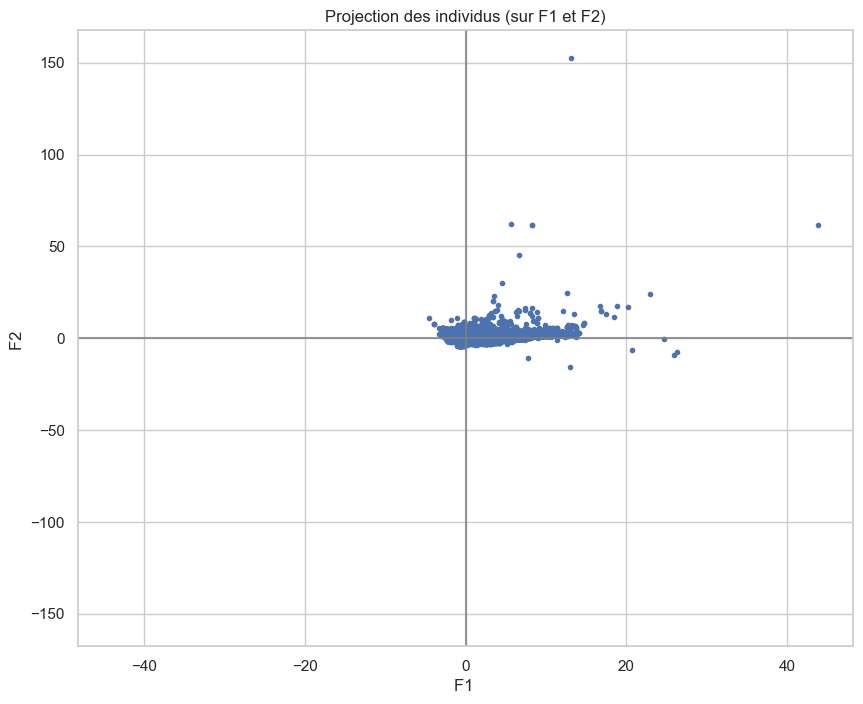

In [168]:
pcs=ACP(df_list_num_ss_nutriscore,n_components,c1,c2)

In [169]:
pcs.T

F1        F2        F3  \
salt_100g                                0.009373 -0.112756  0.068221   
proteins_100g                            0.312410 -0.164133  0.102911   
sugars_100g                             -0.171978  0.505537 -0.276124   
carbohydrates_100g                      -0.134369  0.551790 -0.161509   
saturated-fat_100g                       0.359711  0.062013 -0.317067   
fat_100g                                 0.517990  0.058318 -0.254538   
ingredients_that_may_be_from_palm_oil_n -0.048398  0.142038 -0.152096   
ingredients_from_palm_oil_n             -0.002765  0.166520 -0.179782   
additives_n                             -0.163080  0.238605 -0.139072   
fiber_100g                               0.168600  0.166075  0.085787   
cholesterol_100g                         0.029092 -0.039064 -0.007241   
trans-fat_100g                           0.011955  0.025278 -0.035825   
calcium_100g                             0.119953 -0.035709  0.050118   
iron_100g                                0.030560  0.003876  0.025111   
vitamin-c_100g                          -0.012435  0.030415  0.052114   
vitamin-a_100g                           0.010801  0.006680  0.047935   
potassium_100g                           0.121558  0.114304  0.138454   
polyunsaturated-fat_100g                 0.390254  0.128316 -0.012329   
monounsaturated-fat_100g                 0.406215  0.123014 -0.029585   
vitamin-b1_100g                          0.026193  0.252073  0.493456   
vitamin-pp_100g                         -0.000200  0.030383  0.025231   
vitamin-b2_100g                          0.034824  0.194664  0.318735   
vitamin-d_100g                           0.042309  0.152644  0.173177   
vitamin-b6_100g                          0.013044  0.179671  0.384832   
phosphorus_100g                          0.190458  0.197228  0.237130   
magnesium_100g                           0.069786  0.070972  0.083240   
vitamin-b9_100g                          0.011954  0.023105  0.041505   
vitamin-b12_100g                         0.000021  0.011947  0.020135   
zinc_100g                                0.047098  0.092252  0.125785   
fruits-vegetables-nuts_100g             -0.059694 -0.019604  0.014754   
folates_100g                             0.002792  0.010346  0.010962   

                                               F4        F5        F6  \
salt_100g                                0.002417 -0.015760  0.114256   
proteins_100g                            0.107107  0.305431  0.074138   
sugars_100g                              0.016865  0.144840 -0.185043   
carbohydrates_100g                      -0.097583  0.215525 -0.205627   
saturated-fat_100g                       0.390801  0.147957 -0.000348   
fat_100g                                 0.240754  0.020794 -0.048325   
ingredients_that_may_be_from_palm_oil_n  0.129419 -0.235863  0.473454   
ingredients_from_palm_oil_n              0.147511 -0.094800  0.281480   
additives_n                              0.067729 -0.196704  0.430944   
fiber_100g                              -0.166802  0.325114 -0.222269   
cholesterol_100g                         0.060574  0.038996  0.043431   
trans-fat_100g                           0.022452 -0.005436 -0.012563   
calcium_100g                             0.107986  0.380938  0.284432   
iron_100g                                0.047942  0.294398  0.229128   
vitamin-c_100g                          -0.047473  0.021182  0.029493   
vitamin-a_100g                          -0.021713  0.039032  0.049134   
potassium_100g                          -0.247976  0.008995  0.030832   
polyunsaturated-fat_100g                -0.251851 -0.377633 -0.052908   
monounsaturated-fat_100g                -0.225523 -0.371707 -0.066316   
vitamin-b1_100g                          0.397412 -0.130784 -0.092934   
vitamin-pp_100g                         -0.005311  0.009670  0.035219   
vitamin-b2_100g                          0.078199  0.027172  0.042722   
vitamin-d_100g                 

In [170]:
pcs

salt_100g  proteins_100g  sugars_100g  carbohydrates_100g  \
F1    0.009373       0.312410    -0.171978           -0.134369   
F2   -0.112756      -0.164133     0.505537            0.551790   
F3    0.068221       0.102911    -0.276124           -0.161509   
F4    0.002417       0.107107     0.016865           -0.097583   
F5   -0.015760       0.305431     0.144840            0.215525   
F6    0.114256       0.074138    -0.185043           -0.205627   
F7    0.007624      -0.155367     0.049586            0.046385   
F8   -0.178846      -0.288774     0.151607           -0.072988   
F9   -0.098502      -0.168662     0.093475           -0.088377   
F10   0.416523       0.007668     0.008054            0.092532   
F11  -0.309485       0.016340    -0.058786           -0.044208   
F12  -0.011949       0.064465    -0.071514            0.040990   
F13  -0.008969       0.004389    -0.006877            0.004045   
F14  -0.012429      -0.002816    -0.004470           -0.002492   
F15   0.056973       0.016178     0.055340            0.061234   
F16  -0.225700       0.142108    -0.104976            0.040559   
F17   0.181547      -0.019561     0.033123            0.014334   
F18  -0.659896       0.000857    -0.097326           -0.062449   
F19  -0.201514      -0.017964    -0.019251           -0.003545   
F20   0.133449      -0.012602    -0.026745            0.047565   
F21  -0.186541      -0.051584     0.002468           -0.076884   
F22   0.081924       0.114942    -0.002355            0.058244   
F23  -0.102691       0.169591     0.024125            0.032487   
F24   0.125228      -0.346862    -0.072937           -0.053274   
F25   0.070989      -0.223960     0.079694            0.012047   
F26  -0.050127      -0.015037    -0.099138            0.012983   
F27  -0.016600       0.604921     0.236863            0.179910   
F28   0.004986      -0.015634    -0.003521           -0.002341   
F29  -0.002839      -0.025588    -0.094301            0.094497   
F30   0.034850       0.100326     0.641192           -0.675441   
F31   0.001266       0.024110    -0.127505            0.053052   

     saturated-fat_100g  fat_100g  ingredients_that_may_be_from_palm_oil_n  \
F1             0.359711  0.517990                                -0.048398   
F2             0.062013  0.058318                                 0.142038   
F3            -0.317067 -0.254538                                -0.152096   
F4             0.390801  0.240754                                 0.129419   
F5             0.147957  0.020794                                -0.235863   
F6            -0.000348 -0.048325                                 0.473454   
F7            -0.180187 -0.105489                                -0.048432   
F8             0.101190  0.045695                                -0.208220   
F9             0.173495  0.089461                                -0.164152   
F10           -0.055792 -0.011230                                -0.019468   
F11           -0.017127 -0.000237                                 0.135752   
F12           -0.073292 -0.014184                                 0.038525   
F13            0.000074  0.005383                                -0.013933   
F14            0.000633  0.003021                                -0.000468   
F15           -0.033244 -0.044118                                -0.033629   
F16           -0.140315 -0.048124                                 0.159298   
F17           -0.001277 -0.000955                                -0.032332   
F18           -0.093137 -0.054827                                 0.075086   
F19           -0.048375 -0.033566                                 0.024442   
F20           -0.059012 -0.003534                                 0.042866   
F21            0.087317  0.020047                                 0.009063   
F22           -0.047916 -0.003306                                -0.022611   
F23            0.067620  0.059513                                 0.259095   
F24            0.104

In [171]:
pcs.shape[0]

31

In [172]:
pcs.shape[1]

31

In [173]:
pcs.iloc[30,30]

-0.0011477816047632886

In [174]:
list_variables=colonnes_correlees(pcs,0.50)
list_variables

['proteins_100g',
 'carbohydrates_100g',
 'salt_100g',
 'polyunsaturated-fat_100g',
 'iron_100g',
 'folates_100g',
 'vitamin-b9_100g',
 'vitamin-c_100g',
 'vitamin-b6_100g',
 'vitamin-pp_100g',
 'fat_100g',
 'vitamin-a_100g',
 'vitamin-d_100g',
 'vitamin-b1_100g',
 'vitamin-b12_100g',
 'cholesterol_100g',
 'monounsaturated-fat_100g',
 'ingredients_from_palm_oil_n',
 'trans-fat_100g',
 'phosphorus_100g',
 'sugars_100g',
 'calcium_100g',
 'fruits-vegetables-nuts_100g',
 'saturated-fat_100g',
 'zinc_100g',
 'potassium_100g']

#### <a name="C4123">4.1.2.3 Sélection des variables numériques </a>

On va garder toutes les variables trouvées dans la corrélation et ACP. La liste principale, composé de 7 éléments, correspond aux ingrédients les plus utilisés courrament.
Création de la liste de partitionnement pour le K-Means.

In [175]:
#Ajout de fiber et saturated_fat pas présent dans liste ACP
#list_variables.append("fiber_100g")
#list_variables.append("saturated-fat_100g")
#list_variables.append("additives_n")
list_variables=["fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","fiber_100g","proteins_100g","salt_100g","vitamin-a_100g","vitamin-c_100g","vitamin-b1_100g","vitamin-b6_100g","vitamin-b9_100g","vitamin-b12_100g","vitamin-d_100g","vitamin-pp_100g"]
list_variables

['fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'vitamin-b1_100g',
 'vitamin-b6_100g',
 'vitamin-b9_100g',
 'vitamin-b12_100g',
 'vitamin-d_100g',
 'vitamin-pp_100g']

In [176]:
df_list_num_partitionnement=df_list_num[list_variables]

In [177]:
df_list_num_partitionnement.head()

fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
1      28.57               28.57               64.29        14.29         3.6   
2      17.86                0.00               60.71        17.86         7.1   
3      57.14                5.36               17.86         3.57         7.1   
7      18.75                4.69               57.81        15.62         9.4   
12     36.67                5.00               36.67         3.33         6.7   

    proteins_100g  salt_100g  vitamin-a_100g  vitamin-c_100g  vitamin-b1_100g  \
1            3.57    0.00000             0.0          0.0214              0.0   
2           17.86    0.63500             0.0          0.0000              0.0   
3           17.86    1.22428             0.0          0.0000              0.0   
7           14.06    0.13970             0.0          0.0000              0.0   
12          16.67    1.60782             0.0          0.0000              0.0   

    vitamin-b6_100g  vitamin-b9_100g  vitamin-b12_100g  vitamin-d_100g  \
1               0.0              0.0               0.0             0.0   
2               0.0              0.0               0.0             0.0   
3               0.0              0.0               0.0             0.0   
7               0.0              0.0               0.0             0.0   
12              0.0              0.0               0.0             0.0   

    vitamin-pp_100g  
1               0.0  
2               0.0  
3               0.0  
7               0.0  
12              0.0

In [178]:
df_list_num_partitionnement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203392 entries, 1 to 320745
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fat_100g            203392 non-null  float64
 1   saturated-fat_100g  203392 non-null  float64
 2   carbohydrates_100g  203392 non-null  float64
 3   sugars_100g         203392 non-null  float64
 4   fiber_100g          203392 non-null  float64
 5   proteins_100g       203392 non-null  float64
 6   salt_100g           203392 non-null  float64
 7   vitamin-a_100g      203392 non-null  float64
 8   vitamin-c_100g      203392 non-null  float64
 9   vitamin-b1_100g     203392 non-null  float64
 10  vitamin-b6_100g     203392 non-null  float64
 11  vitamin-b9_100g     203392 non-null  float64
 12  vitamin-b12_100g    203392 non-null  float64
 13  vitamin-d_100g      203392 non-null  float64
 14  vitamin-pp_100g     203392 non-null  float64
dtypes: float64(15)
memory usage: 24.8 

### <a name="C4123">4.1.3 Conclusion : la liste de variables sélectionnées </a>

voir projet3_description.ipynb

## <a name="C42">4.2 Analyses univariées </a>

### <a name="C421">4.2.1 Variables numériques</a>

#### <a name="C4211">4.2.1.1 nutrition-score-fr_100g</a>

##### <a name="C42111">4.2.1.1.1 Mesures de tendances centrales et de dispersions</a>

In [179]:
print("moy:\n",data2['nutrition-score-fr_100g'].mean())
print("med:\n",data2['nutrition-score-fr_100g'].median())
print("mod:\n",data2['nutrition-score-fr_100g'].mode())

moy:
 9.163264383202337
med:
 10.0
mod:
 0    0.0
Name: nutrition-score-fr_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 9.16 avec une médiane à 10. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 10.

In [180]:
#Mesure de dispersion :
print("Ecart type:\n",data2['nutrition-score-fr_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['nutrition-score-fr_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['nutrition-score-fr_100g'].std()/data2['nutrition-score-fr_100g'].mean())


Ecart type:
 9.055155865500756
Var:
 81.99584774851274
Coefficient de variation CV : 0.9882041990705966


Concernant les mesures de dispersions, la variance empirique est de 82. Cette valeur nous montre que les mesures ne sont pas trop dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 9 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 1(écart-type empirique/moyenne)

In [181]:
data2_tmp=data2['nutrition-score-fr_100g']
data2_tmp.describe()

count    221126.000000
mean          9.163264
std           9.055176
min         -15.000000
25%           1.000000
50%          10.000000
75%          16.000000
max          40.000000
Name: nutrition-score-fr_100g, dtype: float64

Le 1er Quartile = 1 : 25% des valeurs sont sous 1 et 75% au-dessus<br>
Le 2eme Quartile = 10 : valeur médiane vu au-dessus : 50% des valeurs sont sous 10 et 50% au-dessus<br> 
Le 3eme Quartile = 16: 75% des valeurs sont sous 16 et 25% au-dessus<br> 
L'écart interquartile = 16-1 = 15

##### <a name="C42112">4.2.1.1.2 Visualisations</a>

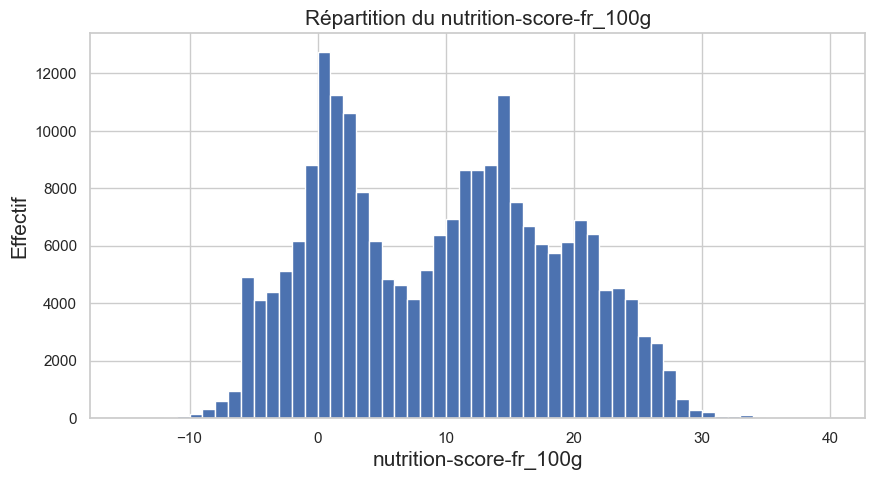

In [182]:
plt.figure(figsize=(10,5))
plt.hist(data2['nutrition-score-fr_100g'], bins=55)
#data2[data2.nutrition-score-fr_100g.abs() < 700]["nutrition-score-fr_100g"].hist(density=True,bins=70)
plt.title("Répartition du nutrition-score-fr_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("nutrition-score-fr_100g", fontsize=15) 
plt.show()

In [183]:
#courbe interactive
df_tmp=data2['nutrition-score-fr_100g'].value_counts().reset_index()
df_tmp=pd.DataFrame(df_tmp)
df_tmp.columns=['x','y']
df_tmp.sort_values(by=['x'], ascending=True, inplace=True)
df_tmp.head()

size = 100
np.random.seed(0)
x_data=df_tmp['x']
y_data=df_tmp['y']


plt2.figure(title='Répartition du Nutrition-score-fr_100g')
plt2.plot(x_data, y_data)
plt2.show()

#### <a name="C4212">4.2.1.2 sugars_100g</a>

##### <a name="C32121">3.2.1.2.1 Mesures de tendances centrales et de dispersions</a>

In [184]:
print("moy:\n",data2['sugars_100g'].mean())
print("med:\n",data2['sugars_100g'].median())
print("mod:\n",data2['sugars_100g'].mode())

moy:
 15.984950048290642
med:
 5.71
mod:
 0    0.0
Name: sugars_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 16 avec une médiane à 5.7. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 5.7.

In [185]:
#Mesure de dispersion :
print("Ecart type:\n",data2['sugars_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['sugars_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['sugars_100g'].std()/data2['sugars_100g'].mean())


Ecart type:
 21.1644123838625
Var:
 447.93235155419245
Coefficient de variation CV : 1.3240238797833581


Concernant les mesures de dispersions, la variance empirique est de 447. Cette valeur nous montre que les mesures sont assez dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 21 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 1.32(écart-type empirique/moyenne)

In [186]:
data2_tmp=data2['sugars_100g']
data2_tmp.describe()

count    244975.000000
mean         15.984950
std          21.164456
min           0.000000
25%           1.300000
50%           5.710000
75%          24.000000
max         100.000000
Name: sugars_100g, dtype: float64

Le 1er Quartile = 1.3 : 25% des valeurs sont sous 1.3 et 75% au-dessus<br>
Le 2eme Quartile = 5.7 : valeur médiane vu au-dessus : 50% des valeurs sont sous 5.7 et 50% au-dessus<br> 
Le 3eme Quartile = 24: 75% des valeurs sont sous 24 et 25% au-dessus<br> 
L'écart interquartile = 24-1.3 = 22.7

##### <a name="C32122">3.2.1.2.2 Visualisations</a>

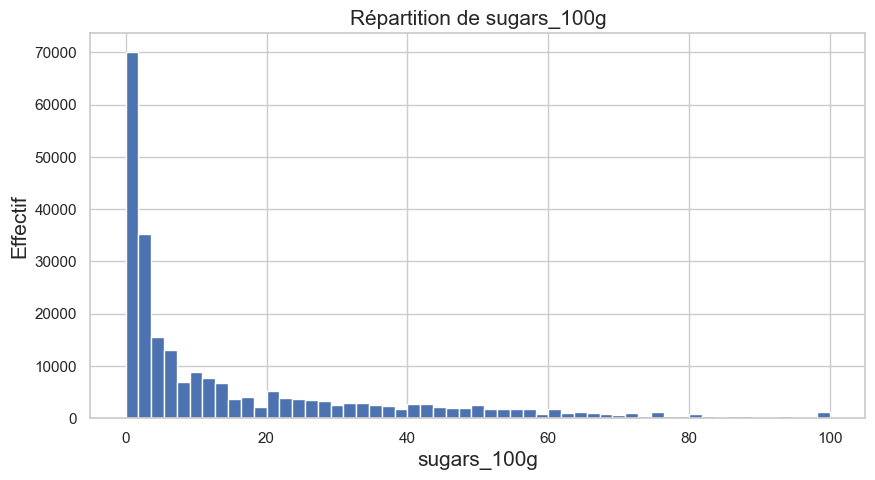

In [187]:
plt.figure(figsize=(10,5))
plt.hist(data2['sugars_100g'], bins=55)
plt.title("Répartition de sugars_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("sugars_100g", fontsize=15) 
plt.show()

#### <a name="C4213">4.2.1.3 fat_100g</a>

##### <a name="C42131">4.2.1.3.1 Mesures de tendances centrales et de dispersions</a>

In [188]:
print("moy:\n",data2['fat_100g'].mean())
print("med:\n",data2['fat_100g'].median())
print("mod:\n",data2['fat_100g'].mode())

moy:
 12.724250667184617
med:
 5.0
mod:
 0    0.0
Name: fat_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 12.7 avec une médiane à 5. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 5.

In [189]:
#Mesure de dispersion :
print("Ecart type:\n",data2['fat_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['fat_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['fat_100g'].std()/data2['fat_100g'].mean())

Ecart type:
 17.503145828683838
Var:
 306.3601139001724
Coefficient de variation CV : 1.3755766187686713


Concernant les mesures de dispersions, la variance empirique est de 306. Cette valeur nous montre que les mesures sont assez dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 17.5 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 1.38(écart-type empirique/moyenne)

In [190]:
data2_tmp=data2['fat_100g']
data2_tmp.describe()

count    243910.000000
mean         12.724251
std          17.503182
min           0.000000
25%           0.000000
50%           5.000000
75%          20.000000
max         100.000000
Name: fat_100g, dtype: float64

Le 1er Quartile = 0 : au moins 25% des valeurs sont égales à 0  et 75% au-dessus<br>
Le 2eme Quartile = 5 : valeur médiane vu au-dessus : 50% des valeurs sont sous 5 et 50% au-dessus<br> 
Le 3eme Quartile = 20: 75% des valeurs sont sous 20 et 25% au-dessus<br> 
L'écart interquartile = 20-0.3 = 20

##### <a name="C42132">4.2.1.3.2 Visualisations</a>

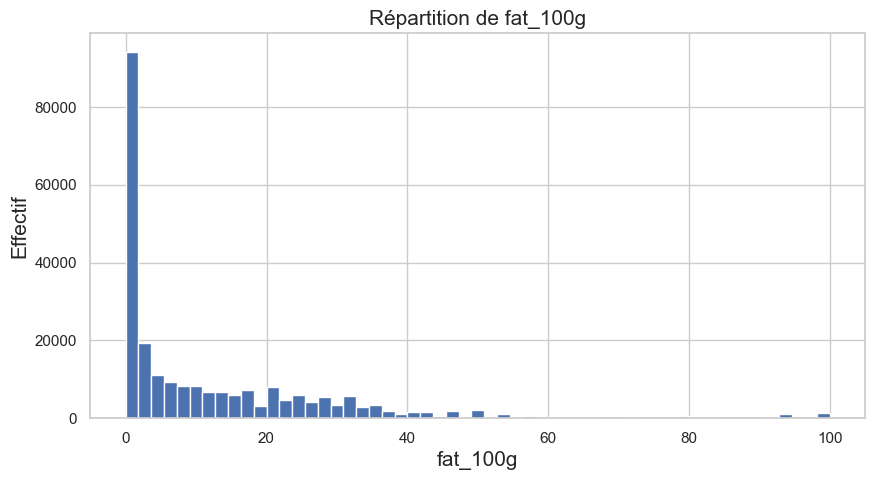

In [191]:
plt.figure(figsize=(10,5))
plt.hist(data2['fat_100g'], bins=55)
plt.title("Répartition de fat_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("fat_100g", fontsize=15) 
plt.show()

#### <a name="C4214">4.2.1.4 saturated-fat_100g</a>

##### <a name="C42141">4.2.1.4.1 Mesures de tendances centrales et de dispersions</a>

In [192]:
print("moy:\n",data2['saturated-fat_100g'].mean())
print("med:\n",data2['saturated-fat_100g'].median())
print("mod:\n",data2['saturated-fat_100g'].mode())

moy:
 5.125554156089104
med:
 1.79
mod:
 0    0.0
Name: saturated-fat_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 5.13 avec une médiane à 1.79. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 1.73.

In [193]:
#Mesure de dispersion :
print("Ecart type:\n",data2['saturated-fat_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['saturated-fat_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['saturated-fat_100g'].std()/data2['saturated-fat_100g'].mean())

Ecart type:
 7.913363553652369
Var:
 62.62132273227364
Coefficient de variation CV : 1.543907360571718


Concernant les mesures de dispersions, la variance empirique est de 63. Cette valeur nous montre que les mesures sont faiblement dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 1.5 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 1.54(écart-type empirique/moyenne)

In [194]:
data2_tmp=data2['saturated-fat_100g']
data2_tmp.describe()

count    229574.000000
mean          5.125554
std           7.913381
min           0.000000
25%           0.000000
50%           1.790000
75%           7.140000
max         100.000000
Name: saturated-fat_100g, dtype: float64

Le 1er Quartile = 0 : au moins 25% des valeurs sont égales à 0  et 75% au-dessus<br>
Le 2eme Quartile = 1.79 : valeur médiane vu au-dessus : 50% des valeurs sont en dessous 1.79 et 50% sont au-dessus<br> 
Le 3eme Quartile = 7.14: 75% des valeurs sont sous 7.14 et 25% au-dessus<br> 
L'écart interquartile = 7.14-0 = 7.14

##### <a name="C42142">4.2.1.4.2 Visualisations</a>

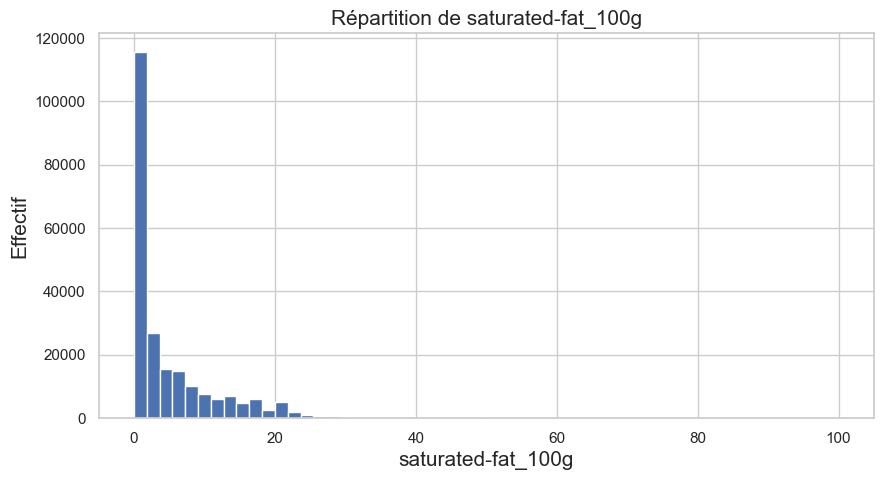

In [195]:
plt.figure(figsize=(10,5))
plt.hist(data2['saturated-fat_100g'], bins=55)
plt.title("Répartition de saturated-fat_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("saturated-fat_100g", fontsize=15) 
plt.show()

#### <a name="C4215">4.2.1.5 carbohydrates_100g</a>

##### <a name="C42151">4.2.1.5.1 Mesures de tendances centrales et de dispersions</a>

In [196]:
print("moy:\n",data2['carbohydrates_100g'].mean())
print("med:\n",data2['carbohydrates_100g'].median())
print("mod:\n",data2['carbohydrates_100g'].mode())

moy:
 32.05335582490394
med:
 20.595
mod:
 0    0.0
Name: carbohydrates_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 32 avec une médiane à 20.6. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 20.6.

In [197]:
#Mesure de dispersion :
print("Ecart type:\n",data2['carbohydrates_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['carbohydrates_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['carbohydrates_100g'].std()/data2['carbohydrates_100g'].mean())

Ecart type:
 29.139966019518752
Var:
 849.1376196187075
Coefficient de variation CV : 0.9091099849870601


Concernant les mesures de dispersions, la variance empirique est de 849. Cette valeur nous montre que les mesures sont assez dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 29 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 0.9 (écart-type empirique/moyenne)

In [198]:
data2_tmp=data2['carbohydrates_100g']
data2_tmp.describe()

count    243592.000000
mean         32.053356
std          29.140026
min           0.000000
25%           6.000000
50%          20.595000
75%          58.330000
max         100.000000
Name: carbohydrates_100g, dtype: float64

Le 1er Quartile = 6 : au moins 25% des valeurs sont en dessous de 6 et 75% au-dessus<br>
Le 2eme Quartile = 20.6 : valeur médiane vu au-dessus : 50% des valeurs sont sous 20 et 50% au-dessus<br> 
Le 3eme Quartile = 58 : 75% des valeurs sont sous 58 et 25% au-dessus<br> 
L'écart interquartile = 58-6 = 52

##### <a name="C42152">4.2.1.5.2 Visualisations</a>

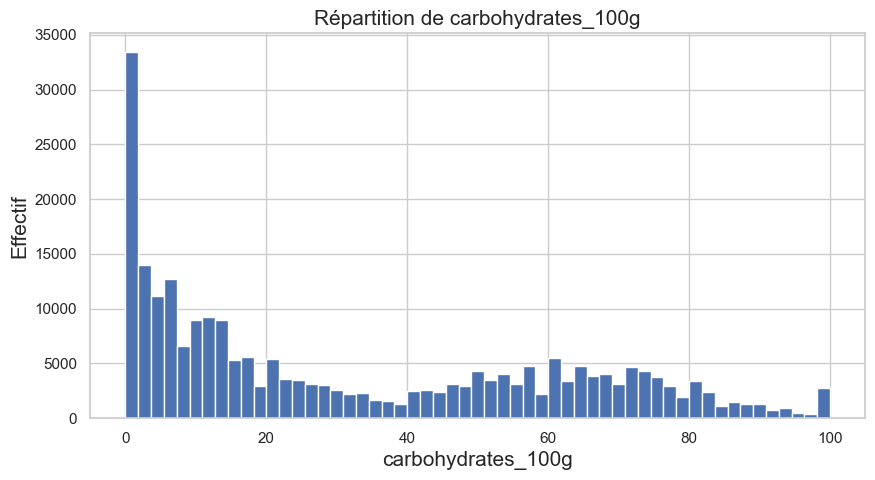

In [199]:
plt.figure(figsize=(10,5))
plt.hist(data2['carbohydrates_100g'], bins=55)
plt.title("Répartition de carbohydrates_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("carbohydrates_100g", fontsize=15) 
plt.show()

#### <a name="C4216">4.2.1.6 salt_100g</a>

##### <a name="C42161">4.2.1.6.1 Mesures de tendances centrales et de dispersions</a>

In [200]:
print("moy:\n",data2['salt_100g'].mean())
print("med:\n",data2['salt_100g'].median())
print("mod:\n",data2['salt_100g'].mode())

moy:
 1.5883678075577865
med:
 0.58
mod:
 0    0.0
Name: salt_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 1.6 avec une médiane à 0.58. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 0.58.

In [201]:
#Mesure de dispersion :
print("Ecart type:\n",data2['salt_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['salt_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['salt_100g'].std()/data2['salt_100g'].mean())

Ecart type:
 6.242252624778901
Var:
 38.96571783155908
Coefficient de variation CV : 3.9299870073232896


Concernant les mesures de dispersions, la variance empirique est de 38.97. Cette valeur nous montre que les mesures sont peu dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 6.24 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 3.93 (écart-type empirique/moyenne)

In [202]:
data2_tmp=data2['salt_100g']
data2_tmp.describe()

count    255375.000000
mean          1.588368
std           6.242265
min           0.000000
25%           0.063500
50%           0.580000
75%           1.371600
max         100.000000
Name: salt_100g, dtype: float64

Le 1er Quartile = 0.064 : au moins 25% des valeurs sont en dessous de 0.064 et 75% au-dessus<br>
Le 2eme Quartile = 0.58 : valeur médiane vu au-dessus : 50% des valeurs sont sous 0.58 et 50% au-dessus<br> 
Le 3eme Quartile = 1.37 : 75% des valeurs sont sous 1.37 et 25% au-dessus<br> 
L'écart interquartile = 1.37-0.064 = 1.306

##### <a name="C42162">4.2.1.6.2 Visualisations</a>

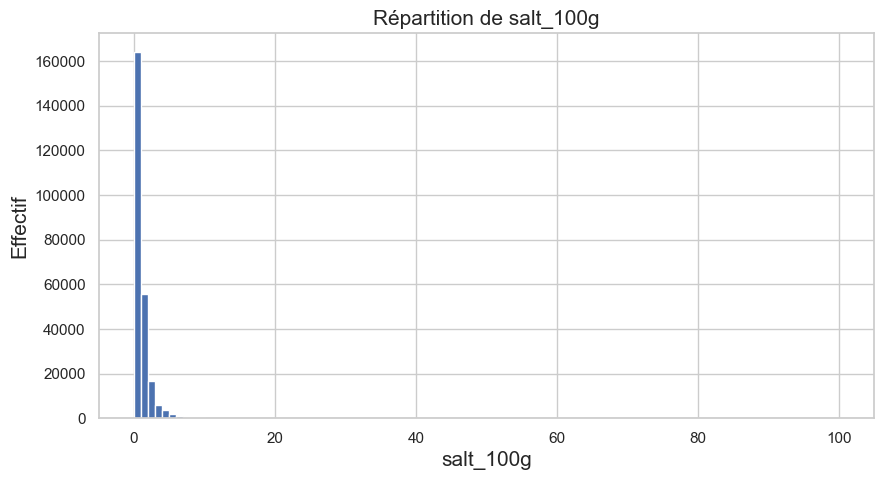

In [203]:
plt.figure(figsize=(10,5))
plt.hist(data2['salt_100g'], bins=100)
plt.title("Répartition de salt_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("salt_100g", fontsize=15) 
plt.show()

#### <a name="C4217">4.2.1.7 fiber_100g</a>

##### <a name="C42171">4.2.1.7.1 Mesures de tendances centrales et de dispersions</a>

In [204]:
print("moy:\n",data2['fiber_100g'].mean())
print("med:\n",data2['fiber_100g'].median())
print("mod:\n",data2['fiber_100g'].mode())

moy:
 2.8324110677697796
med:
 1.5
mod:
 0    0.0
Name: fiber_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 2.83 avec une médiane à 1.5. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 1.5.

In [205]:
#Mesure de dispersion :
print("Ecart type:\n",data2['fiber_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['fiber_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['fiber_100g'].std()/data2['fiber_100g'].mean())

Ecart type:
 4.588220235475101
Var:
 21.051764929223193
Coefficient de variation CV : 1.6199031657825866


Concernant les mesures de dispersions, la variance empirique est de 21.05. Cette valeur nous montre que les mesures sont peu dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 4.59 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 1.62 (écart-type empirique/moyenne)

In [206]:
data2_tmp=data2['fiber_100g']
data2_tmp.describe()

count    200886.000000
mean          2.832411
std           4.588232
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

Le 1er Quartile = 0 :  25% des valeurs sont égale à 0 et 75% sont au-dessus de 0<br>
Le 2eme Quartile = 1.5 : valeur médiane vu au-dessus : 50% des valeurs sont sous 1.5 et 50% au-dessus<br> 
Le 3eme Quartile = 3.6 : 75% des valeurs sont sous 3.6 et 25% au-dessus<br> 
L'écart interquartile = 3.6-0 = 3.6

##### <a name="C42172">4.2.1.7.2 Visualisations</a>

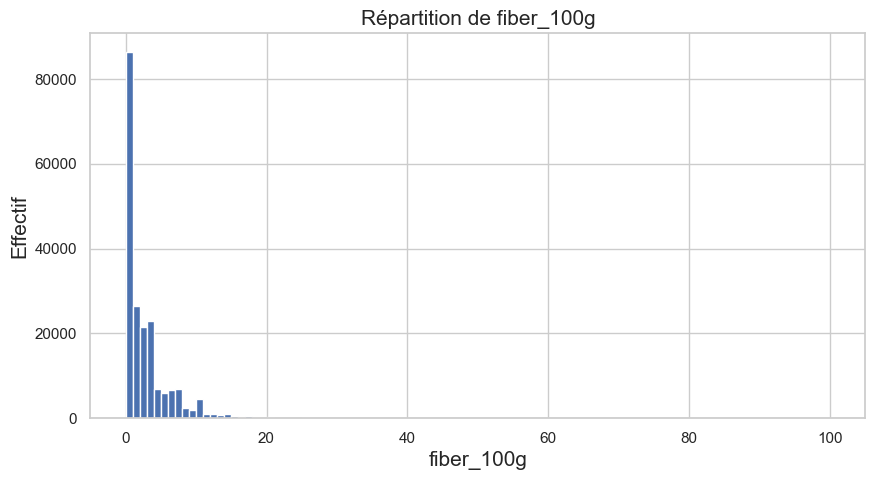

In [207]:
plt.figure(figsize=(10,5))
plt.hist(data2['fiber_100g'], bins=100)
plt.title("Répartition de fiber_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("fiber_100g", fontsize=15) 
plt.show()

#### <a name="C4218">4.2.1.8 proteins_100g</a>

##### <a name="C42181">4.2.1.8.1 Mesures de tendances centrales et de dispersions</a>

In [208]:
print("moy:\n",data2['proteins_100g'].mean())
print("med:\n",data2['proteins_100g'].median())
print("mod:\n",data2['proteins_100g'].mode())

moy:
 7.079543738001349
med:
 4.76
mod:
 0    0.0
Name: proteins_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 7.08 avec une médiane à 4.76. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 4.76.

In [209]:
#Mesure de dispersion :
print("Ecart type:\n",data2['proteins_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['proteins_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['proteins_100g'].std()/data2['proteins_100g'].mean())

Ecart type:
 8.156305703890068
Var:
 66.52532273530964
Coefficient de variation CV : 1.1520970412094862


Concernant les mesures de dispersions, la variance empirique est de 66.53. Cette valeur nous montre que les mesures sont peu dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 8.16 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 1.15 (écart-type empirique/moyenne)

In [210]:
data2_tmp=data2['proteins_100g']
data2_tmp.describe()

count    259925.000000
mean          7.079544
std           8.156321
min           0.000000
25%           0.700000
50%           4.760000
75%          10.000000
max         100.000000
Name: proteins_100g, dtype: float64

Le 1er Quartile = 0.7 : au moins 25% des valeurs sont en dessous de 0.7 et 75% au-dessus<br>
Le 2eme Quartile = 4.76: valeur médiane vu au-dessus : 50% des valeurs sont sous 4.76 et 50% au-dessus<br> 
Le 3eme Quartile = 10 : 75% des valeurs sont sous 10 et 25% au-dessus<br> 
L'écart interquartile = 10-0.7 = 9.3

##### <a name="C42182">4.2.1.8.2 Visualisations</a>

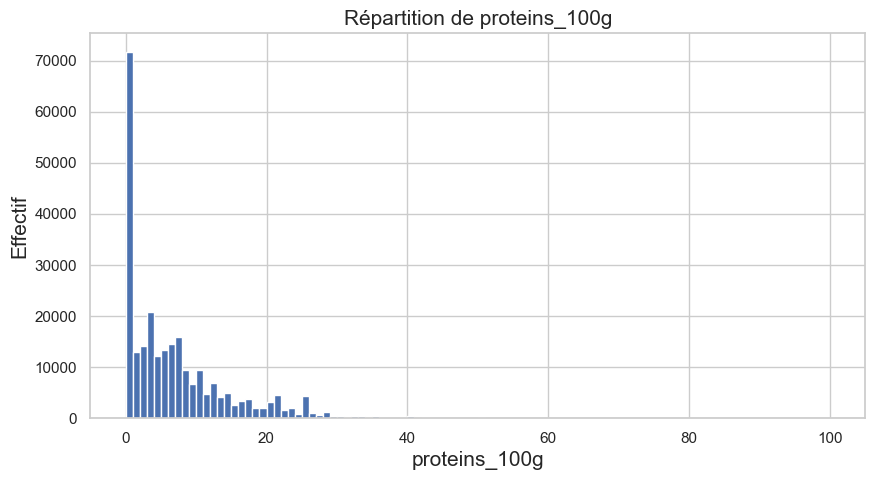

In [211]:
plt.figure(figsize=(10,5))
plt.hist(data2['proteins_100g'], bins=100)
plt.title("Répartition de proteins_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("proteins_100g", fontsize=15) 
plt.show()

#### <a name="C4219">4.2.1.9 energy_100g</a>

##### <a name="C42191">4.2.1.9.1 Mesures de tendances centrales et de dispersions</a>

In [212]:
print("moy:\n",data2['energy_100g'].mean())
print("med:\n",data2['energy_100g'].median())
print("mod:\n",data2['energy_100g'].mode())

moy:
 1125.3153620871883
med:
 1100.0
mod:
 0    0.0
Name: energy_100g, dtype: float64


Le mode est de 0. Ce qui signifie que c'est la valeur la plus fréquente qui apparait dans le jeu de données. Cela étant dit la moyenne globale est de 1125.32 avec une médiane à 1100. Cette dernière valeur signifie que j'ai autant de valeur en dessous et au dessus de 1100.

In [213]:
#Mesure de dispersion :
print("Ecart type:\n",data2['energy_100g'].std(ddof=0)) #Ecart type empirique
print("Var:\n",data2['energy_100g'].var(ddof=0)) #Variance empirique
print("Coefficient de variation CV :",data2['energy_100g'].std()/data2['energy_100g'].mean())

Ecart type:
 798.7612425306771
Var:
 638019.5225691511
Coefficient de variation CV : 0.7098123769061337


Concernant les mesures de dispersions, la variance empirique est de 638019. Cette valeur nous montre que les mesures sont assez dispersées autour de la valeur moyenne. Cette dispersion est aussi illustrée par l'écart-type 798.76 (qui est tout simplement la racine carrée de la variance empirique). Le coefficient de variation = 0.71 (écart-type empirique/moyenne)

In [214]:
data2_tmp=data2['energy_100g']
data2_tmp.describe()

count    261136.000000
mean       1125.315362
std         798.762772
min           0.000000
25%         377.000000
50%        1100.000000
75%        1674.000000
max        4000.000000
Name: energy_100g, dtype: float64

Le 1er Quartile = 377 : au moins 25% des valeurs sont en dessous de 377 et 75% au-dessus<br>
Le 2eme Quartile = 1100: valeur médiane vu au-dessus : 50% des valeurs sont sous 1100 et 50% au-dessus<br> 
Le 3eme Quartile = 1674 : 75% des valeurs sont sous 1674 et 25% au-dessus<br> 
L'écart interquartile = 1674-377 = 1297

##### <a name="C42192">4.2.1.9.2 Visualisations</a>

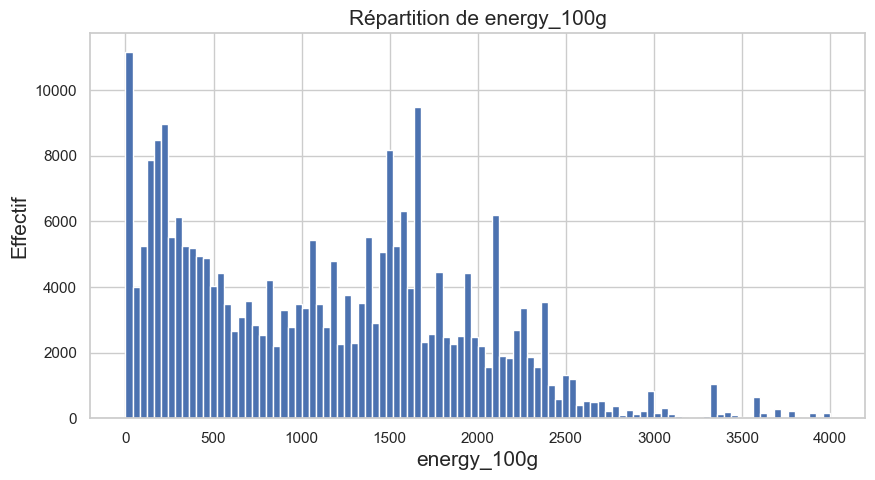

In [215]:
plt.figure(figsize=(10,5))
plt.hist(data2['energy_100g'], bins=100)
plt.title("Répartition de energy_100g", fontsize=15)
plt.ylabel("Effectif", fontsize=15) 
plt.xlabel("energy_100g", fontsize=15) 
plt.show()

#### <a name="C42110">4.2.1.10 Les vitamines</a>

In [216]:
liste = ['vitamin-a_100g','vitamin-c_100g','vitamin-b1_100g','vitamin-b6_100g','vitamin-b9_100g','vitamin-b12_100g','vitamin-d_100g','vitamin-pp_100g']
df_vitamines=data2[liste]

vitamin-a_100g
moy:
 0.0003965367301185726
med:
 0.0
mod:
 0    0.0
Name: vitamin-a_100g, dtype: float64
Ecart type:
 0.07327849867359977
Var:
 0.005369738367856763
Coefficient de variation CV : 184.7969165876178
count    137553.000000
mean          0.000397
std           0.073279
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000107
max          26.700000
Name: vitamin-a_100g, dtype: float64


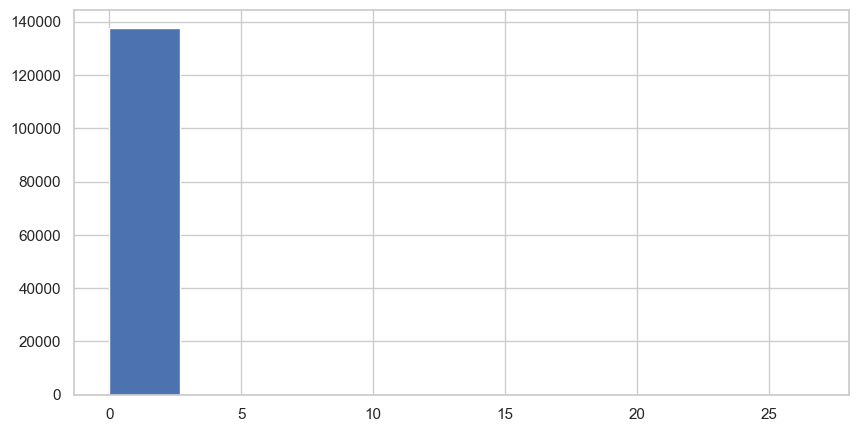

---------------------------------------
vitamin-c_100g
moy:
 0.01456305744872678
med:
 0.0
mod:
 0    0.0
Name: vitamin-c_100g, dtype: float64
Ecart type:
 0.4614214335162024
Var:
 0.21290973930814722
Coefficient de variation CV : 31.68449159711695
count    140863.000000
mean          0.014563
std           0.461423
min           0.000000
25%           0.000000
50%           0.000000
75%           0.003700
max         100.000000
Name: vitamin-c_100g, dtype: float64


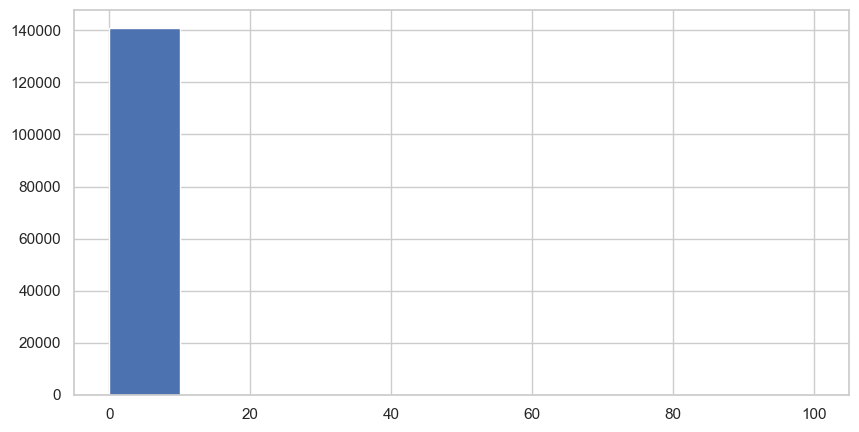

---------------------------------------
vitamin-b1_100g
moy:
 0.31116753599928276
med:
 0.012
mod:
 0    0.005
Name: vitamin-b1_100g, dtype: float64
Ecart type:
 1.9512160207423983
Var:
 3.807243959601799
Coefficient de variation CV : 6.2709096413262255
count    11153.000000
mean         0.311168
std          1.951304
min          0.000000
25%          0.004000
50%          0.012000
75%          0.402000
max         92.600000
Name: vitamin-b1_100g, dtype: float64


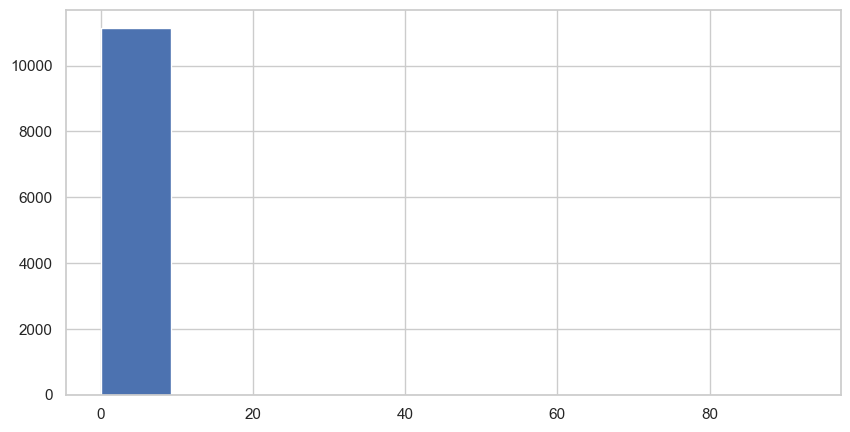

---------------------------------------
vitamin-b6_100g
moy:
 0.02337783710200472
med:
 0.0007
mod:
 0    0.001667
Name: vitamin-b6_100g, dtype: float64
Ecart type:
 1.2067328004527949
Var:
 1.456204051688645
Coefficient de variation CV : 51.6224723717423
count    6784.000000
mean        0.023378
std         1.206822
min         0.000000
25%         0.000255
50%         0.000700
75%         0.001500
max        92.600000
Name: vitamin-b6_100g, dtype: float64


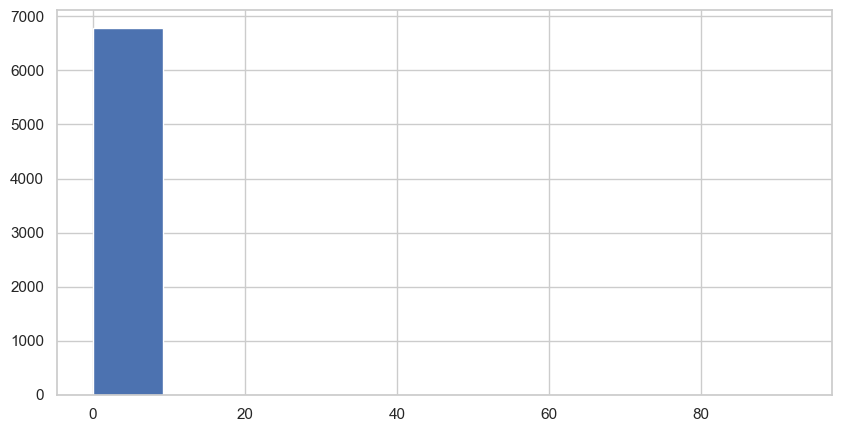

---------------------------------------
vitamin-b9_100g
moy:
 0.006897900683206107
med:
 5.2e-05
mod:
 0    0.000056
Name: vitamin-b9_100g, dtype: float64
Ecart type:
 0.3351315047462487
Var:
 0.11231312547348493
Coefficient de variation CV : 48.58920168813511
count    5240.000000
mean        0.006898
std         0.335163
min         0.000000
25%         0.000030
50%         0.000052
75%         0.000070
max        23.076923
Name: vitamin-b9_100g, dtype: float64


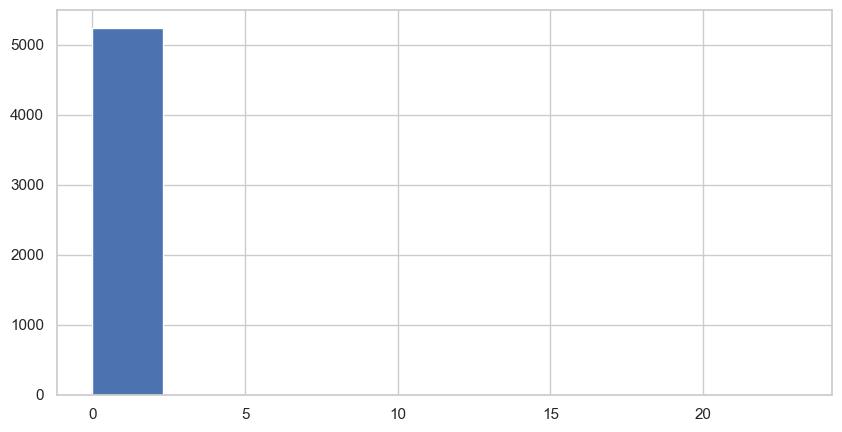

---------------------------------------
vitamin-b12_100g
moy:
 8.938695926603774e-05
med:
 1.92e-06
mod:
 0    0.000005
Name: vitamin-b12_100g, dtype: float64
Ecart type:
 0.0055142177085524885
Var:
 3.0406596937313853e-05
Coefficient de variation CV : 61.695106721139695
count    5.300000e+03
mean     8.938696e-05
std      5.514738e-03
min      0.000000e+00
25%      7.200000e-07
50%      1.920000e-06
75%      4.690000e-06
max      4.000000e-01
Name: vitamin-b12_100g, dtype: float64


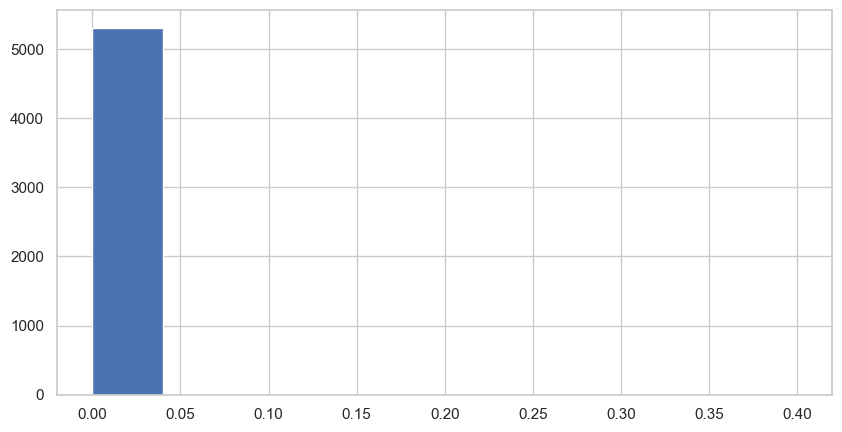

---------------------------------------
vitamin-d_100g
moy:
 7.956087116390893e-06
med:
 1.175e-06
mod:
 0    0.000001
Name: vitamin-d_100g, dtype: float64
Ecart type:
 0.0003592297398311044
Var:
 1.2904600597912294e-07
Coefficient de variation CV : 45.15475244202348
count    7071.000000
mean        0.000008
std         0.000359
min         0.000000
25%         0.000001
50%         0.000001
75%         0.000003
max         0.030000
Name: vitamin-d_100g, dtype: float64


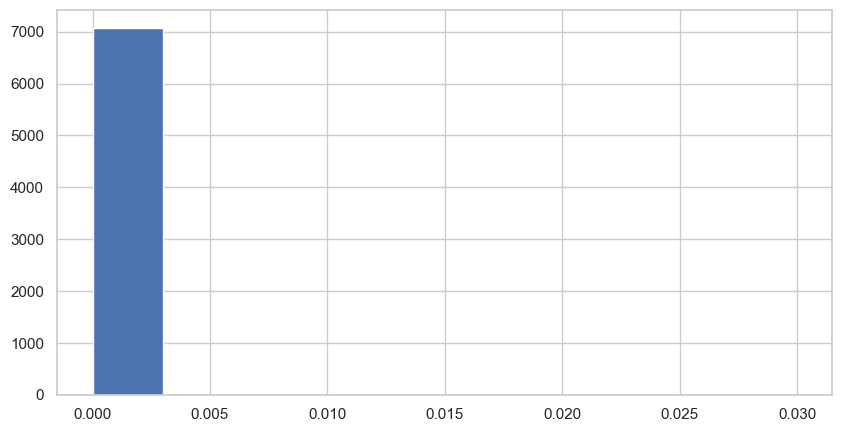

---------------------------------------
vitamin-pp_100g
moy:
 0.014782169161191225
med:
 0.005357
mod:
 0    0.007143
Name: vitamin-pp_100g, dtype: float64
Ecart type:
 0.2709637288550699
Var:
 0.07342134235504386
Coefficient de variation CV : 18.331226460246505
count    11719.000000
mean         0.014782
std          0.270975
min          0.000000
25%          0.003077
50%          0.005357
75%          0.009060
max         21.428571
Name: vitamin-pp_100g, dtype: float64


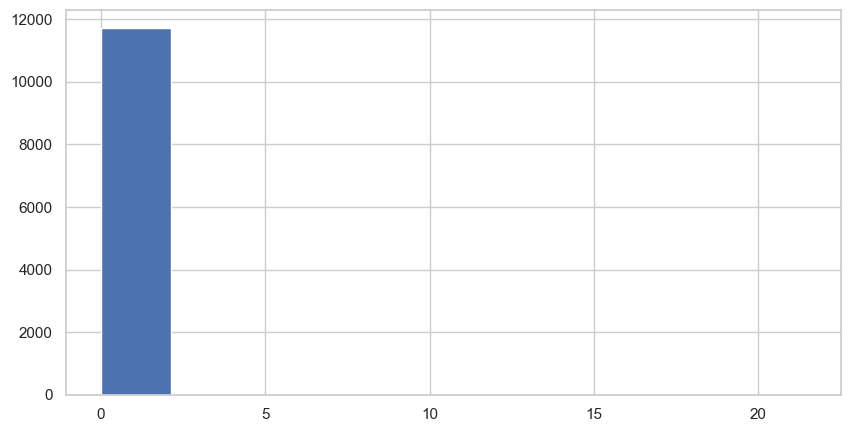

---------------------------------------


In [217]:
for ele in range(0, len(liste)):
    print(liste[ele])
    print("moy:\n",df_vitamines[liste[ele]].mean())
    print("med:\n",df_vitamines[liste[ele]].median())
    print("mod:\n",df_vitamines[liste[ele]].mode())
    #Mesure de dispersion :
    print("Ecart type:\n",df_vitamines[liste[ele]].std(ddof=0)) #Ecart type empirique
    print("Var:\n",df_vitamines[liste[ele]].var(ddof=0)) #Variance empirique
    print("Coefficient de variation CV :",df_vitamines[liste[ele]].std()/df_vitamines[liste[ele]].mean())
    
    df_tmp=df_vitamines[liste[ele]]
    print(df_tmp.describe())
    
    plt.figure(figsize=(10,5))
    plt.hist(df_vitamines[liste[ele]], bins=10) 
    plt.show()
    print("---------------------------------------")

#### <a name="C42111">4.2.1.11 Les 14 autres</a>

In [218]:
liste = ['ingredients_that_may_be_from_palm_oil_n','ingredients_from_palm_oil_n','additives_n','polyunsaturated-fat_100g','monounsaturated-fat_100g','phosphorus_100g','fruits-vegetables-nuts_100g','calcium_100g','folates_100g','potassium_100g','trans-fat_100g','cholesterol_100g','zinc_100g','iron_100g']
df_autres=data2[liste]


ingredients_that_may_be_from_palm_oil_n
moy:
 0.0552456007165781
med:
 0.0
mod:
 0    0.0
Name: ingredients_that_may_be_from_palm_oil_n, dtype: float64
Ecart type:
 0.26920214057202296
Var:
 0.0724697924885592
Coefficient de variation CV : 4.872834718658366
count    248961.000000
mean          0.055246
std           0.269203
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: ingredients_that_may_be_from_palm_oil_n, dtype: float64


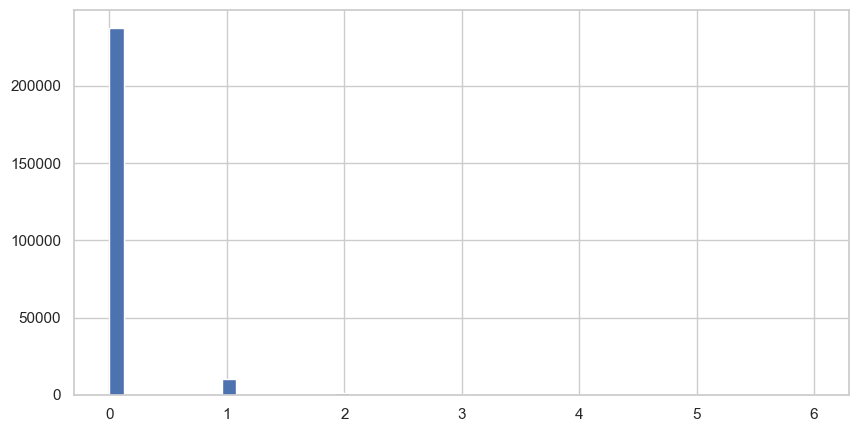

---------------------------------------
ingredients_from_palm_oil_n
moy:
 0.019657697390354313
med:
 0.0
mod:
 0    0.0
Name: ingredients_from_palm_oil_n, dtype: float64
Ecart type:
 0.14051776450765766
Var:
 0.019745242142229533
Coefficient de variation CV : 7.14824549012768
count    248961.000000
mean          0.019658
std           0.140518
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: ingredients_from_palm_oil_n, dtype: float64


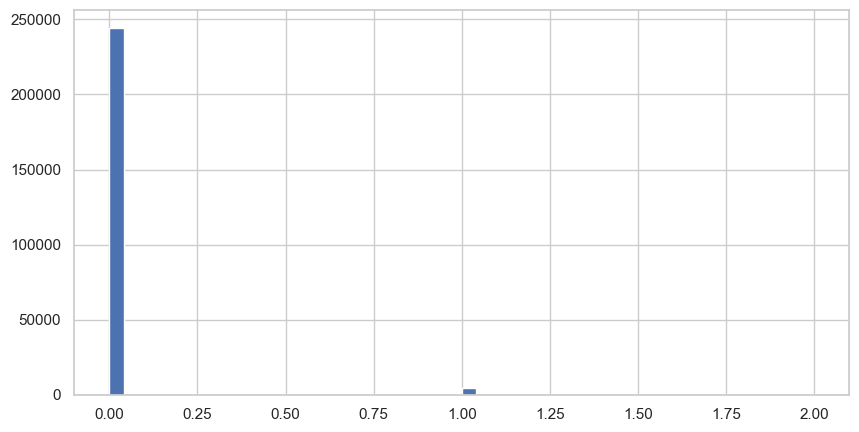

---------------------------------------
additives_n
moy:
 1.9363836102843417
med:
 1.0
mod:
 0    0.0
Name: additives_n, dtype: float64
Ecart type:
 2.502314306402249
Var:
 6.261576888025368
Coefficient de variation CV : 1.292264259334748
count    248961.000000
mean          1.936384
std           2.502319
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          31.000000
Name: additives_n, dtype: float64


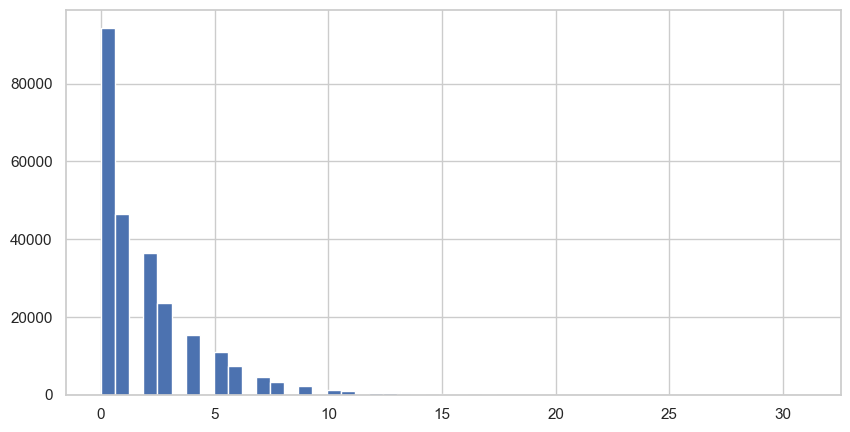

---------------------------------------
polyunsaturated-fat_100g
moy:
 6.312493433658515
med:
 2.22
mod:
 0    0.0
Name: polyunsaturated-fat_100g, dtype: float64
Ecart type:
 10.8323543060482
Var:
 117.33989981176099
Coefficient de variation CV : 1.7160558448364789
count    22859.000000
mean         6.312493
std         10.832591
min          0.000000
25%          0.000000
50%          2.220000
75%          7.140000
max         98.000000
Name: polyunsaturated-fat_100g, dtype: float64


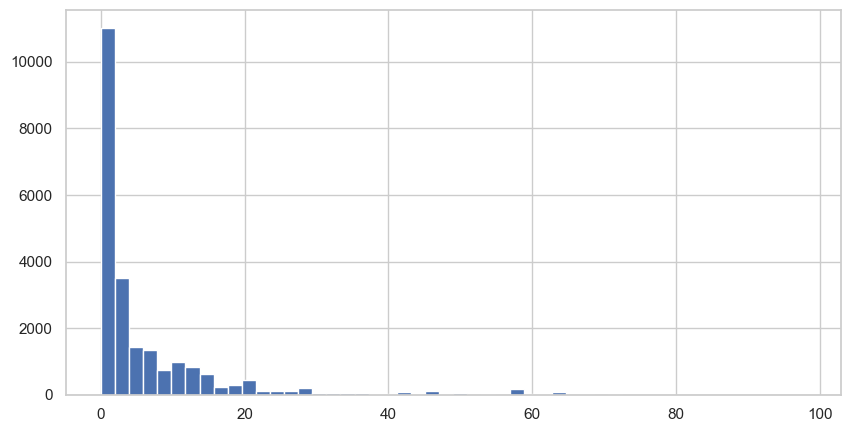

---------------------------------------
monounsaturated-fat_100g
moy:
 10.401099399702039
med:
 4.0
mod:
 0    0.0
Name: monounsaturated-fat_100g, dtype: float64
Ecart type:
 16.688259788529262
Var:
 278.49801476944276
Coefficient de variation CV : 1.6045059062548104
count    22822.000000
mean        10.401099
std         16.688625
min          0.000000
25%          0.000000
50%          4.000000
75%         10.710000
max        100.000000
Name: monounsaturated-fat_100g, dtype: float64


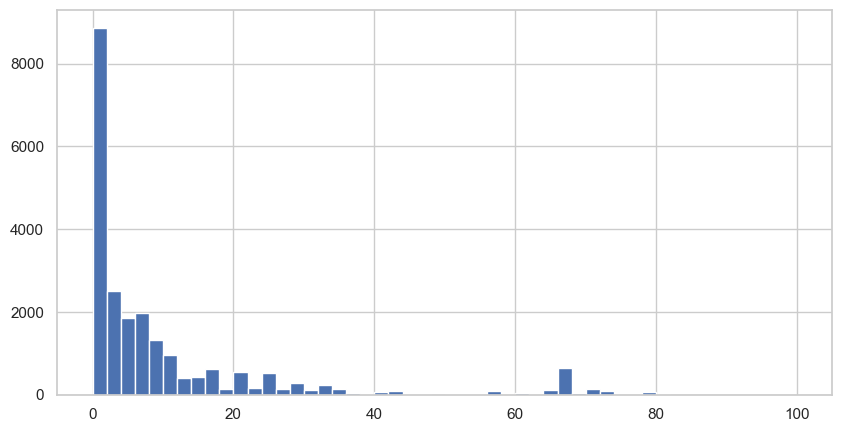

---------------------------------------
phosphorus_100g
moy:
 0.274336904109589
med:
 0.2045
mod:
 0    0.143
Name: phosphorus_100g, dtype: float64
Ecart type:
 1.1487549906508094
Var:
 1.3196380285451415
Coefficient de variation CV : 4.18774630166194
count    5840.000000
mean        0.274337
std         1.148853
min         0.000000
25%         0.094000
50%         0.204500
75%         0.357000
max        84.900000
Name: phosphorus_100g, dtype: float64


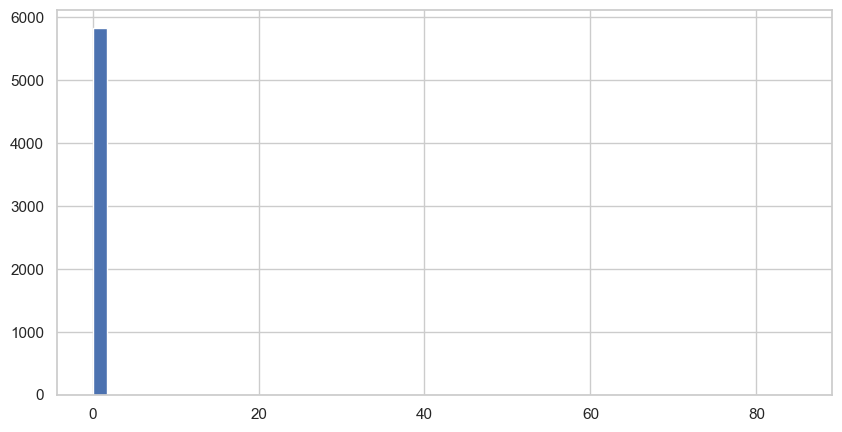

---------------------------------------
fruits-vegetables-nuts_100g
moy:
 31.376615233092586
med:
 22.1
mod:
 0    0.0
Name: fruits-vegetables-nuts_100g, dtype: float64
Ecart type:
 31.942454445388965
Var:
 1020.3203959957493
Coefficient de variation CV : 1.0182009386259971
count    3046.000000
mean       31.376615
std        31.947699
min         0.000000
25%         0.000000
50%        22.100000
75%        50.950000
max       100.000000
Name: fruits-vegetables-nuts_100g, dtype: float64


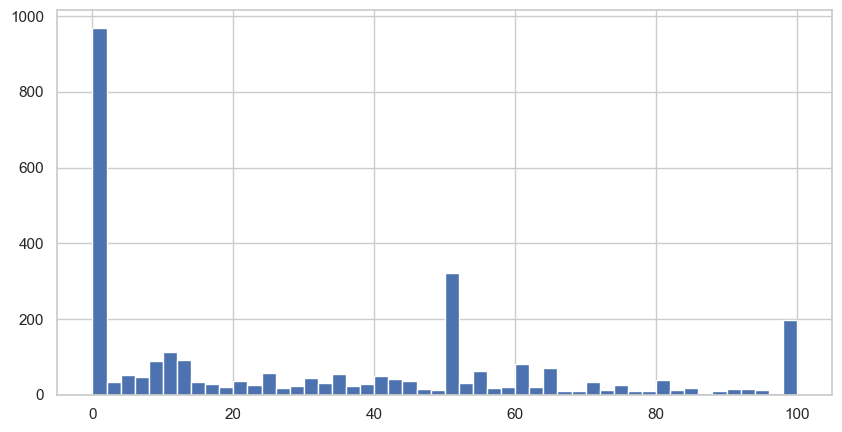

---------------------------------------
calcium_100g
moy:
 0.10202813011428087
med:
 0.035
mod:
 0    0.0
Name: calcium_100g, dtype: float64
Ecart type:
 0.585252599482799
Var:
 0.34252060520137345
Coefficient de variation CV : 5.736208959021278
count    141056.000000
mean          0.102028
std           0.585255
min           0.000000
25%           0.000000
50%           0.035000
75%           0.106000
max          99.006000
Name: calcium_100g, dtype: float64


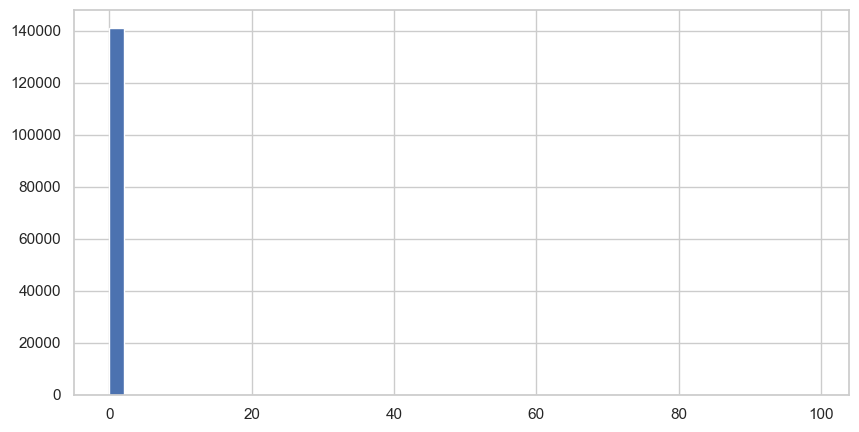

---------------------------------------
folates_100g
moy:
 0.05328302078644291
med:
 0.000114
mod:
 0    0.000214
Name: folates_100g, dtype: float64
Ecart type:
 1.449186857231345
Var:
 2.1001425471720627
Coefficient de variation CV : 27.202386918576117
count    3039.000000
mean        0.053283
std         1.449425
min         0.000000
25%         0.000042
50%         0.000114
75%         0.000214
max        57.142857
Name: folates_100g, dtype: float64


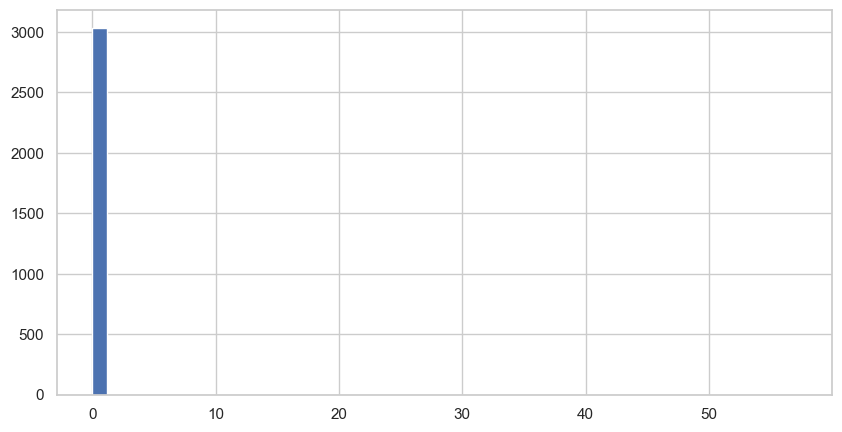

---------------------------------------
potassium_100g
moy:
 0.32484049614483135
med:
 0.18
mod:
 0    0.0
Name: potassium_100g, dtype: float64
Ecart type:
 1.065701192059456
Var:
 1.1357190307569451
Coefficient de variation CV : 3.2807569812170065
count    24746.000000
mean         0.324840
std          1.065723
min          0.000000
25%          0.107000
50%          0.180000
75%          0.341000
max         66.667000
Name: potassium_100g, dtype: float64


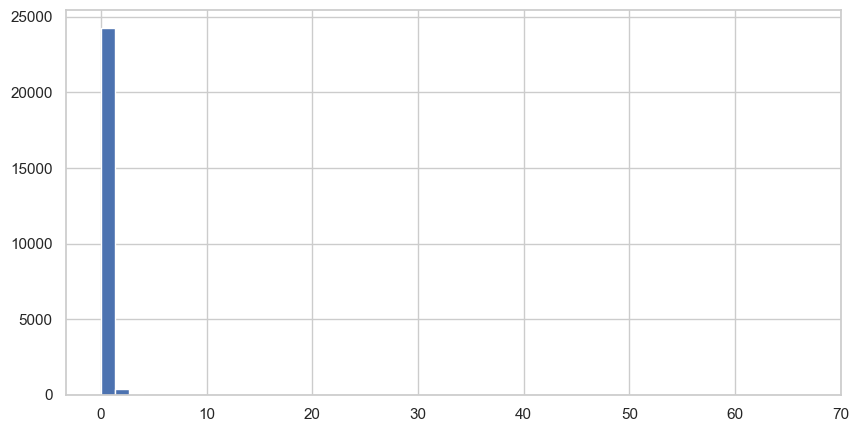

---------------------------------------
trans-fat_100g
moy:
 0.06717192401370659
med:
 0.0
mod:
 0    0.0
Name: trans-fat_100g, dtype: float64
Ecart type:
 0.9450165874474288
Var:
 0.8930563505507838
Coefficient de variation CV : 14.068673764075877
count    143289.000000
mean          0.067172
std           0.945020
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         100.000000
Name: trans-fat_100g, dtype: float64


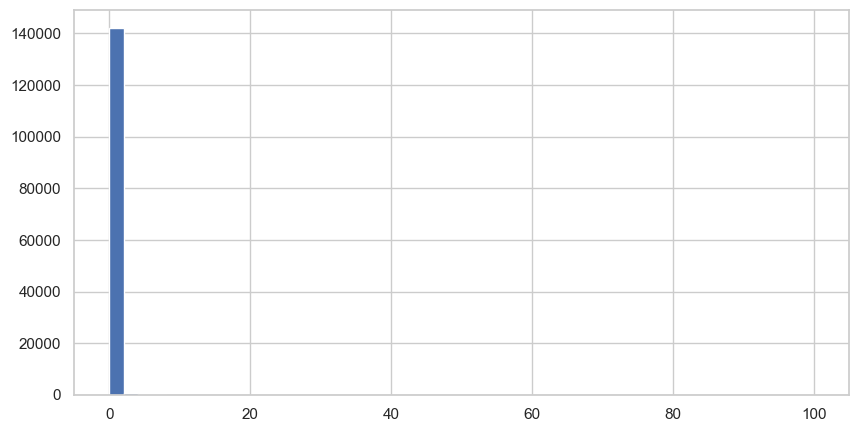

---------------------------------------
cholesterol_100g
moy:
 0.020071383336803385
med:
 0.0
mod:
 0    0.0
Name: cholesterol_100g, dtype: float64
Ecart type:
 0.35806036288404436
Var:
 0.12820722346865354
Coefficient de variation CV : 17.839408443889095
count    144090.000000
mean          0.020071
std           0.358062
min           0.000000
25%           0.000000
50%           0.000000
75%           0.020000
max          95.238000
Name: cholesterol_100g, dtype: float64


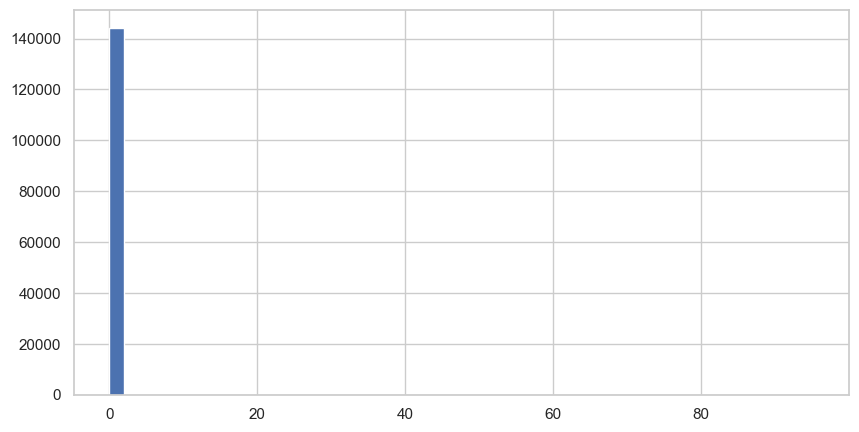

---------------------------------------
zinc_100g
moy:
 0.00795013922117587
med:
 0.0037
mod:
 0    0.0125
Name: zinc_100g, dtype: float64
Ecart type:
 0.08094240536608834
Var:
 0.006551672986448167
Coefficient de variation CV : 10.182552244384466
count    3929.000000
mean        0.007950
std         0.080953
min         0.000000
25%         0.001150
50%         0.003700
75%         0.007500
max         4.000000
Name: zinc_100g, dtype: float64


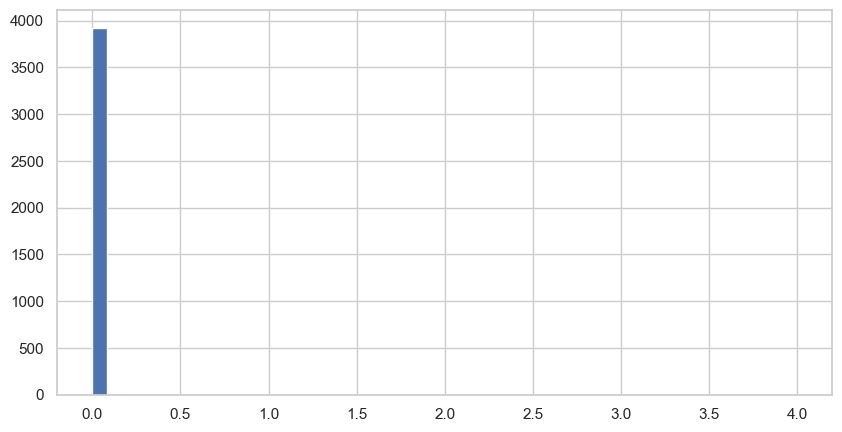

---------------------------------------
iron_100g
moy:
 0.0036525214993200976
med:
 0.00101
mod:
 0    0.0
Name: iron_100g, dtype: float64
Ecart type:
 0.21440808477252976
Var:
 0.0459708268158243
Coefficient de variation CV : 58.70159779934742
count    140461.000000
mean          0.003653
std           0.214409
min           0.000000
25%           0.000000
50%           0.001010
75%           0.002400
max          50.000000
Name: iron_100g, dtype: float64


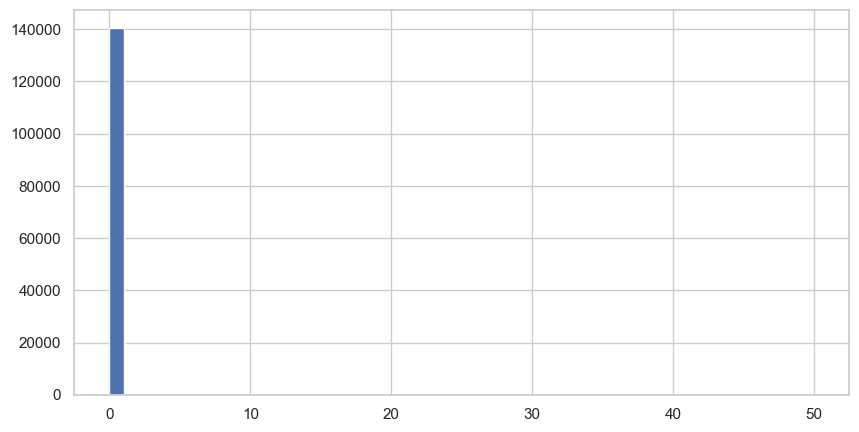

---------------------------------------


In [219]:
for ele in range(0, len(liste)):
    print(liste[ele])
    print("moy:\n",df_autres[liste[ele]].mean())
    print("med:\n",df_autres[liste[ele]].median())
    print("mod:\n",df_autres[liste[ele]].mode())
    #Mesure de dispersion :
    print("Ecart type:\n",df_autres[liste[ele]].std(ddof=0)) #Ecart type empirique
    print("Var:\n",df_autres[liste[ele]].var(ddof=0)) #Variance empirique
    print("Coefficient de variation CV :",df_autres[liste[ele]].std()/df_autres[liste[ele]].mean())
    
    df_tmp=df_autres[liste[ele]]
    print(df_tmp.describe())
    
    plt.figure(figsize=(10,5))
    plt.hist(df_autres[liste[ele]], bins=50) 
    plt.show()
    print("---------------------------------------")

### <a name="C422">4.2.2 Variables catégorielles </a>

#### <a name="C3221">4.2.2.1 nutrition_grade_fr </a>

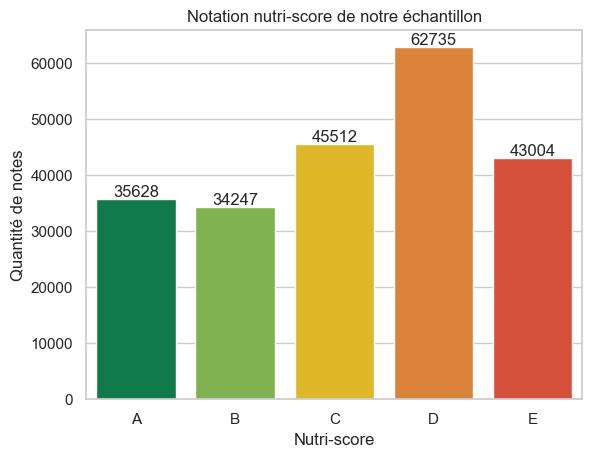

In [220]:
order = ['A', 'B', 'C', 'D', 'E']
comptage_nutrition_grade_fr = data2['nutrition_grade_fr'].value_counts()
ax=sns.barplot(x=comptage_nutrition_grade_fr.index, y=comptage_nutrition_grade_fr.values, order=order, palette=sns.blend_palette(['#008B4C', '#7FC241' ,'#FECA0A', '#F58220','#EF3E22'],5))
plt.xlabel("Nutri-score")
plt.ylabel("Quantité de notes")
plt.title("Notation nutri-score de notre échantillon")
for i in ax.containers:
    ax.bar_label(i,)

Notre échantillion est composé de 221126 nutri-scores renseignés; soit 68.94 % de l'effectif total


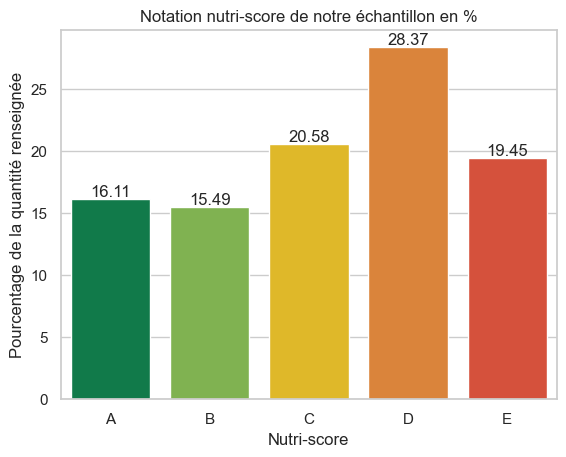

In [221]:
order = ['A', 'B', 'C', 'D', 'E']
comptage_nutrition_grade_fr = data2['nutrition_grade_fr'].value_counts()
nb_non_vide=data2['nutrition_grade_fr'].notnull().sum()
print("Notre échantillion est composé de", nb_non_vide, "nutri-scores renseignés; soit",round((nb_non_vide/data2.shape[0])*100,2),"% de l'effectif total")
ax=sns.barplot(x=comptage_nutrition_grade_fr.index, y=np.around(((comptage_nutrition_grade_fr.values)/nb_non_vide)*100, 2), order=order, palette=sns.blend_palette(['#008B4C', '#7FC241' ,'#FECA0A', '#F58220','#EF3E22'],5))
plt.xlabel("Nutri-score")
plt.ylabel("Pourcentage de la quantité renseignée")
plt.title("Notation nutri-score de notre échantillon en %")
for i in ax.containers:
    ax.bar_label(i,)

On remarque que les nutri-scores "A" et "B" puis "C" et "E" ont une proportion équivalente. Le nutriscore D représente la part la plus importante de l'effectif 28.37%

## <a name="C43">4.3 Bilan </a>

# 5. APPLICATION

## <a name="C5.1">5.1 Création du modèle </a>

### <a name="C511">5.1.1 K-Means et classification hiérarchique </a>

#### <a name="C5111">5.1.1.1 Détection du nombre de clusters idéal </a>

In [222]:
#Extraction de 80% de la dataframe
train, test = train_test_split(df_list_num_partitionnement, test_size = 0.2, random_state=9)



In [223]:
train.shape

(162713, 15)

In [224]:
# Une liste vide pour enregistrer les inerties :  
intertia_list = []

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(train)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)

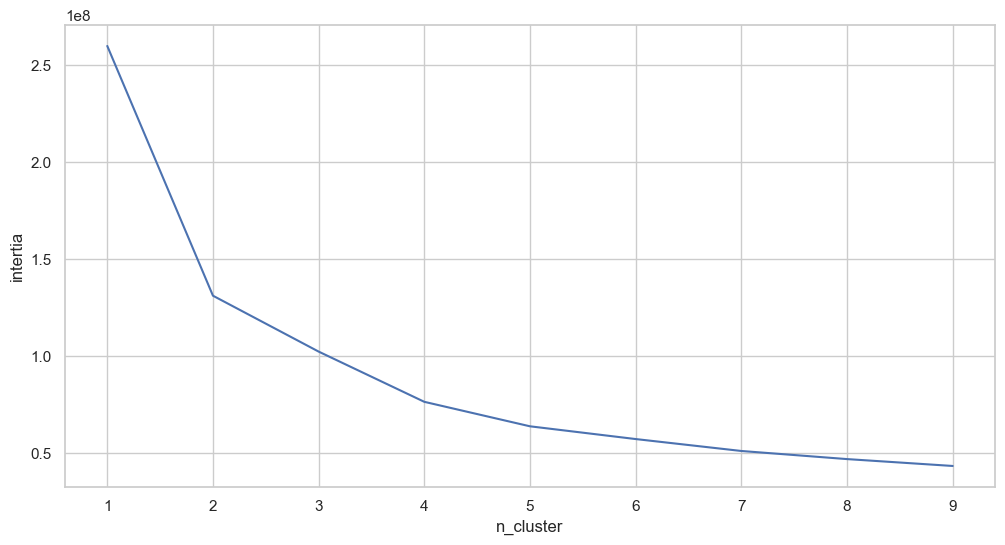

In [225]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, intertia_list)

In [226]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(train)

KMeans(n_clusters=5)

In [227]:
#Ajout des clusters à la df train en la copiant avant
train_cluster=train.copy()
kmeans.labels_
train_cluster["cluster"] = kmeans.labels_
train_cluster.head()

fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
208328      2.00                0.00                4.50         2.00   
49550       0.77                0.00               16.15         0.77   
65063      32.14               17.86                7.14         0.00   
41550      32.14                7.14               53.57         0.00   
39293       0.00                0.00                3.25         3.25   

        fiber_100g  proteins_100g  salt_100g  vitamin-a_100g  vitamin-c_100g  \
208328         1.5           1.00    0.60000        0.000000          0.0000   
49550          4.6           5.38    0.93726        0.000000          0.0000   
65063          0.0          21.43    1.63322        0.000321          0.0000   
41550          3.6           7.14    2.17678        0.000000          0.0214   
39293          0.8           1.63    0.07112        0.000305          0.0171   

        vitamin-b1_100g  vitamin-b6_100g  vitamin-b9_100g  vitamin-b12_100g  \
208328              0.0              0.0              0.0               0.0   
49550               0.0              0.0              0.0               0.0   
65063               0.0              0.0              0.0               0.0   
41550               0.0              0.0              0.0               0.0   
39293               0.0              0.0              0.0               0.0   

        vitamin-d_100g  vitamin-pp_100g  cluster  
208328             0.0              0.0        0  
49550              0.0              0.0        0  
65063              0.0              0.0        3  
41550              0.0              0.0        4  
39293              0.0              0.0        0

In [228]:
train_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162713 entries, 208328 to 110509
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fat_100g            162713 non-null  float64
 1   saturated-fat_100g  162713 non-null  float64
 2   carbohydrates_100g  162713 non-null  float64
 3   sugars_100g         162713 non-null  float64
 4   fiber_100g          162713 non-null  float64
 5   proteins_100g       162713 non-null  float64
 6   salt_100g           162713 non-null  float64
 7   vitamin-a_100g      162713 non-null  float64
 8   vitamin-c_100g      162713 non-null  float64
 9   vitamin-b1_100g     162713 non-null  float64
 10  vitamin-b6_100g     162713 non-null  float64
 11  vitamin-b9_100g     162713 non-null  float64
 12  vitamin-b12_100g    162713 non-null  float64
 13  vitamin-d_100g      162713 non-null  float64
 14  vitamin-pp_100g     162713 non-null  float64
 15  cluster             162713 no

Visualisation de la distribution des clusters sur les 7 variables principales :

In [229]:
df_tmp=train_cluster.loc[:,['fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g', 'fiber_100g','proteins_100g','salt_100g','cluster']]
#sns.pairplot(df_tmp, hue="cluster")

In [230]:
# Stockage des clusters dans une variable labels : 
labels = kmeans.labels_

TEST de correlation entre cluster et grade

In [231]:
#Comparaison du cluster de la note réelle
train_cluster_grade=train_cluster.copy()

if "nutrition_grade_fr_2" not in list_variables :
    train_cluster_grade["nutrition_grade_fr_2"]= np.nan
    train_cluster_grade = train_cluster_grade.astype({'nutrition_grade_fr_2': float})
    for index in train_cluster_grade.index:
         train_cluster_grade.loc[index, 'nutrition_grade_fr_2']=  data3.loc[index, 'nutrition_grade_fr_2']


In [232]:
train_cluster_grade.head()

fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
208328      2.00                0.00                4.50         2.00   
49550       0.77                0.00               16.15         0.77   
65063      32.14               17.86                7.14         0.00   
41550      32.14                7.14               53.57         0.00   
39293       0.00                0.00                3.25         3.25   

        fiber_100g  proteins_100g  salt_100g  vitamin-a_100g  vitamin-c_100g  \
208328         1.5           1.00    0.60000        0.000000          0.0000   
49550          4.6           5.38    0.93726        0.000000          0.0000   
65063          0.0          21.43    1.63322        0.000321          0.0000   
41550          3.6           7.14    2.17678        0.000000          0.0214   
39293          0.8           1.63    0.07112        0.000305          0.0171   

        vitamin-b1_100g  vitamin-b6_100g  vitamin-b9_100g  vitamin-b12_100g  \
208328              0.0              0.0              0.0               0.0   
49550               0.0              0.0              0.0               0.0   
65063               0.0              0.0              0.0               0.0   
41550               0.0              0.0              0.0               0.0   
39293               0.0              0.0              0.0               0.0   

        vitamin-d_100g  vitamin-pp_100g  cluster  nutrition_grade_fr_2  
208328             0.0              0.0        0                   1.0  
49550              0.0              0.0        0                   0.0  
65063              0.0              0.0        3                   4.0  
41550              0.0              0.0        4                   3.0  
39293              0.0              0.0        0                   0.0

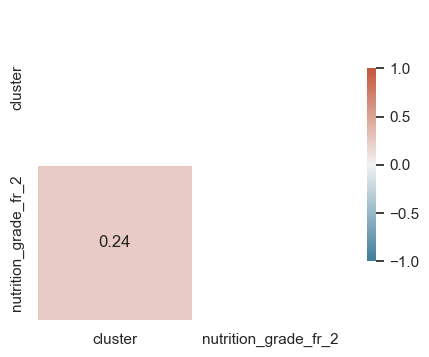

In [233]:
corr = train_cluster_grade[['cluster','nutrition_grade_fr_2']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": 0.5});

In [234]:
train_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162713 entries, 208328 to 110509
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fat_100g            162713 non-null  float64
 1   saturated-fat_100g  162713 non-null  float64
 2   carbohydrates_100g  162713 non-null  float64
 3   sugars_100g         162713 non-null  float64
 4   fiber_100g          162713 non-null  float64
 5   proteins_100g       162713 non-null  float64
 6   salt_100g           162713 non-null  float64
 7   vitamin-a_100g      162713 non-null  float64
 8   vitamin-c_100g      162713 non-null  float64
 9   vitamin-b1_100g     162713 non-null  float64
 10  vitamin-b6_100g     162713 non-null  float64
 11  vitamin-b9_100g     162713 non-null  float64
 12  vitamin-b12_100g    162713 non-null  float64
 13  vitamin-d_100g      162713 non-null  float64
 14  vitamin-pp_100g     162713 non-null  float64
 15  cluster             162713 no

<AxesSubplot: title={'center': "'Prédiction du modèle vs score réel (ordonnées)'"}, xlabel='cluster', ylabel='nutrition_grade_fr_2'>

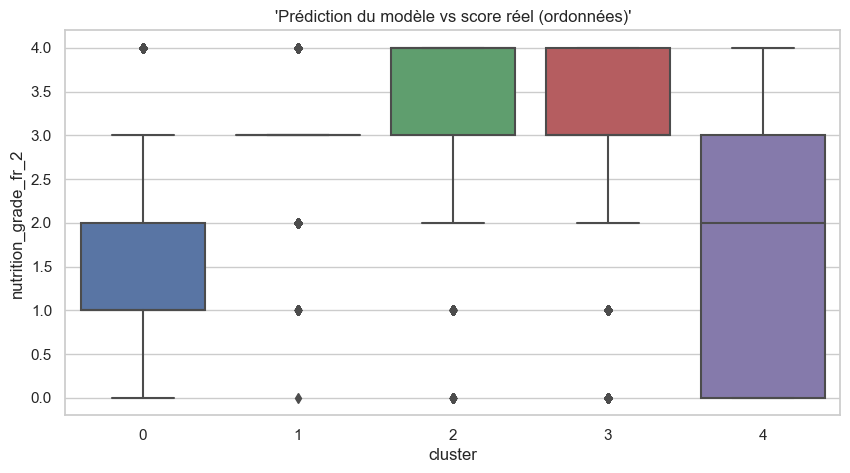

In [235]:

plt.figure(figsize=(10, 5))
plt.title("'Prédiction du modèle vs score réel (ordonnées)'")
sns.set(style="whitegrid")
#plt.xticks([-15, -10,-5,0,5,10,15,20,25,30.,35,40])
#meanprops = {'marker':'o', 'markeredgecolor':'black',
           # 'markerfacecolor':'firebrick'}
sns.boxplot(x='cluster', y='nutrition_grade_fr_2', data=train_cluster_grade)
#sns.boxplot(x='nutrition-score-fr_100g', y='cluster', data=train_cluster)

#### <a name="C5112">5.1.1.2 Calcul des centroides et projection via PCA sur quelques axes </a>

In [236]:
# On peut stocker nos centroids dans une variable : 
centroids = kmeans.cluster_centers_
centroids

array([[4.77764779e+00, 1.71639816e+00, 1.16185855e+01, 5.83168576e+00,
        1.18308300e+00, 6.01483594e+00, 1.26701395e+00, 9.51234785e-05,
        5.46374629e-03, 3.11127213e-03, 3.81950342e-05, 4.71437614e-04,
        4.99956067e-07, 6.40488303e-08, 1.47210003e-04],
       [3.92995128e+00, 2.00392203e+00, 8.02088419e+01, 6.19754024e+01,
        1.80208333e+00, 2.55507939e+00, 5.06699530e-01, 7.72795428e-05,
        1.04636196e-02, 1.85866401e-02, 1.73286874e-04, 5.00211431e-05,
        1.97437919e-07, 2.02893181e-07, 8.83515648e-04],
       [2.26352686e+01, 1.09466123e+01, 5.46660508e+01, 3.67371749e+01,
        2.94635015e+00, 6.25493760e+00, 7.10347819e-01, 5.99097480e-05,
        1.87585804e-03, 7.82730510e-03, 2.70591437e-04, 8.45143336e-06,
        5.85673864e-08, 6.35744602e-08, 5.15123716e-04],
       [4.14191260e+01, 1.37496792e+01, 9.21038673e+00, 3.01239341e+00,
        2.59016580e+00, 1.61425602e+01, 1.56341615e+00, 1.09843369e-04,
        1.28909073e-03, 4.44351412e-0

In [237]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train)

In [238]:
pca = PCA(n_components=5)
pca.fit(X_scaled)

PCA(n_components=5)

In [239]:
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2", "PC3","PC4", "PC5" ])
X_proj[:10]

PC1       PC2       PC3       PC4       PC5
0  0.608620  1.428708 -0.408410  0.190390  0.130879
1  0.467308  1.132796  0.141861 -0.542054 -0.045141
2 -2.838892  0.181544 -0.037444  0.499999  0.046697
3 -0.834355 -0.484904  0.122580 -0.154593 -0.157314
4  0.674882  1.498138 -0.185518  0.512436 -0.024983
5 -1.304164  1.135267 -0.178608  0.006087  0.152259
6 -0.600833 -2.746145 -0.749826  0.856236  0.051192
7  0.328608  0.936885 -0.243628  0.015030  0.047933
8  0.718479  1.620476 -0.603990  0.443175  0.199529
9  0.809451 -0.476034  6.021662  0.268240  3.068764

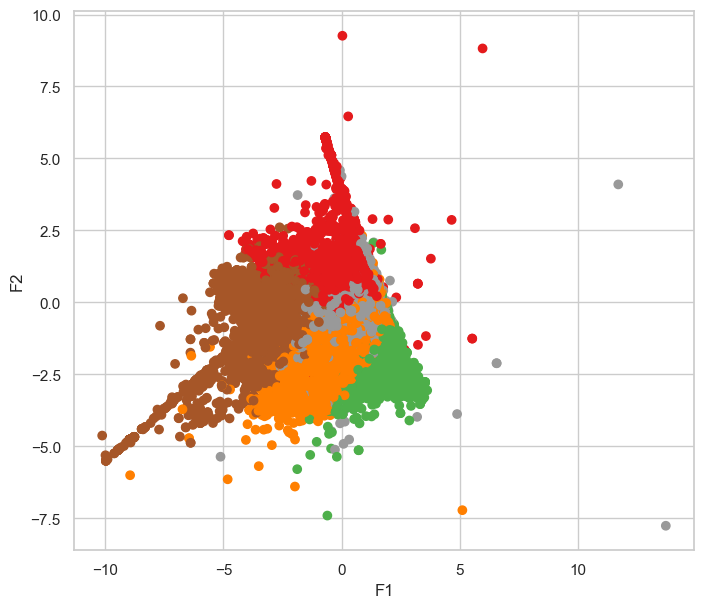

In [240]:
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1")
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.show()

In [241]:
# On utilise bien le scaler déjà entrainé : 

centroids_proj = scaler.transform(centroids)

C:\Users\Utilisateur\anaconda3\envs\projet3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [242]:
centroids_proj=pd.DataFrame(centroids_proj)

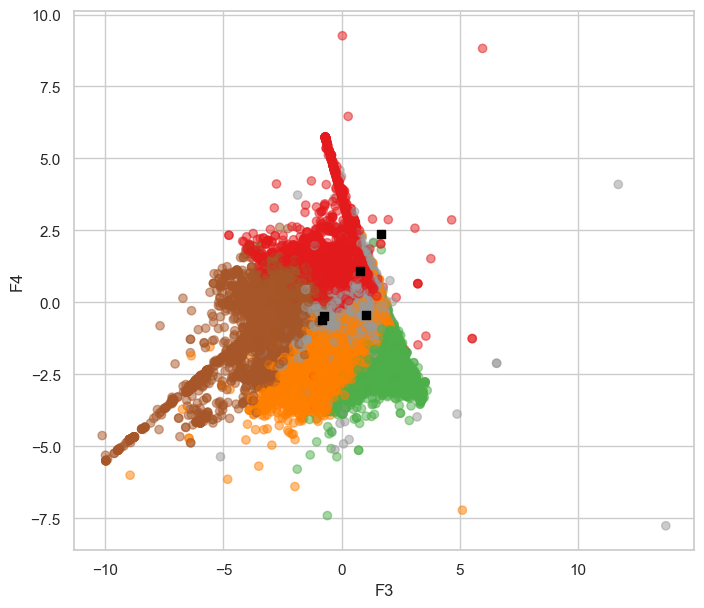

In [243]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha =0.5)

# On affiche nos centroides, avec une couleur noire (c="black") et une frome de carré (marker="c") : 
ax.scatter(centroids_proj.iloc[:, 2], centroids_proj.iloc[:, 3],  marker="s", c="black" )

# On spécifie les axes x et y :
ax.set_xlabel("F3")
ax.set_ylabel("F4")
plt.show()

In [244]:
# On définit notre figure et notre axe différemment : 
#fig= plt.figure(1, figsize=(8, 6))
#ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

# On affiche nos points : 
#ax.scatter(
#    X_proj.iloc[:, 0],
#    X_proj.iloc[:, 1],
#    X_proj.iloc[:, 2],
#    c=labels, cmap="Set1", edgecolor="k", s=40)

# On spécifie le nom des axes : 
#ax.set_xlabel("F1")
#ax.set_ylabel("F2")
#ax.set_zlabel("F3")


In [245]:
#fig = px.scatter_3d(x=X_proj.iloc[:,0], y=X_proj.iloc[:,1], z=X_proj.iloc[:, 2],color=labels)
#fig.show()

#### <a name="C5113">5.1.1.3 Classification hiérarchique à partir des centroides </a>

In [246]:
centroids_proj

0         1         2         3         4         5         6   \
0 -0.531536 -0.433537 -0.762706 -0.465284 -0.309227 -0.217136  0.010923   
1 -0.584285 -0.394160  1.662050  2.381887 -0.161088 -0.650330 -0.189392   
2  0.579666  0.830555  0.759078  1.102001  0.112756 -0.187073 -0.135738   
3  1.748505  1.214439 -0.847839 -0.608256  0.027514  1.050949  0.089014   
4 -0.192560 -0.366343  1.045177 -0.450276  0.695546  0.242910  0.113883   

         7         8         9         10        11        12        13  \
0  0.009390  0.006710 -0.041196 -0.006135  0.004187  0.002182 -0.024064   
1 -0.019259  0.052245  0.016540  0.004486 -0.002819 -0.001392  0.106074   
2 -0.047147 -0.025966 -0.023602  0.012136 -0.003510 -0.003032 -0.024508   
3  0.033023 -0.031310 -0.036226 -0.007082 -0.003244 -0.003634 -0.002676   
4  0.004906  0.006522  0.138676  0.006945 -0.003549  0.000536  0.037091   

         14  
0 -0.014387  
1  0.016198  
2  0.000896  
3 -0.013084  
4  0.036138

In [247]:
#Récupération des index
names = centroids_proj.index

#Opération de centrage réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(centroids_proj)
X_scaled
  

array([[-0.83857811, -0.85424747, -1.12903757, -0.72932496, -1.11101352,
        -0.46031421,  0.27496571,  0.48396894,  0.16977633, -0.77596805,
        -1.09256948,  1.9924348 ,  1.49320639, -0.86198697, -1.02565924],
       [-0.89871961, -0.79853105,  1.28540956,  1.69283386, -0.68053496,
        -1.21278636, -1.38480727, -0.56584134,  1.69471571,  0.08502157,
         0.32168667, -0.34415292, -0.14883733,  1.78075573,  0.57984159],
       [ 0.42836603,  0.93438499,  0.38627721,  0.60400328,  0.11523576,
        -0.40809383, -0.94024129, -1.58775653, -0.9245138 , -0.51358622,
         1.3403535 , -0.57464052, -0.90261521, -0.87101606, -0.2234302 ],
       [ 1.76102386,  1.47756376, -1.21380863, -0.8509552 , -0.13246965,
         1.74239291,  0.92201427,  1.34998262, -1.10347525, -0.70184726,
        -1.21857518, -0.48584161, -1.1789726 , -0.42765744, -0.95726219],
       [-0.45209217, -0.75917023,  0.67115942, -0.71655699,  1.80878237,
         0.33880148,  1.12806857,  0.31964632, 

In [248]:
pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]

0     1     2     3     4     5     6     7     8     9     10    11  \
mean  0.00  0.00 -0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  0.00 -0.00 -0.00   
std   1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12   

        12    13    14  
mean -0.00  0.00 -0.00  
std   1.12  1.12  1.12

In [249]:
  Z = linkage(X_scaled, method="ward")
  Z[:10]

array([[1.        , 2.        , 5.08288279, 2.        ],
       [4.        , 5.        , 5.82205558, 3.        ],
       [0.        , 3.        , 5.85778355, 2.        ],
       [6.        , 7.        , 7.48026359, 5.        ]])

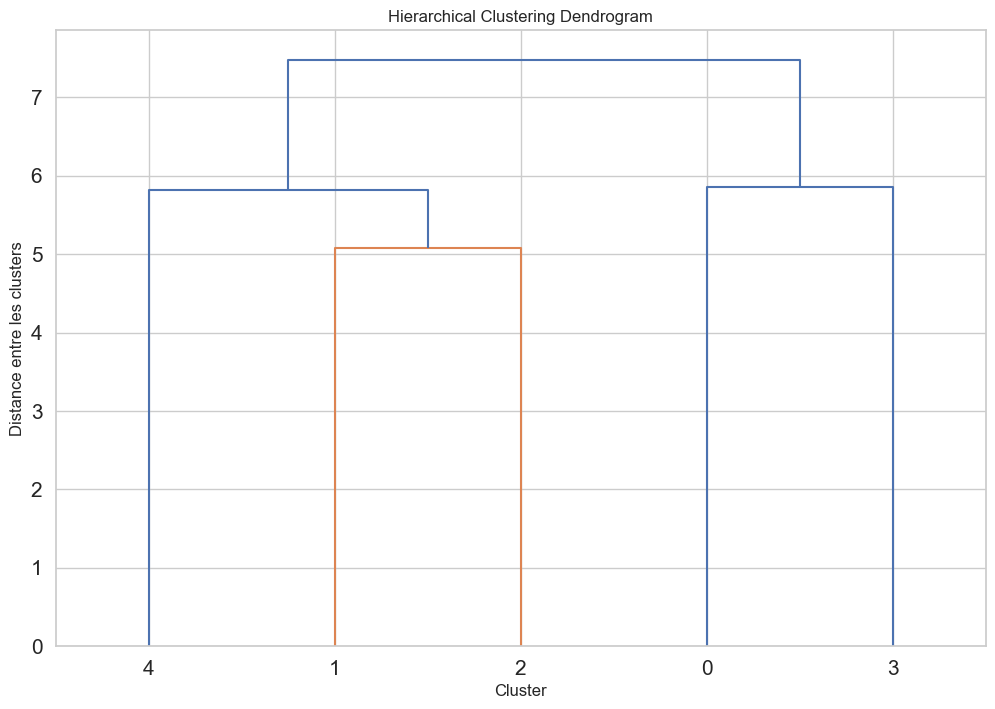

In [250]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

_ = dendrogram(Z,p=10, ax=ax, labels=names,truncate_mode="lastp", orientation = "top")

plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Cluster")
ax.set_ylabel("Distance entre les clusters")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

### <a name="C512">5.1.2 KNN </a>

In [251]:
df_list_num2=df_list_num.copy()
df_list_num2.rename(columns={'saturated-fat_100g':'saturated_fat_100g',

                                           'vitamin-b1_100g':'vitamin_b1_100g',
                                           'vitamin-d_100g':'vitamin_d_100g',
                                           'vitamin-b9_100g':'vitamin_b9_100g',
                                           'vitamin-pp_100g':'vitamin_pp_100g',
                                           'vitamin-c_100g':'vitamin_c_100g',
                                           'vitamin-b6_100g' : 'vitamin_b6_100g',
                                           'vitamin-a_100g':'vitamin_a_100g',
                                           'vitamin-b12_100g':'vitamin_b12_100g'}, inplace=True)
critere=['fat_100g', 'saturated_fat_100g', 'carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','vitamin_a_100g','vitamin_c_100g','vitamin_b1_100g','vitamin_b6_100g','vitamin_b9_100g','vitamin_b12_100g','vitamin_d_100g','vitamin_pp_100g']
recherche=['nutrition-score-fr_100g']

In [252]:
#xtrain, xtest, ytrain, ytest = train_test_split(df_list_num2, df_list_num[["nutrition-score-fr_100g"]], test_size=0.2,random_state=9)
xtrain, xtest, ytrain, ytest = train_test_split(df_list_num2[critere], df_list_num2[recherche], test_size=0.2,random_state=9)

In [253]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=2)
knn.fit(xtrain, ytrain)

C:\Users\Utilisateur\anaconda3\envs\projet3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=2)

In [254]:
error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.468202


C:\Users\Utilisateur\anaconda3\envs\projet3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Utilisateur\anaconda3\envs\projet3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Utilisateur\anaconda3\envs\projet3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Utilisateur\anaconda3\envs\projet3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was

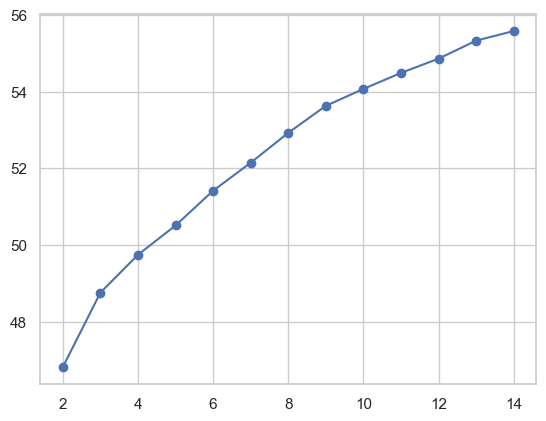

In [255]:
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [256]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(2)
knn.fit(xtrain, ytrain)

# On récupère les prédictions sur les données test
predicted = knn.predict(xtest)



C:\Users\Utilisateur\anaconda3\envs\projet3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [257]:
predicted=pd.DataFrame(predicted)
predicted.head()

0
0  10.0
1  19.0
2  16.0
3  20.0
4  14.0

In [258]:
ytest.head()

nutrition-score-fr_100g
28030                      13.0
318352                     19.0
257016                     15.0
47119                      20.0
122823                     14.0

In [259]:
#Merge des 2 DF
predicted_cc=predicted.copy()
predicted_cc.columns = ['predict']

ytest_cc=ytest.copy()
ytest_cc.reset_index(drop=True,inplace=True)
ytest_cc.head()
#Merge des 2 dataframes
df = predicted_cc.merge(ytest_cc, how='inner', left_index=True, right_index=True)

df.head()

predict  nutrition-score-fr_100g
0     10.0                     13.0
1     19.0                     19.0
2     16.0                     15.0
3     20.0                     20.0
4     14.0                     14.0

In [260]:
#Affichage des résulats de notre prédiction
df_tmp=df.groupby(['nutrition-score-fr_100g','predict']).size().reset_index() #agrégation 
df_tmp.head()

nutrition-score-fr_100g  predict  0
0                    -14.0     -9.0  1
1                    -14.0     -8.0  1
2                    -13.0    -13.0  2
3                    -13.0    -12.0  1
4                    -13.0    -10.0  1

### <a name="C513">5.1.3 Régression linéaire </a>

In [261]:
df_list_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203392 entries, 1 to 320745
Data columns (total 34 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   salt_100g                                203392 non-null  float64
 1   proteins_100g                            203392 non-null  float64
 2   sugars_100g                              203392 non-null  float64
 3   carbohydrates_100g                       203392 non-null  float64
 4   nutrition-score-fr_100g                  203392 non-null  float64
 5   saturated-fat_100g                       203392 non-null  float64
 6   fat_100g                                 203392 non-null  float64
 7   energy_100g                              203392 non-null  float64
 8   nutrition_grade_fr_2                     203392 non-null  float64
 9   ingredients_that_may_be_from_palm_oil_n  203392 non-null  float64
 10  ingredients_from_palm_oil_n     

In [262]:
#Je creer une nouelle list_num pour la manipuler sans toucher l'originale
df_list_num2=df_list_num.copy()


In [263]:
df_list_num2.rename(columns={'saturated-fat_100g':'saturated_fat_100g',

                                           'vitamin-b1_100g':'vitamin_b1_100g',
                                           'vitamin-d_100g':'vitamin_d_100g',
                                           'vitamin-b9_100g':'vitamin_b9_100g',
                                           'vitamin-pp_100g':'vitamin_pp_100g',
                                           'vitamin-c_100g':'vitamin_c_100g',
                                           'vitamin-b6_100g' : 'vitamin_b6_100g',
                                           'vitamin-a_100g':'vitamin_a_100g',
                                           'vitamin-b12_100g':'vitamin_b12_100g'}, inplace=True)

In [264]:
critere=['fat_100g', 'saturated_fat_100g', 'carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','vitamin_a_100g','vitamin_c_100g','vitamin_b1_100g','vitamin_b6_100g','vitamin_b9_100g','vitamin_b12_100g','vitamin_d_100g','vitamin_pp_100g']
recherche=['nutrition-score-fr_100g']#prendre le score car la régression ne se fait jamais pour des valeurs discretes

#test : tester le modèle avec "energy_100g" au lieu de ses 6 variables constituantes:
#critere=['energy_100g','salt_100g','vitamin_a_100g','vitamin_c_100g','vitamin_b1_100g','vitamin_b6_100g','vitamin_b9_100g','vitamin_b12_100g','vitamin_d_100g','vitamin_pp_100g']

#test : tester le modèle avec "energy_100g" + ses 6 variables constituantes:
#critere=['energy_100g','fat_100g', 'saturated_fat_100g', 'carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','vitamin_a_100g','vitamin_c_100g','vitamin_b1_100g','vitamin_b6_100g','vitamin_b9_100g','vitamin_b12_100g','vitamin_d_100g','vitamin_pp_100g']

#test : tester le modèle sans les vitamines
#critere=['fat_100g', 'saturated_fat_100g', 'carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g']


In [265]:
xtrain, xtest, ytrain, ytest = train_test_split(df_list_num2[critere], df_list_num2[recherche], test_size=0.2,random_state=9)

In [266]:
#Création de l'Excel pour récupération des fichier pour mon appli
xtrain.to_excel("xtrain.xlsx", sheet_name="xtrain", index=True)
ytrain.to_excel("ytrain.xlsx", sheet_name="ytrain", index=True)
#xtest.to_excel("xtest.xlsx", sheet_name="xtest", index=True)
#ytest.to_excel("ytest.xlsx", sheet_name="xtest", index=True)

In [267]:
lr = LinearRegression()
lr_baseline = lr.fit(xtrain, ytrain)
baseline_pred = lr_baseline.predict(xtest)

In [268]:
xtest.head()

fat_100g  saturated_fat_100g  carbohydrates_100g  sugars_100g  \
28030      53.57                8.93               25.00         3.57   
318352      1.60                1.60               95.00        95.00   
257016     17.00                5.40                0.50         0.10   
47119      46.67                6.67                6.67         3.33   
122823      0.00                0.00              100.00       100.00   

        fiber_100g  proteins_100g  salt_100g  vitamin_a_100g  vitamin_c_100g  \
28030          7.1          17.86    0.72644             0.0             0.0   
318352         0.0           0.00    0.83000             0.0             0.0   
257016         0.0          13.00    2.00000             0.0             0.0   
47119          0.0           0.00    2.20218             0.0             0.0   
122823         0.0           0.00    0.00000             0.0             0.0   

        vitamin_b1_100g  vitamin_b6_100g  vitamin_b9_100g  vitamin_b12_100g  \
28030               0.0              0.0              0.0               0.0   
318352              0.0              0.0              0.0               0.0   
257016              0.0              0.0              0.0               0.0   
47119               0.0              0.0              0.0               0.0   
122823              0.0              0.0              0.0               0.0   

        vitamin_d_100g  vitamin_pp_100g  
28030              0.0              0.0  
318352             0.0              0.0  
257016             0.0              0.0  
47119              0.0              0.0  
122823             0.0              0.0

In [269]:
def sumsq(x,y):
    return sum((x - y)**2)

def r2score(pred, target):
    return 1 - sumsq(pred, target) / sumsq(target, np.mean(target))

score_bl = r2score(baseline_pred[:,0], ytest['nutrition-score-fr_100g'])

print (score_bl)

0.6966976568496982


In [270]:
baseline_pred=pd.DataFrame(baseline_pred)
baseline_pred=baseline_pred.round(0)
baseline_pred.head()

0
0  15.0
1  23.0
2   8.0
3  14.0
4  23.0

In [271]:
ytest['nutrition-score-fr_100g'].head()

28030     13.0
318352    19.0
257016    15.0
47119     20.0
122823    14.0
Name: nutrition-score-fr_100g, dtype: float64

In [272]:
#Merge des 2 DF
baseline_pred_cc=baseline_pred.copy()
baseline_pred_cc.columns = ['predict']

ytest_cc=ytest.copy()
ytest_cc.reset_index(drop=False,inplace=True)
ytest_cc.head()
#Merge des 2 dataframes
df = baseline_pred_cc.merge(ytest_cc, how='inner', left_index=True, right_index=True)

df.head()

predict   index  nutrition-score-fr_100g
0     15.0   28030                     13.0
1     23.0  318352                     19.0
2      8.0  257016                     15.0
3     14.0   47119                     20.0
4     23.0  122823                     14.0

In [273]:
df_tmp=df.loc[df['predict']==df['nutrition-score-fr_100g']]
df_tmp=df_tmp.loc[df['predict']>=30]
df_tmp.head()

predict  index  nutrition-score-fr_100g
38316     30.0  25752                     30.0

In [274]:
df_tmp=data3.loc[data3.index==78219]
df_tmp.head()

code                                                url  \
78219  72036411112  http://world-fr.openfoodfacts.org/produit/0072...   

               creator           created_t     last_modified_t product_name  \
78219  usda-ndb-import 2017-03-09 11:48:20 2017-03-09 11:48:21  Pinto Beans   

      generic_name quantity packaging_tags    brands_tags categories_fr  \
78219          NaN      NaN            NaN  harris-teeter           NaN   

      origins_tags manufacturing_places_tags labels_fr emb_codes_tags  \
78219          NaN                       NaN       NaN            NaN   

      first_packaging_code_geo cities_tags purchase_places stores  \
78219                      NaN         NaN             NaN    NaN   

      countries_fr                                   ingredients_text  \
78219   États-Unis  Prepared pinto beans, water, salt, calcium chl...   

      allergens traces traces_tags traces_fr     serving_size  additives_n  \
78219       NaN    NaN         NaN       NaN  130 g (0.5 cup)          1.0   

                                               additives  \
78219   [ prepared-pinto-beans -> en:prepared-pinto-b...   

       ingredients_from_palm_oil_n ingredients_from_palm_oil_tags  \
78219                          0.0                            NaN   

       ingredients_that_may_be_from_palm_oil_n  \
78219                                      0.0   

      ingredients_that_may_be_from_palm_oil_tags nutrition_grade_fr  \
78219                                        NaN                  A   

      pnns_groups_1 pnns_groups_2  \
78219           NaN           NaN   

                                               states_fr main_category_fr  \
78219  A compléter,Informations nutritionnelles compl...              NaN   

      image_url image_small_url  energy_100g  energy-from-fat_100g  fat_100g  \
78219       NaN             NaN        289.0                   NaN       0.0   

       saturated-fat_100g  lauric-acid_100g  arachidic-acid_100g  \
78219                 0.0               NaN                  NaN   

       monounsaturated-fat_100g  polyunsaturated-fat_100g  omega-3-fat_100g  \
78219                       NaN                       NaN               NaN   

       alpha-linolenic-acid_100g  eicosapentaenoic-acid_100g  \
78219                        NaN                         NaN   

       docosahexaenoic-acid_100g  omega-6-fat_100g  linoleic-acid_100g  \
78219                        NaN               NaN                 NaN   

       arachidonic-acid_100g  gamma-linolenic-acid_100g  omega-9-fat_100g  \
78219                    NaN                        NaN               NaN   

       oleic-acid_100g  trans-fat_100g  cholesterol_100g  carbohydrates_100g  \
78219              NaN             0.0               0.0               15.38   

       sugars_100g  sucrose_100g  glucose_100g  fructose_100g  lactose_100g  \
78219         0.77           NaN           NaN            NaN           NaN   

       maltose_100g  maltodextrins_100g  starch_100g  polyols_100g  \
78219           NaN                 NaN          NaN           NaN   

       fiber_100g  proteins_100g  casein_100g  serum-proteins_100g  \
78219         5.4           4.62          NaN                  NaN   

       nucleotides_100g  salt_100g  alcohol_100g  vitamin-a_100g  \
78219               NaN     0.8001           NaN             0.0   

       beta-carotene_100g  vitamin-d_100g  vitamin-e_100g  vitamin-k_100g  \
78219                 NaN             NaN             NaN             NaN   

       vitamin-c_100g  vitamin-b1_100g  vitamin-b2_100g  vitamin-pp_100g  \
78219             0.0              NaN              NaN              NaN   

       vitamin-b6_100g  vitamin-b9_100g  folates_100g  vitamin-b12_100g  \
78219              NaN              NaN           NaN               NaN   

       biotin_100g  pantothenic-acid_100g  silica_100g  bicarbonate_100g  \
78219          NaN                    NaN          NaN               

In [275]:
#Affichage des résulats de notre prédiction
df_tmp=df.groupby(['nutrition-score-fr_100g','predict']).size().reset_index() #agrégation 
df_tmp.head()

nutrition-score-fr_100g  predict  0
0                    -14.0     -1.0  1
1                    -14.0      1.0  1
2                    -13.0     -1.0  4
3                    -13.0      0.0  4
4                    -12.0    -21.0  1

### <a name="C514">5.1.4 Régression linéaire (méthode des moindres carrés) </a>

In [276]:
Y = ytrain
X = xtrain
X = X.copy() 
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() 
a,b = result.params[xtrain.columns],result.params['intercept']
print(a)
print(b)
print(result.summary())


fat_100g                  0.201402
saturated_fat_100g        0.393549
carbohydrates_100g        0.040051
sugars_100g               0.187059
fiber_100g               -0.526844
proteins_100g             0.144618
salt_100g                 0.415921
vitamin_a_100g          169.366536
vitamin_c_100g           -0.283512
vitamin_b1_100g          -0.286056
vitamin_b6_100g          -0.205778
vitamin_b9_100g          -0.253977
vitamin_b12_100g        -10.415874
vitamin_d_100g        15425.337384
vitamin_pp_100g           0.101641
dtype: float64
0.0702297545327404
                               OLS Regression Results                              
Dep. Variable:     nutrition-score-fr_100g   R-squared:                       0.710
Model:                                 OLS   Adj. R-squared:                  0.710
Method:                      Least Squares   F-statistic:                 2.653e+04
Date:                     Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                

### <a name="C515">5.1.5 Bilan </a>

Pour cette l'application, nous retiendrons le modèle de la régression linéaire qui offre le score le plus élevé pour notre cas. 

## 5.2 Fonctionnement et création de l’IHM

Voir projet3_description.ipynb

# 6. Conclusion

Voir project3_description.ipynb

# FIN